In [29]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import kruskal
from itertools import combinations
from itertools import combinations
import seaborn as sns
from statannot import add_stat_annotation
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from lazypredict.Supervised import LazyClassifier
from sklearn.linear_model import *
from sklearn.ensemble import *
import lightgbm as lgb
import xgboost as xgb
from sklearn.pipeline import Pipeline
import eli5
import importlib
import warnings



# Ignore warnings
warnings.filterwarnings("ignore")

# Step 1: Import and preprocess data
def import_data(data_file):
    """
    Imports data from a CSV file and performs initial data preprocessing.
    """
    data = pd.read_csv(data_file)
    data = data.drop(["File", "Start scan", "End scan", "Sum."], axis=1)
    return data

# Step 2: Lazy Predict and select the optimal model
def load_and_process_data(data_file):
    # Load the dataset
    train = pd.read_csv(data_file)

    # Data preprocessing
    train_id = train
    train = train.drop(["File", "Sum.", "Start scan", "End scan"], axis=1) # adapt this to your specific columns

    # Split data into features (X) and target (y)
    y = train.pop('Class')
    X = train

    return X, y


def lazy_predict(X_train, y_train, X_test, y_test):
    # Initialize LazyClassifier
    clf = LazyClassifier(verbose=0, predictions=True)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    
    # Print the models
    print(models)

    return models, predictions


def find_and_build_best_model(models, X_train, y_train):
    """
    Find and build the best model based on Lazy Predict results.
    """
    best_model_name = None
    best_f1_score = -1

    for model_name in models.index:
        f1_score = models.at[model_name, 'F1 Score']
        if f1_score > best_f1_score:
            best_f1_score = f1_score
            best_model_name = model_name

    if best_model_name:
        print("Best Classifier:", best_model_name)

        try:
            model_module = importlib.import_module('sklearn.linear_model')
            if hasattr(model_module, best_model_name):
                best_model = getattr(model_module, best_model_name)()
            else:
                model_module = importlib.import_module('sklearn.ensemble')
                if hasattr(model_module, best_model_name):
                    best_model = getattr(model_module, best_model_name)()
                else:
                    # Check if it's a LightGBM classifier
                    if best_model_name.startswith("LGBM"):
                        best_model = getattr(lgb, best_model_name)()
                    # Check if it's an XGBoost classifier
                    elif best_model_name.startswith("XGB"):
                        best_model = getattr(xgb, best_model_name)()
                    else:
                        print("Best Classifier not found.")
                        return None, None
            
            pipeline = Pipeline([('scaler', StandardScaler()), (best_model_name, best_model)])
            pipeline.fit(X_train, y_train)
            return best_model_name, pipeline
        except ImportError:
            print("Best Classifier not found.")
            return None, None
    else:
        print("Best Classifier not found.")
        return None, None



def confusion_matrix_scores_classification_report(pipeline, X_test, y_test):
    """
    Show scores, confusion matrix, and classification report.
    """
    y_pred = pipeline.predict(X_test)
    score = pipeline.score(X_test, y_test)
    print('Accuracy:', score)
    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)
    plt.rcParams["figure.figsize"] = (10, 15)
    plt.show()

def cross_validate_and_report(pipeline, X, y):
    """
    K-fold cross-validation and show scores, classification report, and confusion matrix.
    """
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    cv_scores = cross_val_score(pipeline, X, y, cv=kfold)
    print('CV Scores:', cv_scores)
    print('Mean CV Score:', cv_scores.mean())
    print('Std CV Score:', cv_scores.std())

    y_pred = cross_val_predict(pipeline, X, y, cv=kfold)
    print(classification_report(y, y_pred))

    class_names = pipeline.named_steps[pipeline.steps[-1][0]].classes_
    cm = confusion_matrix(y, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap='viridis')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=class_names, yticklabels=class_names, title='Confusion matrix', ylabel='True label', xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="black" if cm[i, j] > thresh else "yellow")
    fig.tight_layout()
    plt.rcParams["figure.figsize"] = (10, 15)
    plt.show()

def eli5_feature_importance(pipeline, X_train, top_features=40):
    """
    Show sample contributions using Eli5 for one sample in the train set.
    """
    model = pipeline.named_steps[pipeline.steps[-1][0]]
    sample_contribution = eli5.show_weights(model, feature_names=X_train.columns.tolist(), top=top_features, feature_re='^.*$')
    return sample_contribution

# Step 7: save contributions in csv fromat (the saved table represent all the samples in train set)

def save_contributions(csv_name, pipeline, X_train):
    """
    Save contributions in CSV format for all samples in the train set.
    """
    model = pipeline.named_steps[pipeline.steps[-1][0]]
    sample_contributions = []

    for idx in range(len(X_train.index)):
        sample_contribution_df = eli5.explain_weights_df(model, feature_names=X_train.columns.tolist(), feature_re='^.*$')
        sample_contributions.append(sample_contribution_df)

    all_contributions_df = pd.concat(sample_contributions)
    all_contributions_df.to_csv(csv_name, index=False)
    
# Step 8: Perform peak picking and analysis
def peak_picking(ms_data, window_length=5, poly_order=2, threshold=0.002):
    """
    Performs peak picking on mass spectrometry data.
    """
    peaks_df_list = []

    for i in range(len(ms_data)):
        baseline = savgol_filter(ms_data.iloc[i].values, window_length=window_length, polyorder=poly_order)
        baseline_corrected_data = ms_data.iloc[i].values - baseline

        peaks, properties = find_peaks(baseline_corrected_data, threshold=threshold)

        peaks_df_i = pd.DataFrame({
            'spectrum_index': i,
            'm/z': ms_data.columns[peaks],
            'intensity': baseline_corrected_data[peaks],
        })

        peaks_df_list.append(peaks_df_i)

    peaks_df = pd.concat(peaks_df_list, ignore_index=True)
    peaks_df = peaks_df.dropna(subset=['m/z'])
    peaks_df = peaks_df.pivot_table(index='spectrum_index', columns='m/z', values='intensity')
    data_pick_picked = pd.concat([peaks_df, data['Class']], axis=1)
    data_pick_picked = data_pick_picked.fillna(0)

    return data_pick_picked


# Step 9: Create a heatmap with clusters
def create_heatmap(data):
    # Combine peak-picked data with class labels
#     data_pick_picked = pd.concat([peaks_df, data['Class']], axis=1)
#     data_pick_picked = data_pick_picked.fillna(0)
    sns.clustermap(data.groupby('Class').mean().T, cmap="viridis_r", center=0, col_cluster=False, row_cluster=True, metric='euclidean', z_score=0, cbar_kws={'label': ''}, cbar=True,xticklabels=True, yticklabels=False)
    plt.show()



# Step 10: Generate significant features from peak-picked data
def significant_features(data, alpha=0.05):
    x = 'Class'
    y_columns = data.columns.tolist()
    
    # Check if 'Class' is in the list of columns
    if x in y_columns:
        y_columns.remove(x)
    else:
        print("'Class' column not found in the data.")
        return None

    order = data[x].unique()
    significant_columns = []

    num_comparisons = len(y_columns)  # Number of comparisons (number of features)

    # Apply Bonferroni correction
    corrected_alpha = alpha / num_comparisons

    for col in y_columns:
        data_dict = {group: data[col][data[x] == group] for group in order}
        test_statistic, p_value = kruskal(*data_dict.values())
        
        if p_value <= corrected_alpha:
            significant_columns.append(col)

    return significant_columns


# Step 11: Show the box plot of significant features
def plot_significant_features(data, mz_values, order, box_pairs, test='Kruskal'):
    # Define order and box pairs
    label = 'Class'
    order = data[label ].unique()
    # Generate box pairs using itertools.combinations
    box_pairs = list(combinations(order, 2))
    for mz in mz_values:
        x = "Class"
        y = mz

        ax = sns.boxplot(data=data, x=x, y=y, order=order)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        add_stat_annotation(ax, data=data, x=x, y=y, order=order, box_pairs=box_pairs,
                            test=test, text_format='star', loc='outside', verbose=2)
        plt.figure(figsize=(15, 15))
        plt.show()

# End of the script

#  Script steps

#  Supervised ML

# Step 1: Import and preprocess data (import_data function):

This function reads data from a CSV file and performs initial data preprocessing, removing specific columns.

# Step 2: Load and preprocess data (load_and_process_data function):

This function loads data from a CSV file, performs preprocessing by dropping specific columns, and splits the data into features (X) and the target variable (y).

# Step 3: Lazy Predict and select the optimal model (lazy_predict function):

You use the LazyClassifier from the lazypredict library to quickly evaluate and select the best-performing machine learning models

# Step 4: Find and build the best model (find_and_build_best_model function):

This function identifies the best-performing model based on Lazy Predict results and builds a machine learning pipeline using Scikit-Learn. It handles various types of classifiers, including linear models, ensemble methods, LightGBM, and XGBoost.

# Step 5: Confusion matrix, scores, and classification report (confusion_matrix_scores_classification_report function):

This function calculates and displays accuracy, classification report, and confusion matrix for the selected model.

# Step 6: K-fold cross-validation and reporting (cross_validate_and_report function):

This function performs K-fold cross-validation, displays cross-validation scores, and provides a classification report and confusion matrix for each fold.

# Step 7: Eli5 feature importance (eli5_feature_importance function):

Eli5 library to visualize feature importances for the selected model.

# Step 8: Save contributions in CSV format (save_contributions function):

This function saves feature contributions for all samples in the training set to a CSV file.


#  Unsupervised ML

# Step 9: Peak picking and analysis (peak_picking function):

Perform peak picking on mass spectrometry data using Savitzky-Golay filtering and find_peaks to identify peaks in the data.

# Step 10: Create a heatmap with clusters (create_heatmap function):

Create a heatmap with hierarchical clustering to visualize patterns in the data.

# Step 11: Generate significant features from peak-picked data (significant_features function):

This function uses the Kruskal-Wallis test to identify significant features in the data based on class labels.

# Step 12: Show the box plot of significant features (plot_significant_features function):
You visualize significant features using box plots, highlighting statistical significance between class labels.
The script is a comprehensive data analysis and machine learning pipeline for a specific dataset,related to mass spectrometry data analysis. It includes data preprocessing, model selection, evaluation, and feature analysis.

In [30]:
# Data file path
data_file = 'ffpe et frais pos metabolites.data.csv'

In [31]:
# Import data
data = import_data(data_file)
data

,Class,50.05000,50.15000,50.25000,50.35000,50.45000,50.55000,50.65000,50.75000,50.85000,...,599.05000,599.15000,599.25000,599.35000,599.45000,599.55000,599.65000,599.75000,599.85000,599.95000
0,Necrosis,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,Necrosis,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,Necrosis,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,Necrosis,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,Necrosis,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,cortex,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
348,cortex,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
349,cortex,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
350,cortex,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [32]:
X, y = load_and_process_data(data_file)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
models, predictions = lazy_predict(X_train, y_train, X_test, y_test)

 90%|████████▉ | 26/29 [00:30<00:00,  3.62it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 507048
[LightGBM] [Info] Number of data points in the train set: 281, number of used features: 5500
[LightGBM] [Info] Start training from score -1.256328
[LightGBM] [Info] Start training from score -0.485063
[LightGBM] [Info] Start training from score -2.306150
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

100%|██████████| 29/29 [00:33<00:00,  1.16s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model               

In [33]:
best_model_name, best_model_pipeline = find_and_build_best_model(models, X_train, y_train)
# best_model_name, best_model_pipeline = find_and_build_best_model(models, X_train, y_train, model_type='ensemble')

Best Classifier: LogisticRegression


Accuracy: 0.7746478873239436
              precision    recall  f1-score   support

    Necrosis       0.63      0.67      0.65        18
      Tumeur       0.83      0.87      0.85        45
      cortex       0.80      0.50      0.62         8

    accuracy                           0.77        71
   macro avg       0.75      0.68      0.70        71
weighted avg       0.78      0.77      0.77        71



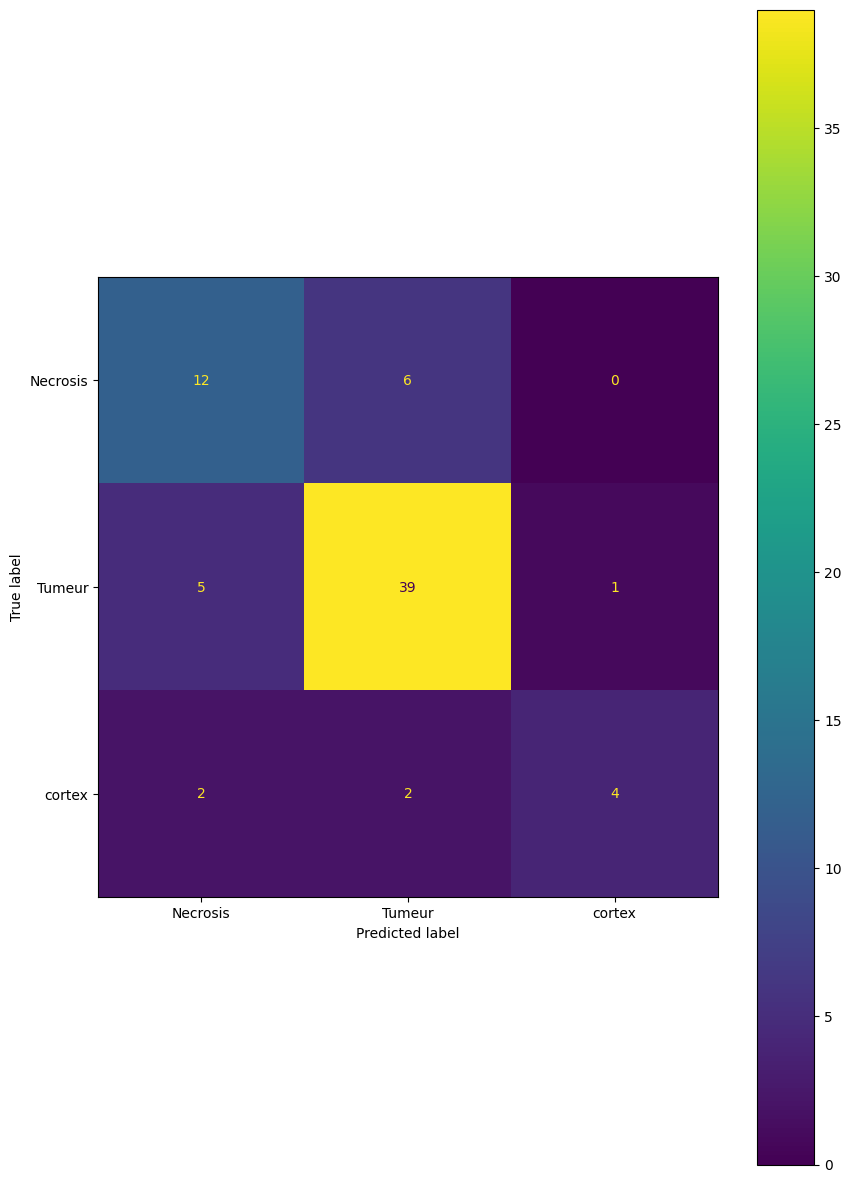

In [34]:
# confusion_matrix_scores_classification_report(pipeline, X_test, y_test)
confusion_matrix_scores_classification_report(best_model_pipeline, X_test, y_test)

CV Scores: [0.76056338 0.70422535 0.82857143 0.81428571 0.72857143]
Mean CV Score: 0.7672434607645876
Std CV Score: 0.04792812289029008
              precision    recall  f1-score   support

    Necrosis       0.70      0.71      0.71        98
      Tumeur       0.84      0.83      0.83       218
      cortex       0.53      0.53      0.53        36

    accuracy                           0.77       352
   macro avg       0.69      0.69      0.69       352
weighted avg       0.77      0.77      0.77       352



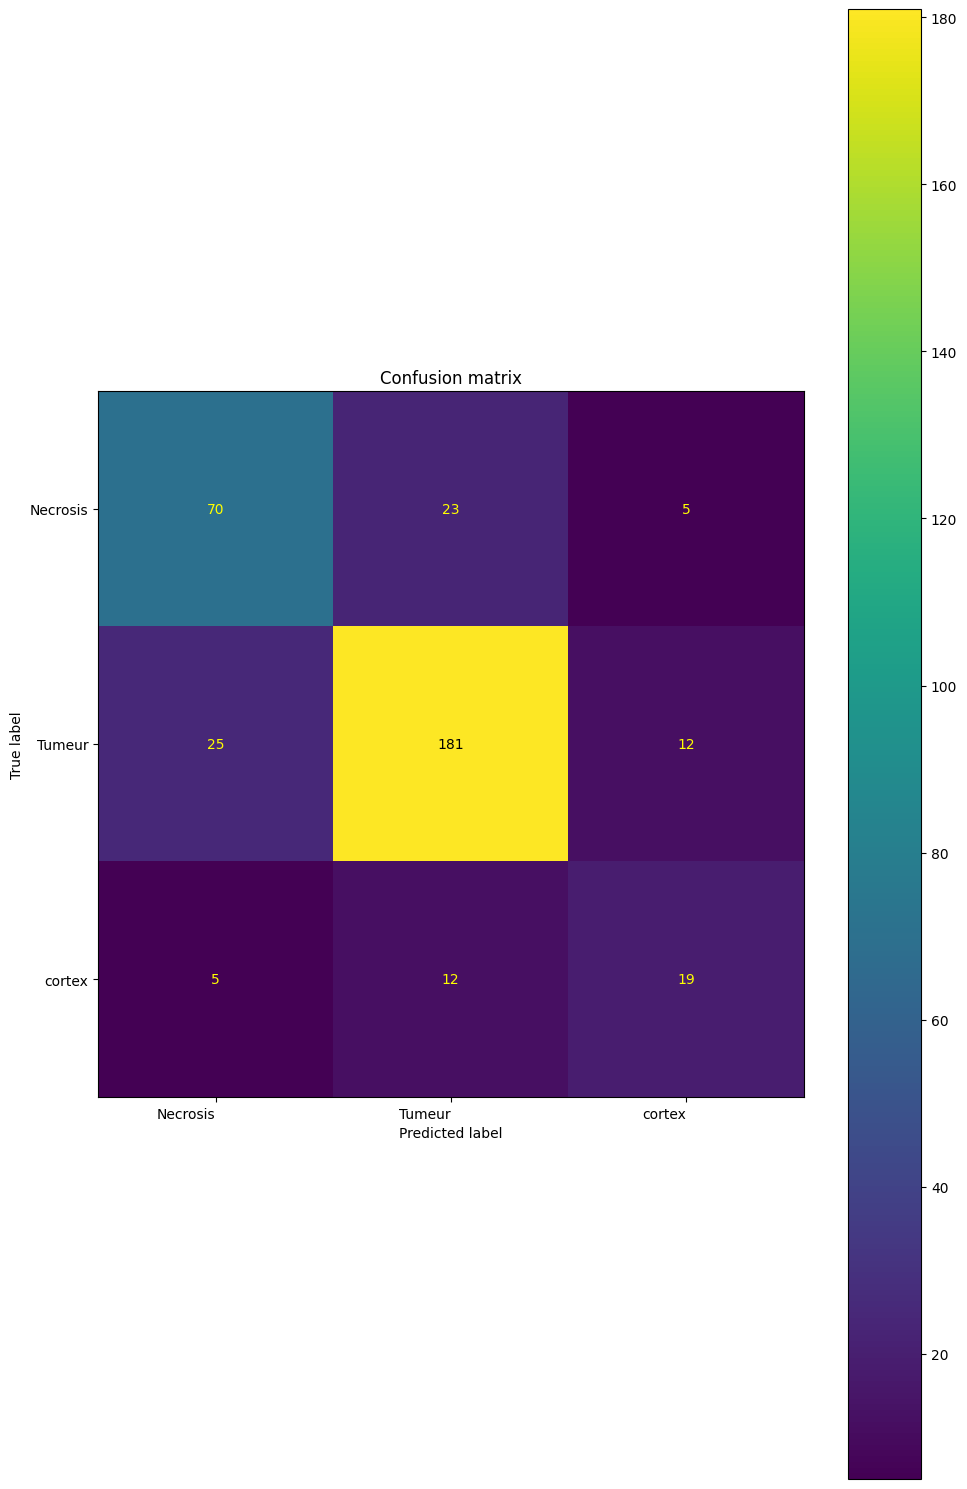

In [35]:
# cross_validate_and_report(pipeline, X, y)
cross_validate_and_report(best_model_pipeline, X, y)

In [36]:
# sample_contributions = eli5_feature_importance(pipeline, X_train)
sample_contribution = eli5_feature_importance(best_model_pipeline, X_train)
sample_contribution

In [37]:
# save_contributions("csv_name.csv", pipeline, X_train)
# Step 7: Save Contributions in CSV Format (for all samples in the train set)
save_contributions("Lime_gliom_pos_metabolites_logisticreg.csv", best_model_pipeline, X_train)

In [38]:
# Perform peak picking and obtain the peak-picked data
window_length = 5
poly_order = 2
threshold = 0.002
ms_data = data.drop(["Class"], axis=1)
data_pick_picked = peak_picking(ms_data, window_length, poly_order, threshold)

In [39]:
data_pick_picked

,102.05000,103.15000,105.55000,109.45000,109.95000,112.05000,112.95000,115.05000,117.05000,118.05000,...,61.05000,81.55000,84.95000,86.55000,88.95000,89.45000,95.05000,98.05000,99.05000,Class
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,Necrosis
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Necrosis
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Necrosis
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Necrosis
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,Necrosis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,cortex
348,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,cortex
349,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,cortex
350,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,cortex


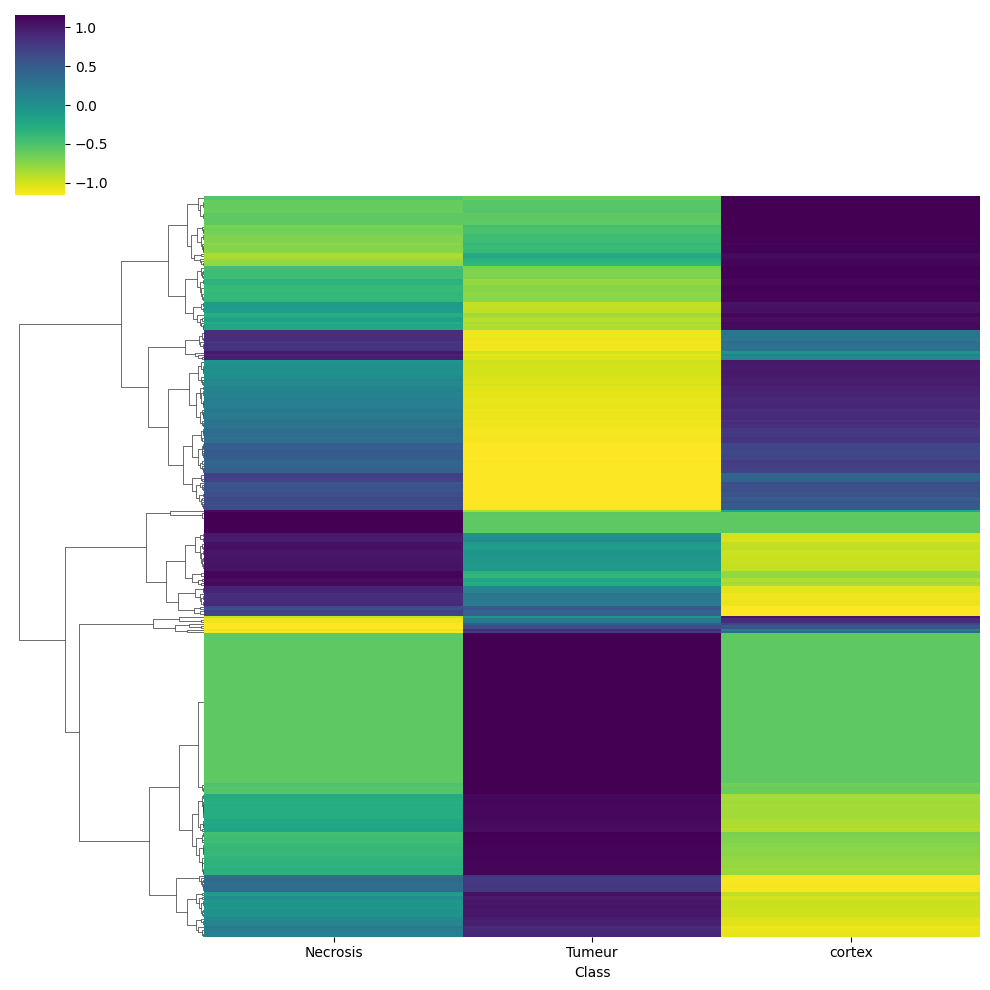

In [40]:
# Generate the heatmap
create_heatmap(data_pick_picked)

In [41]:
# Get significant features from peak-picked data
significant_mz_values = significant_features(data_pick_picked, alpha = 0.05)

In [42]:
len(significant_mz_values)

51

In [43]:
significant_mz_values

['131.05000',
 '133.05000',
 '140.05000',
 '143.05000',
 '145.05000',
 '173.05000',
 '186.05000',
 '203.05000',
 '205.05000',
 '220.15000',
 '237.15000',
 '256.25000',
 '279.15000',
 '280.25000',
 '282.15000',
 '282.35000',
 '282.55000',
 '283.35000',
 '284.35000',
 '304.25000',
 '310.35000',
 '369.35000',
 '370.35000',
 '381.15000',
 '381.35000',
 '381.55000',
 '382.15000',
 '382.35000',
 '382.55000',
 '383.15000',
 '383.35000',
 '383.55000',
 '384.35000',
 '385.35000',
 '394.45000',
 '395.25000',
 '397.35000',
 '411.35000',
 '441.15000',
 '441.35000',
 '441.55000',
 '442.35000',
 '443.35000',
 '455.35000',
 '523.15000',
 '523.35000',
 '523.55000',
 '524.35000',
 '548.55000',
 '556.35000',
 '577.55000']

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=6.397e-07 stat=2.691e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.874e-05 stat=2.041e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=6.677e-01 stat=1.488e+00


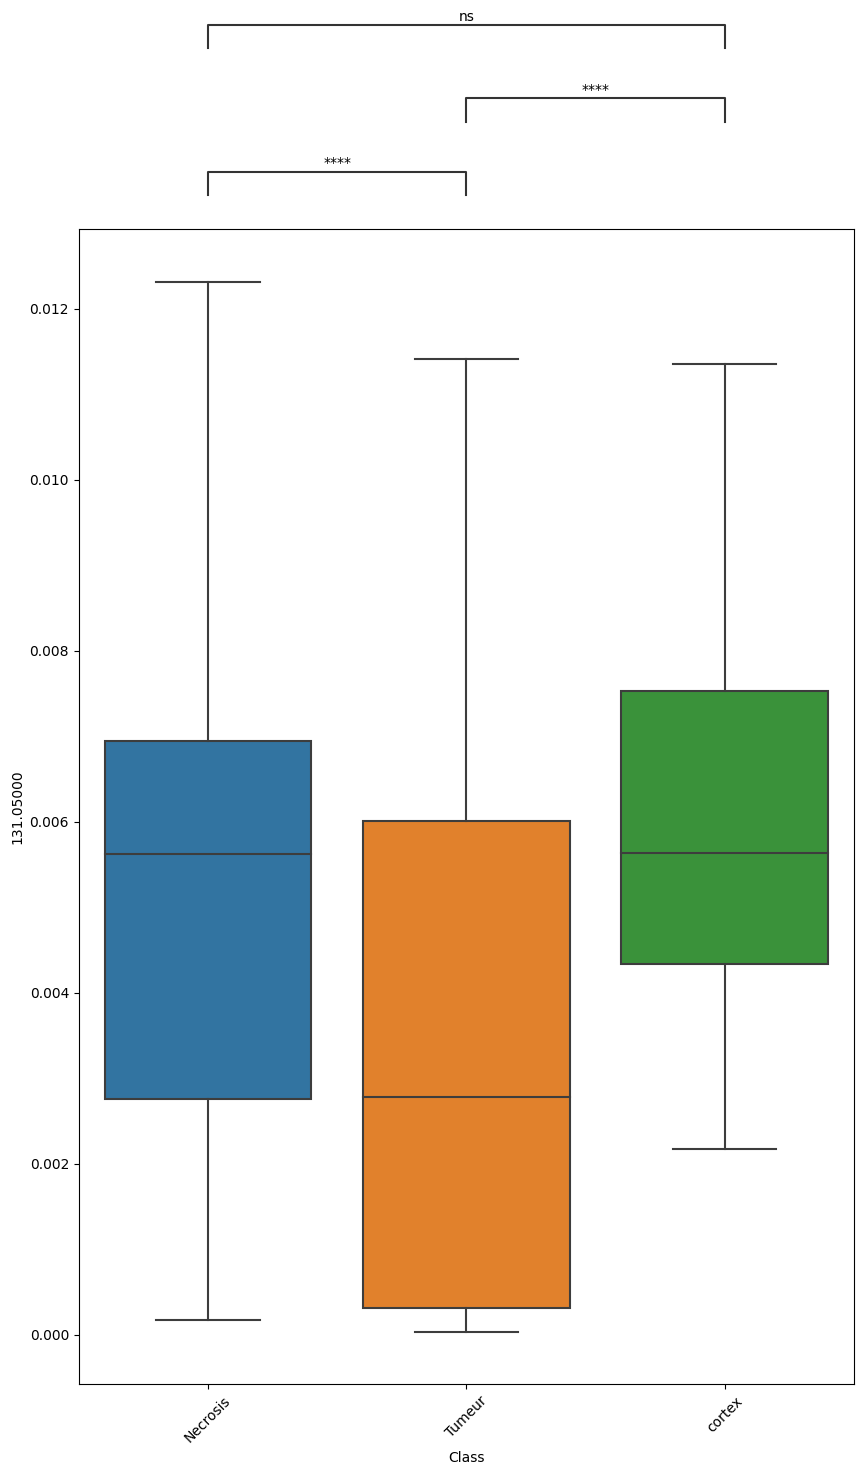

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.474e-05 stat=2.087e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.053e-07 stat=2.834e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.812e-02 stat=7.539e+00


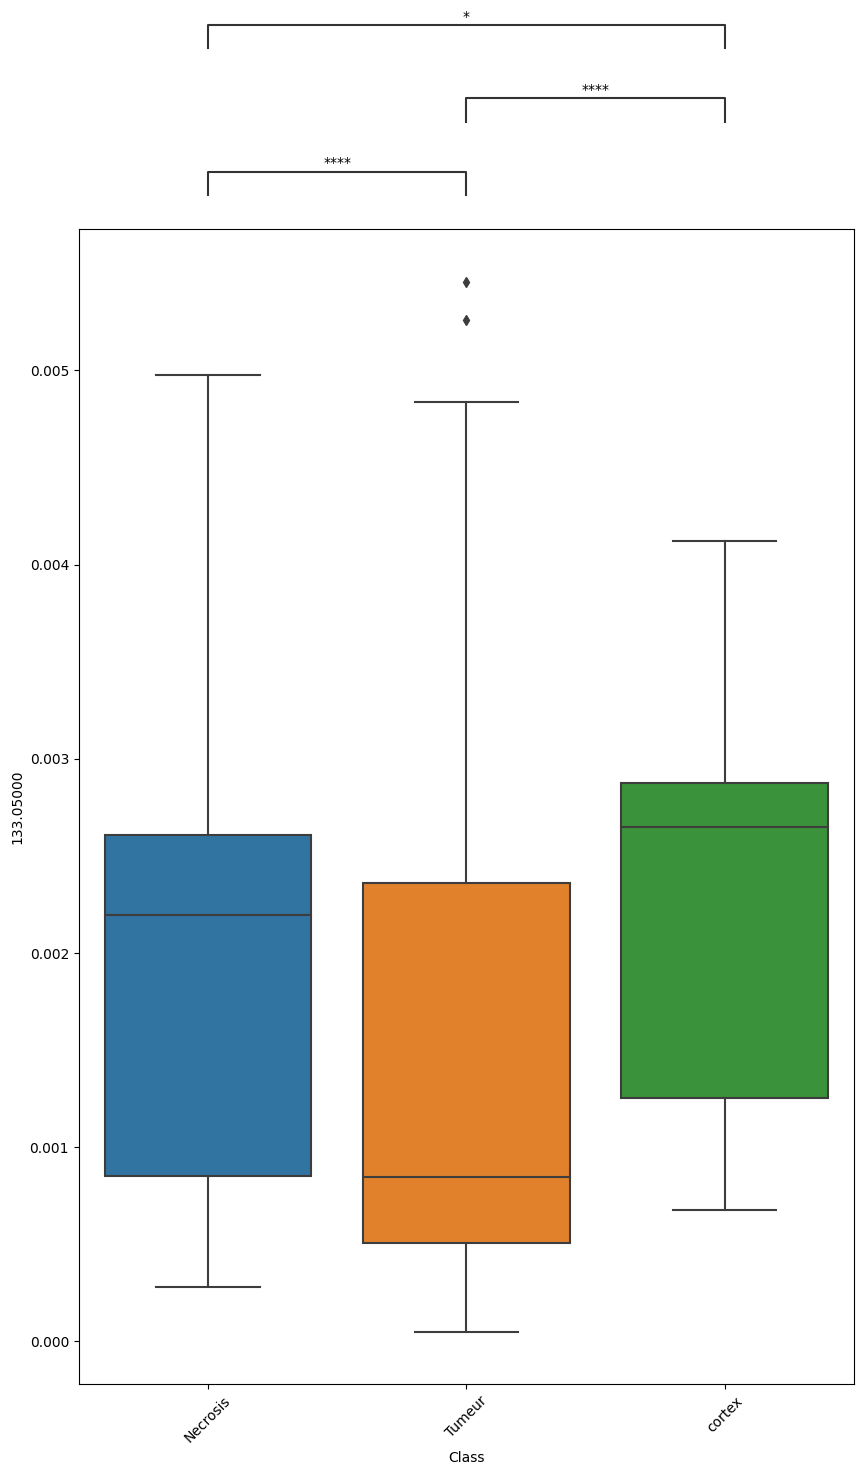

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.370e-06 stat=2.544e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=8.524e-06 stat=2.192e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=5.504e-01 stat=1.769e+00


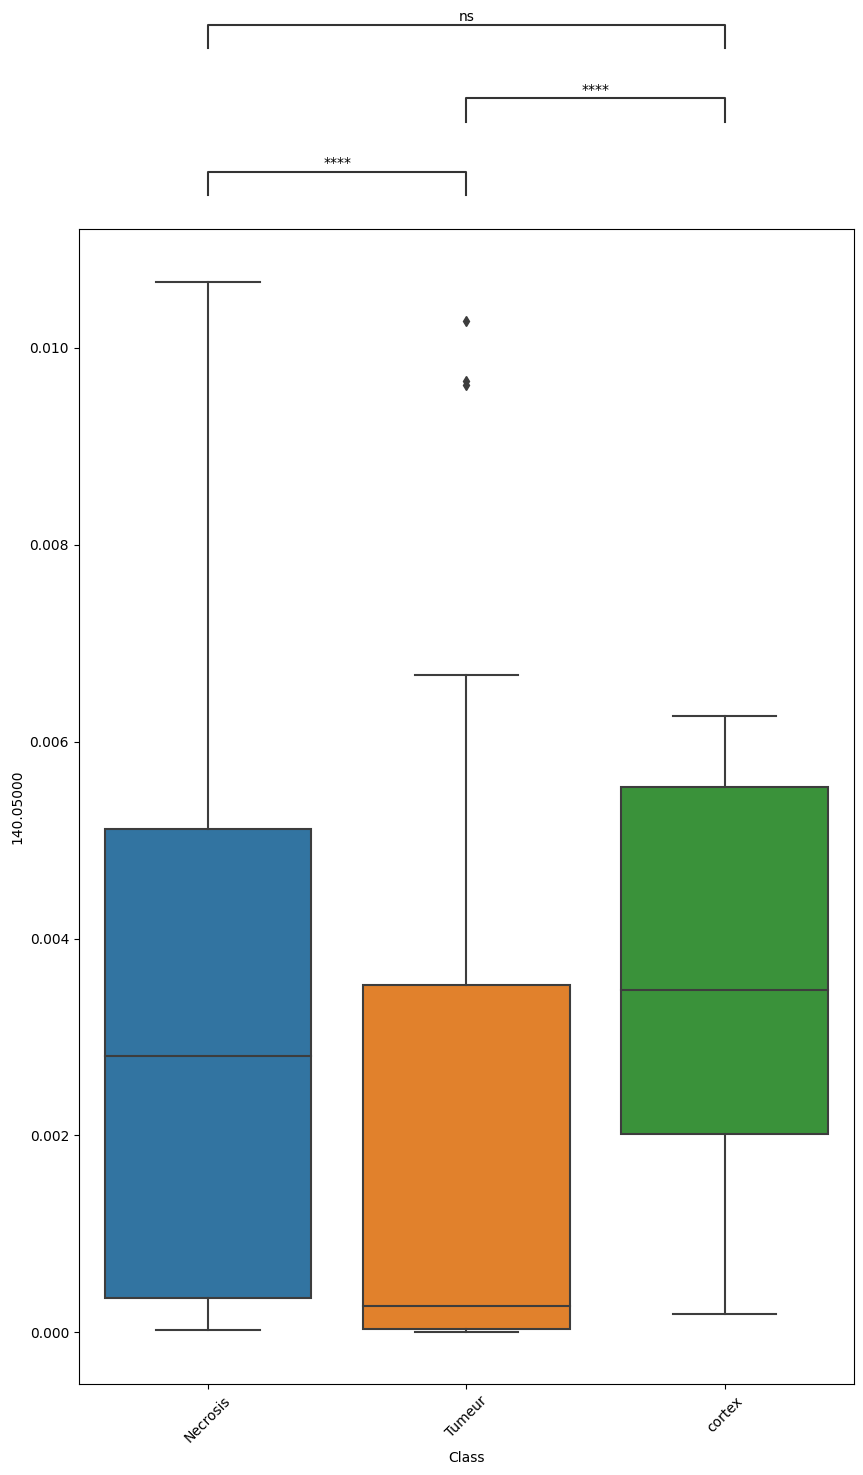

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.119e-06 stat=2.583e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.095e-04 stat=1.705e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=6.370e-01


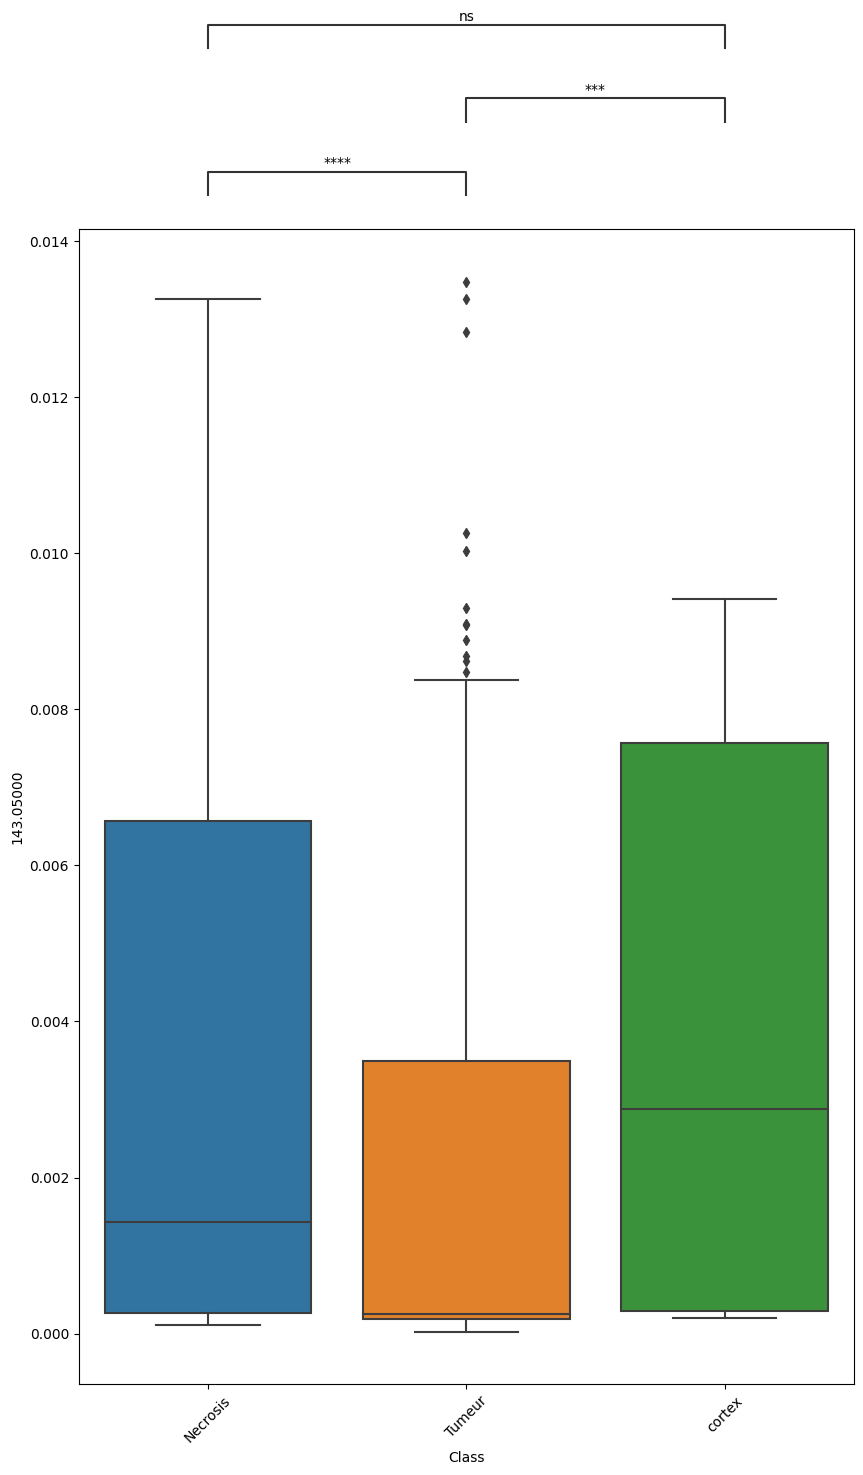

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.206e-06 stat=2.380e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=5.223e-04 stat=1.409e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=6.943e-01


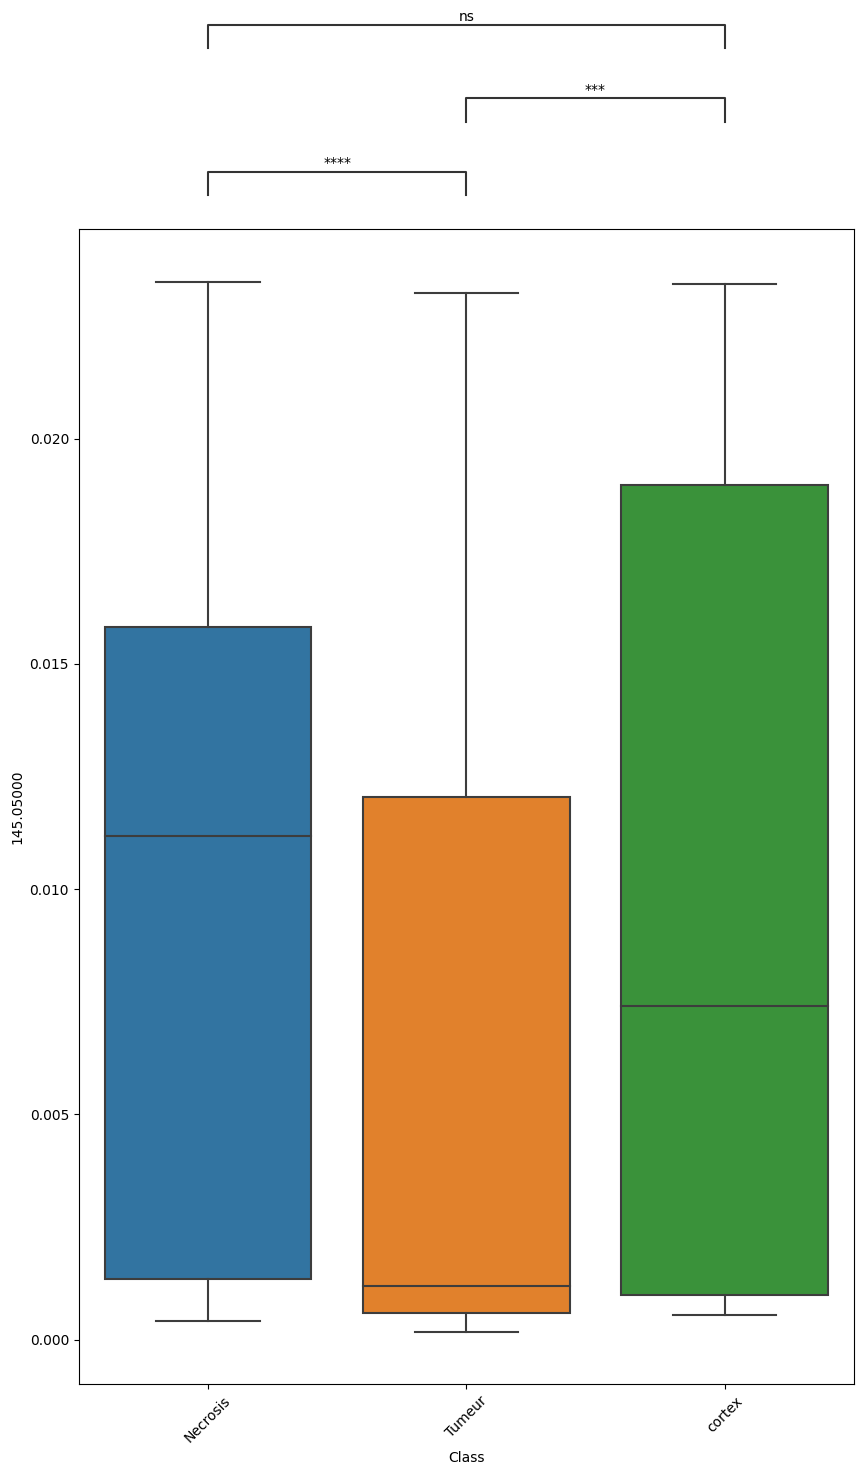

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=5.323e-05 stat=1.842e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.994e-03 stat=1.083e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=3.508e-01


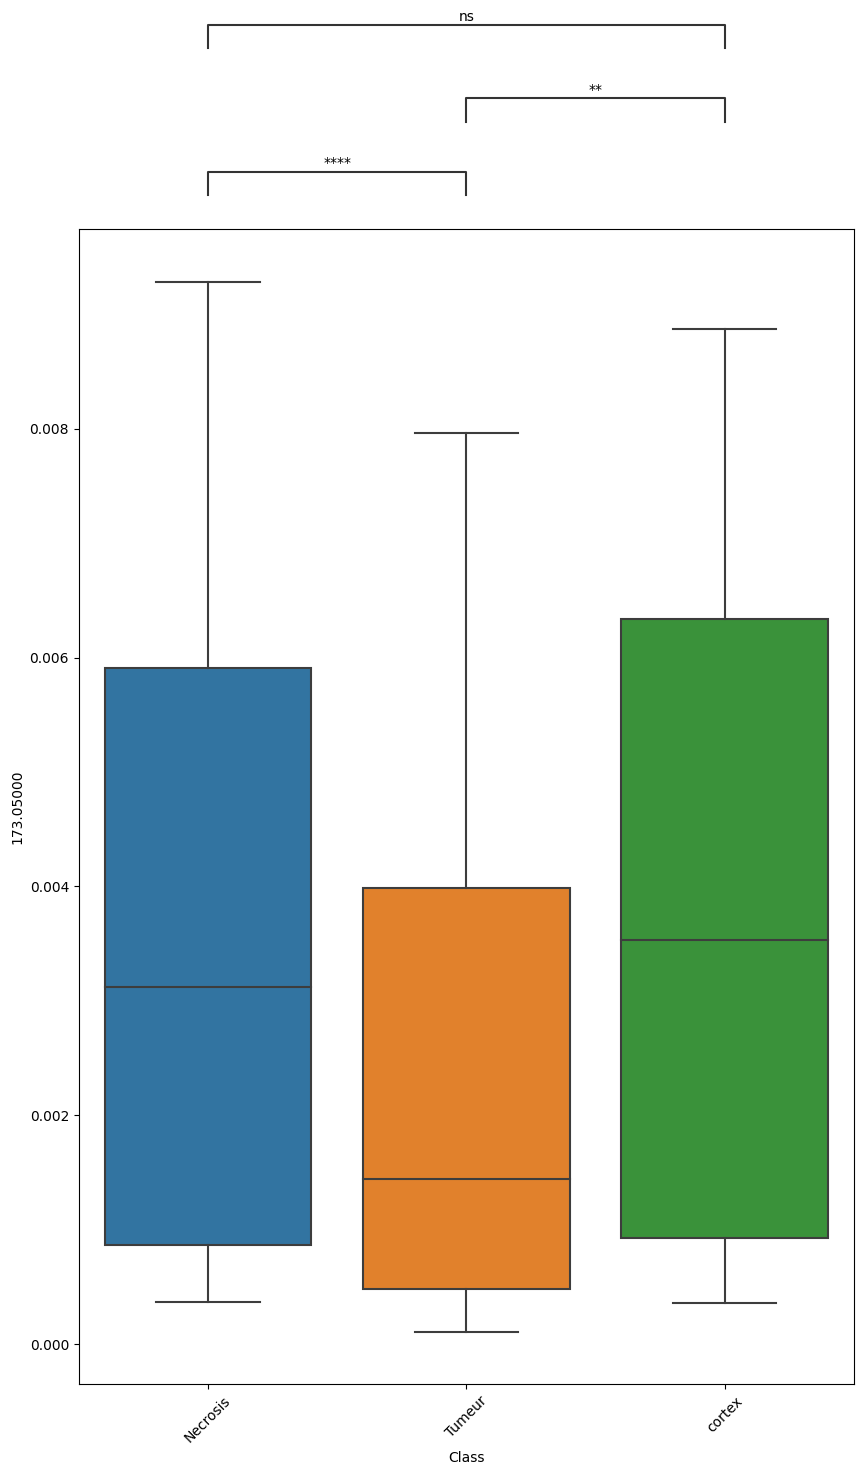

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.148e-07 stat=2.902e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=7.207e-06 stat=2.224e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=9.104e-01 stat=1.059e+00


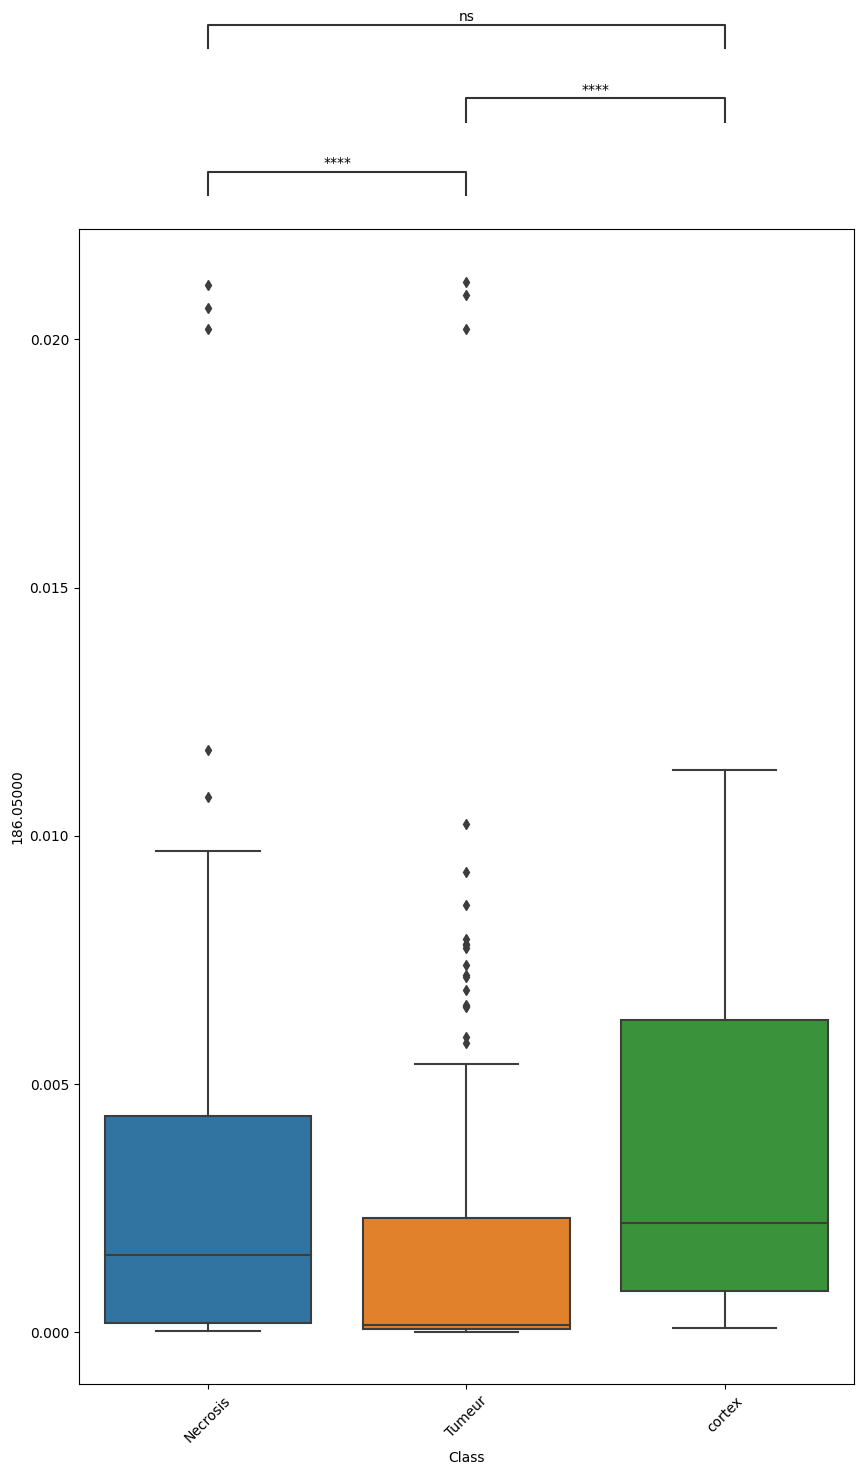

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=9.608e-09 stat=3.506e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=4.119e-06 stat=2.332e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=9.536e-01 stat=9.978e-01


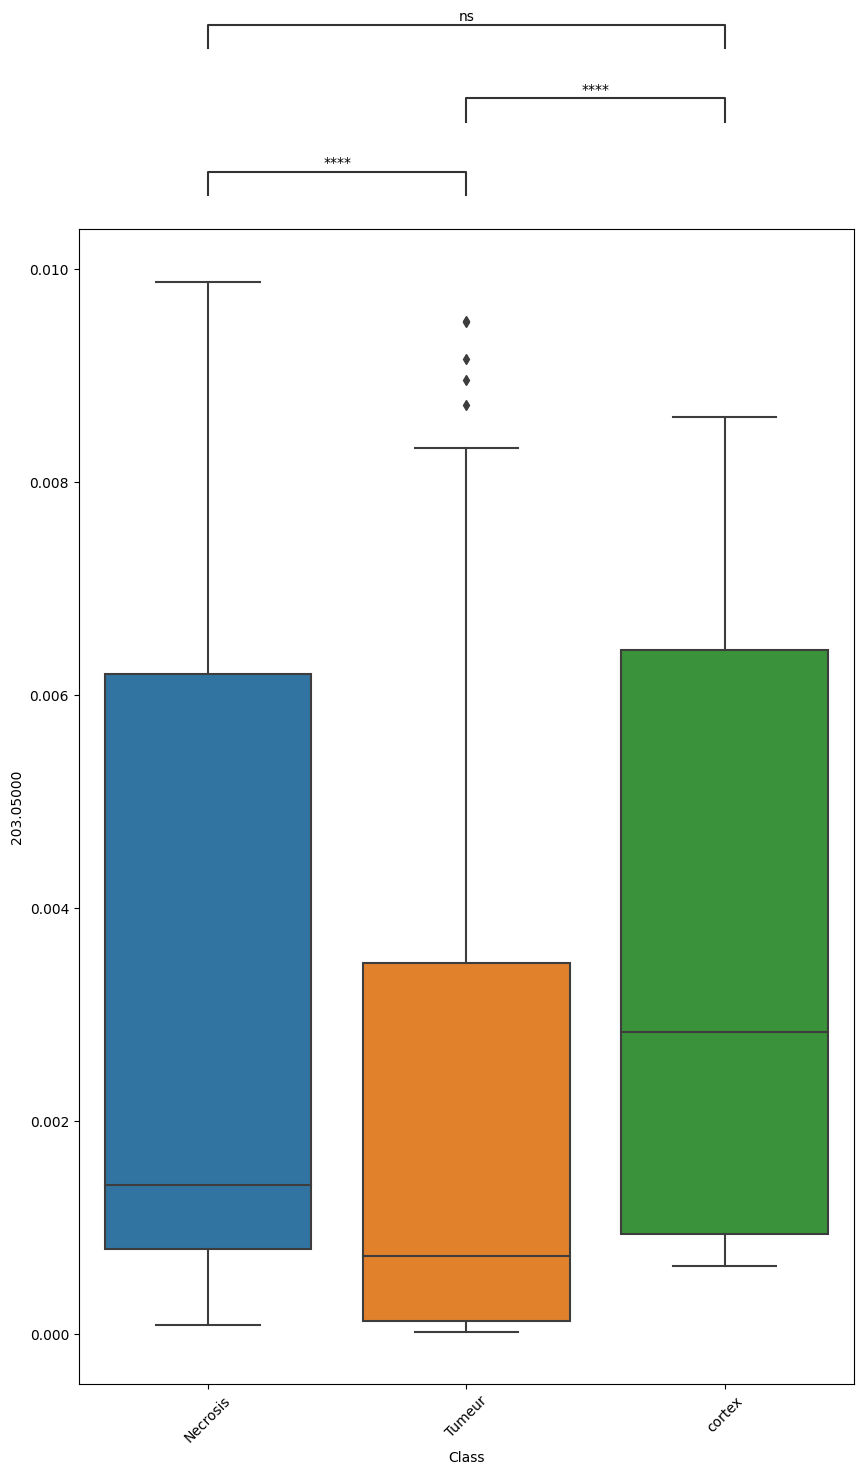

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.691e-05 stat=1.972e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.779e-03 stat=1.040e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=4.064e-01


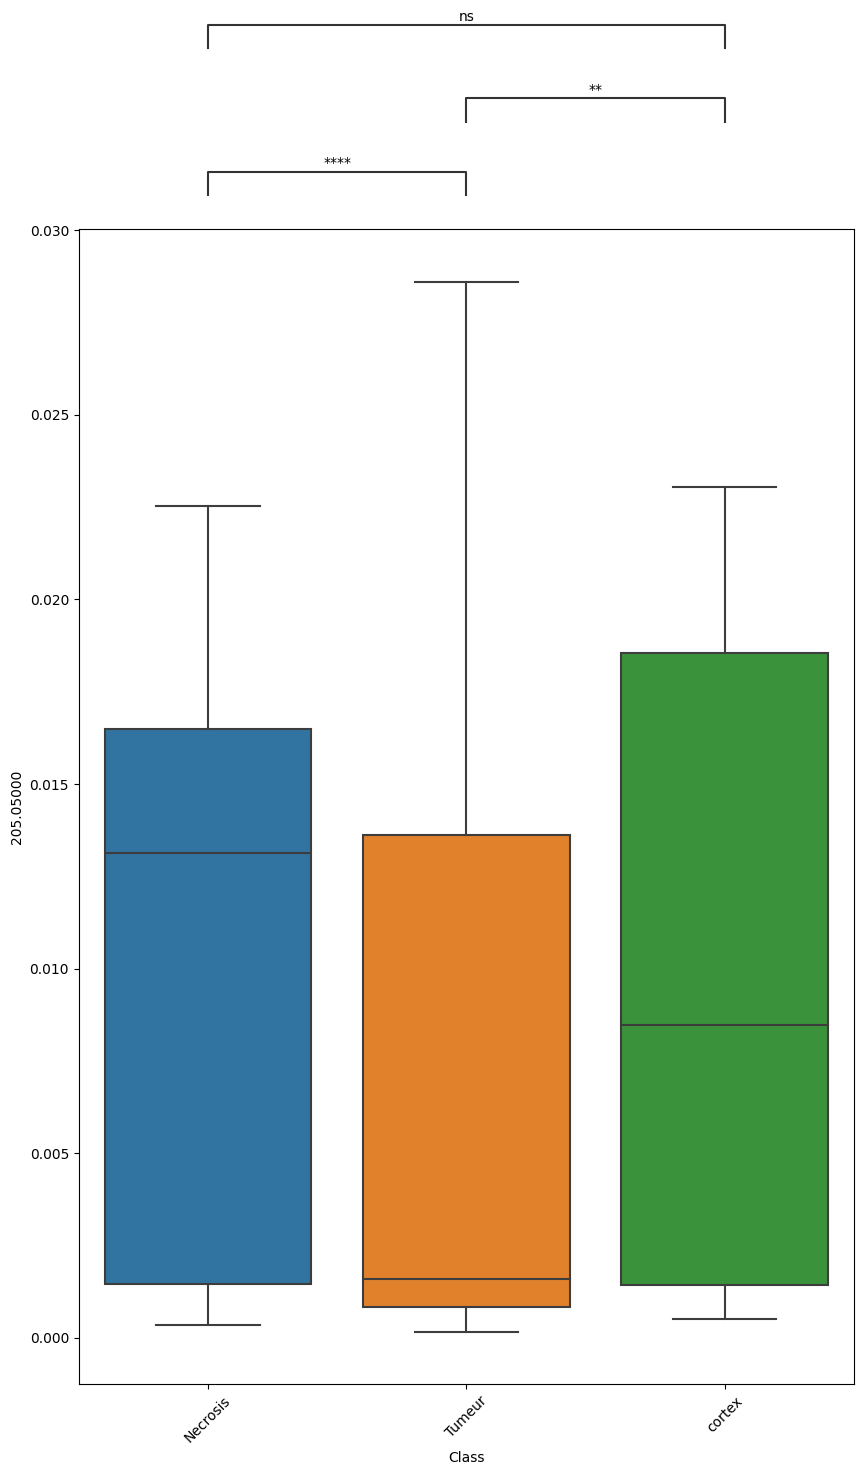

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=2.793e-01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=6.140e-01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=2.268e-04


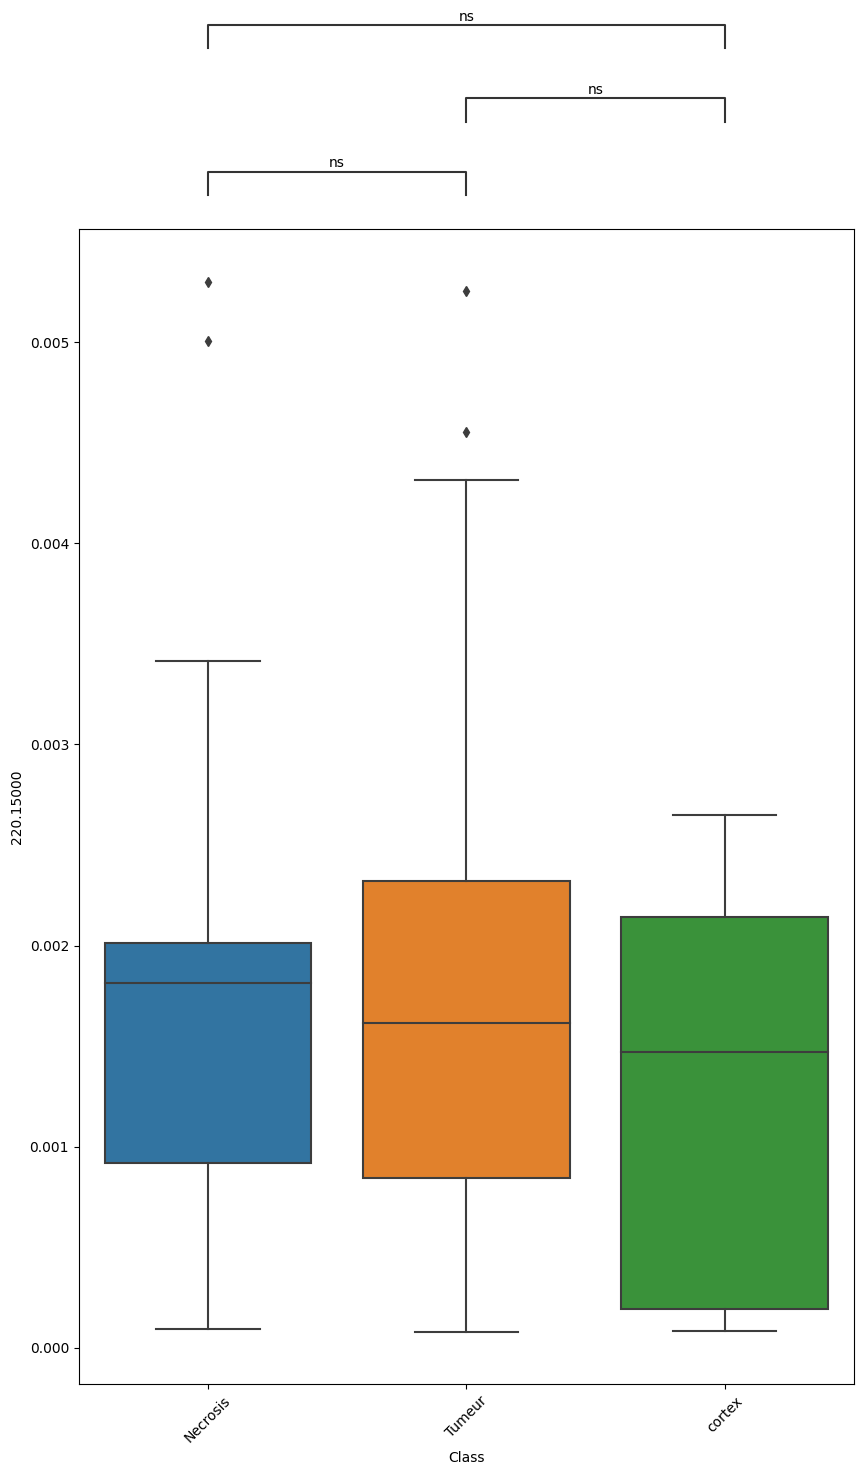

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=5.777e-01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.495e-01 stat=2.464e+00
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=7.367e-01


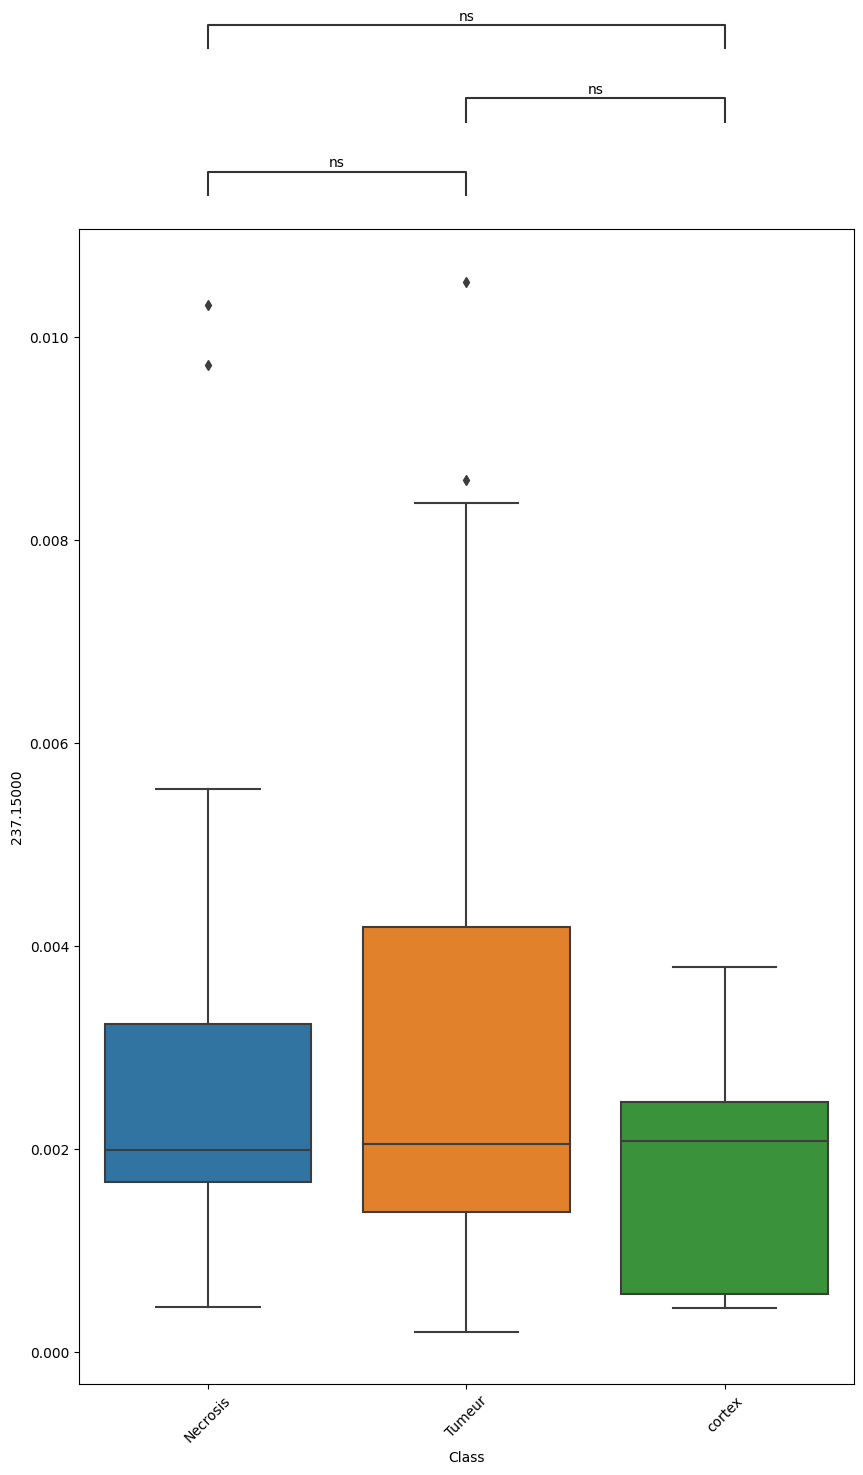

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.270e-11 stat=4.616e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=7.936e-05 stat=1.766e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.778e-01


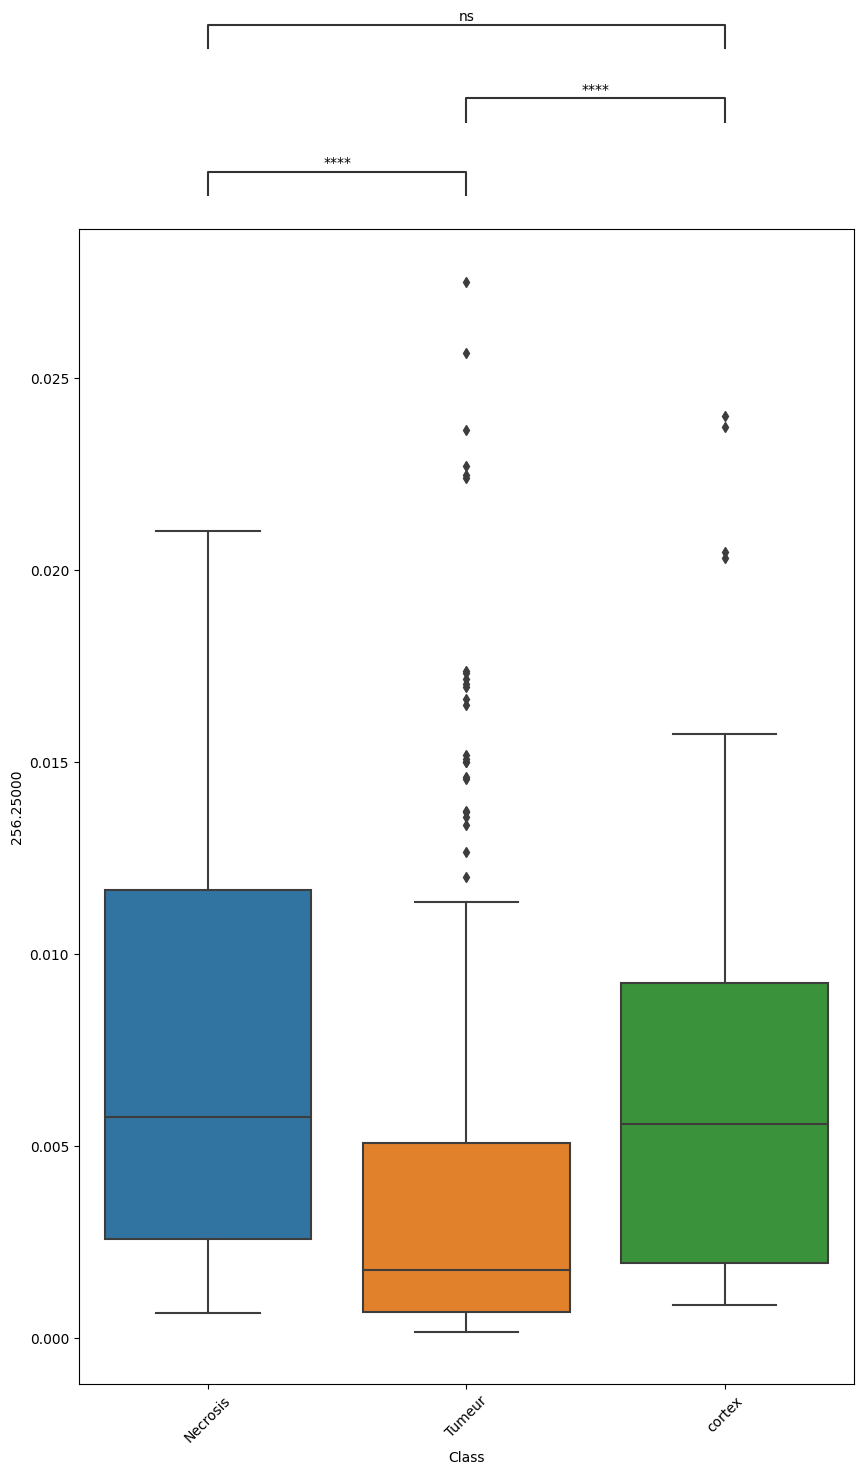

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.510e-06 stat=2.525e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.790e-04 stat=1.527e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.343e-01


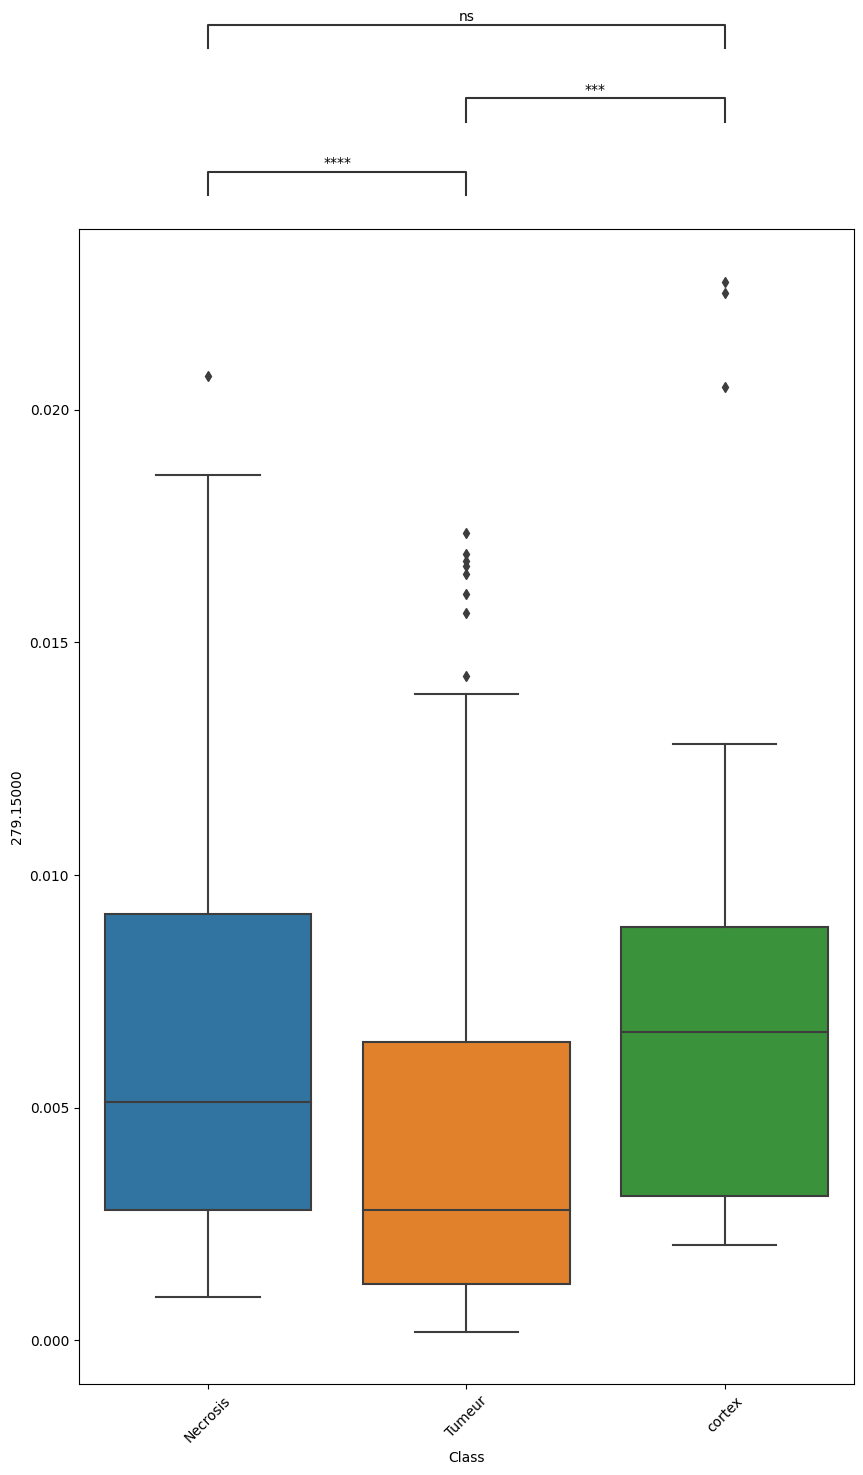

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=5.664e-07 stat=2.714e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.230e-03 stat=1.249e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=4.258e-03


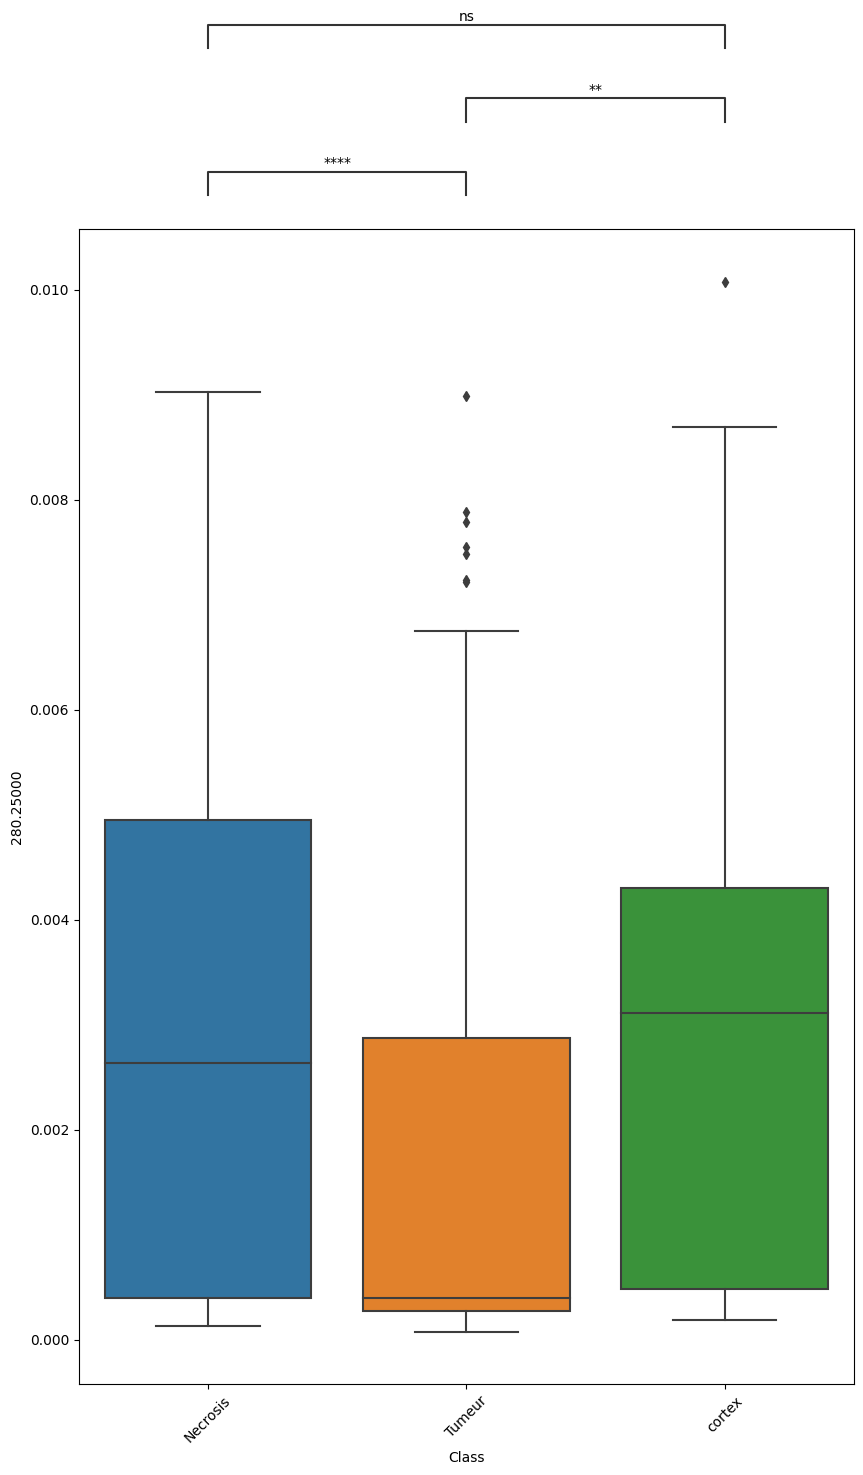

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.279e-01 stat=4.110e+00
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=4.645e-01 stat=2.024e+00
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=2.913e-02


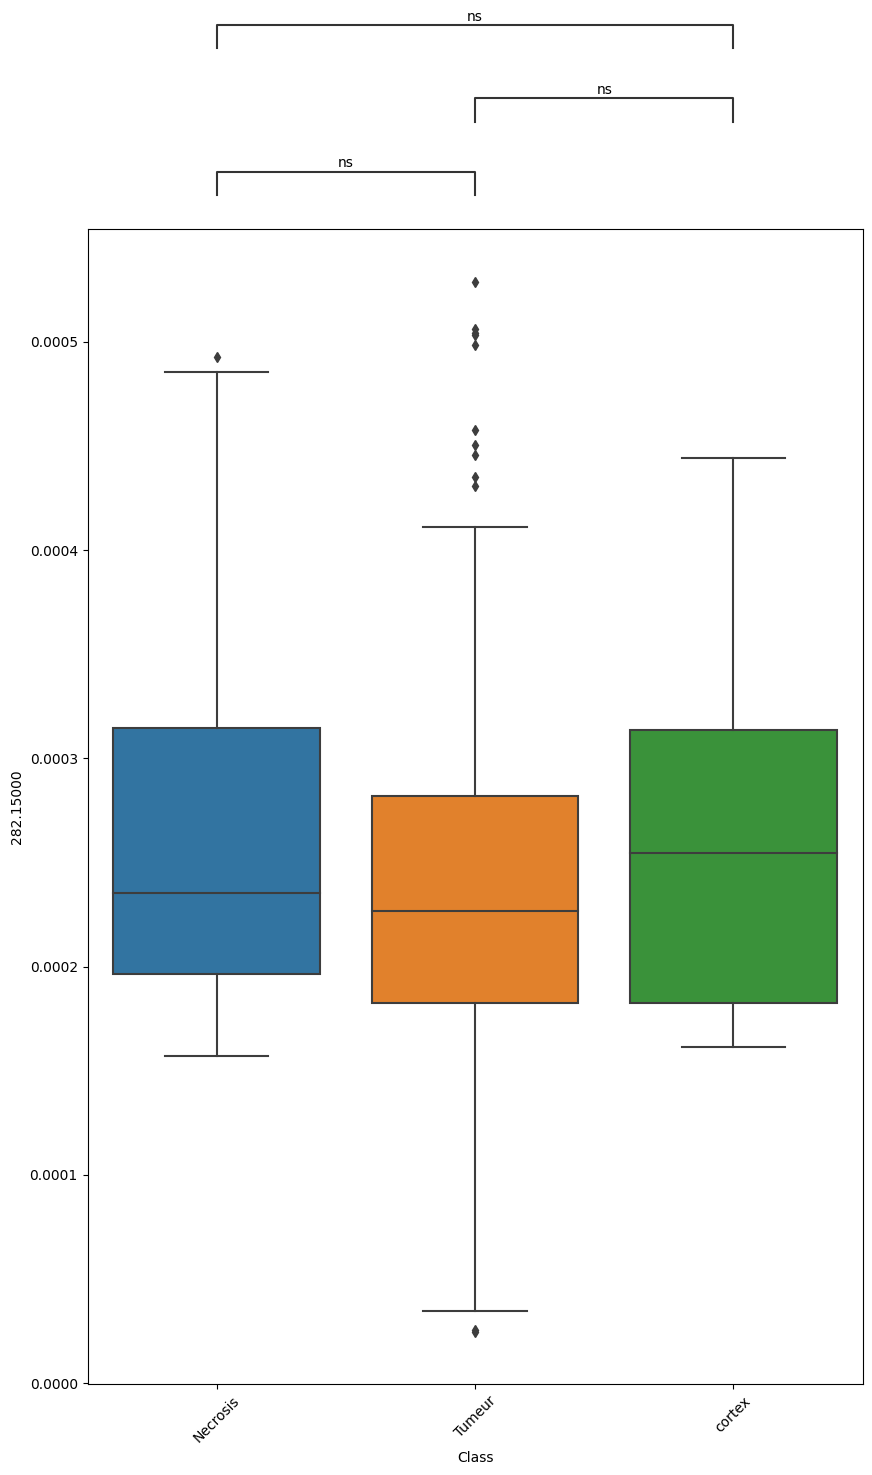

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.437e-08 stat=3.427e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.688e-05 stat=2.061e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=2.520e-03


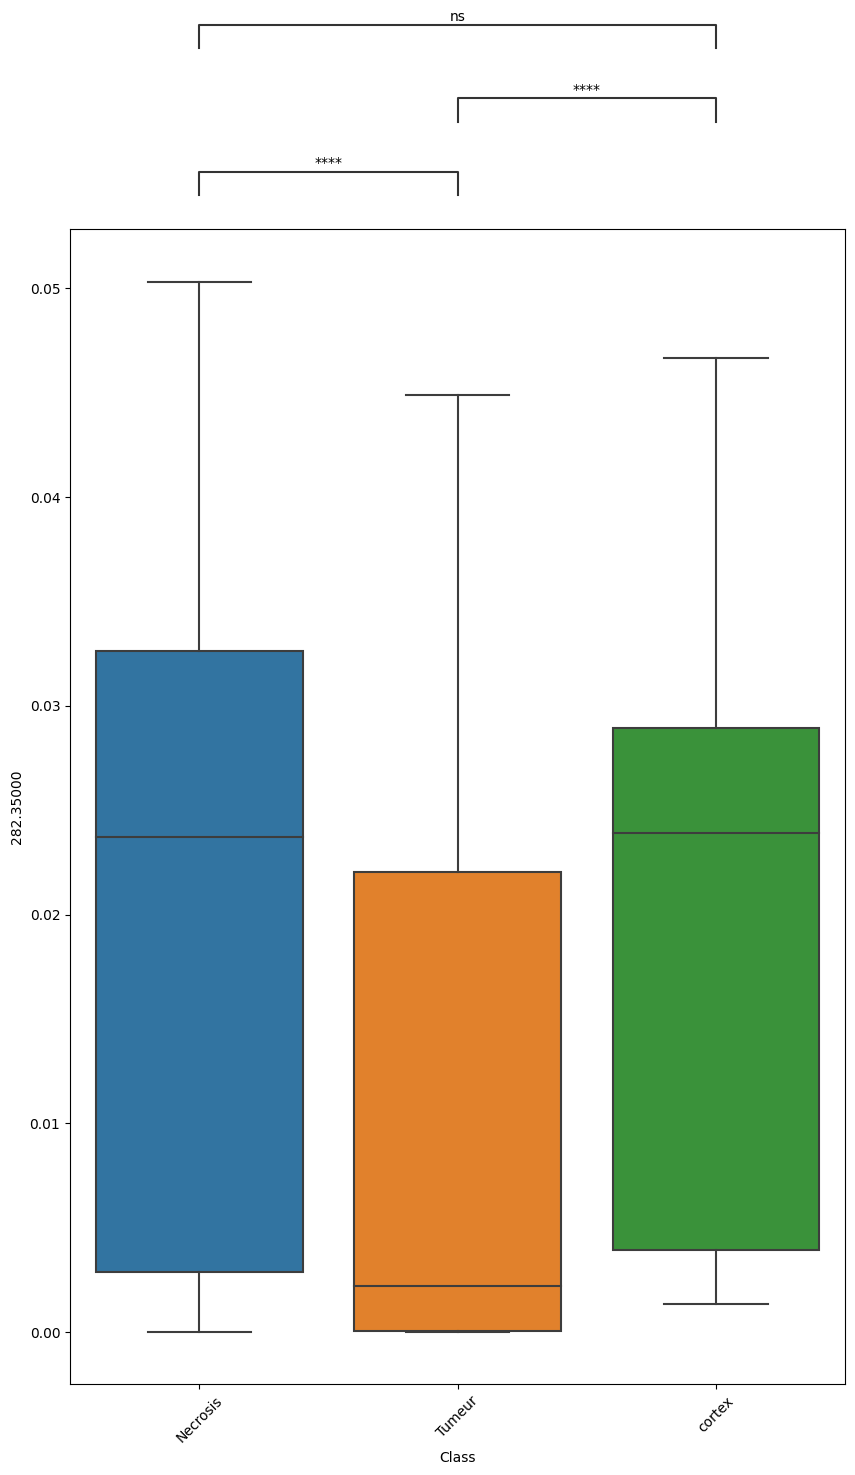

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.810e-08 stat=3.382e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=4.127e-06 stat=2.331e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.612e-01


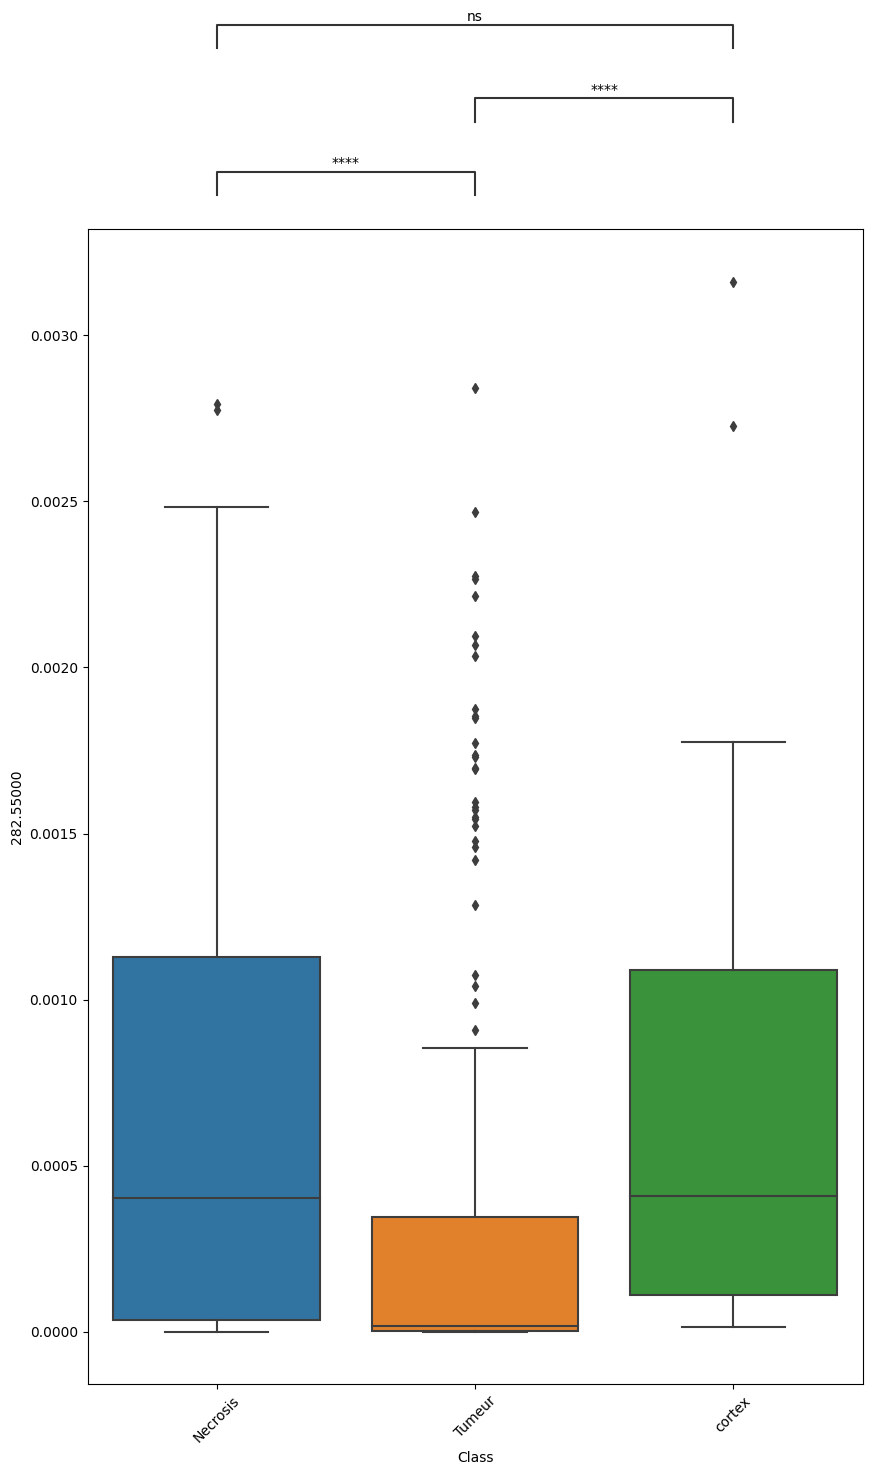

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.426e-08 stat=3.429e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.768e-05 stat=2.052e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=5.805e-02


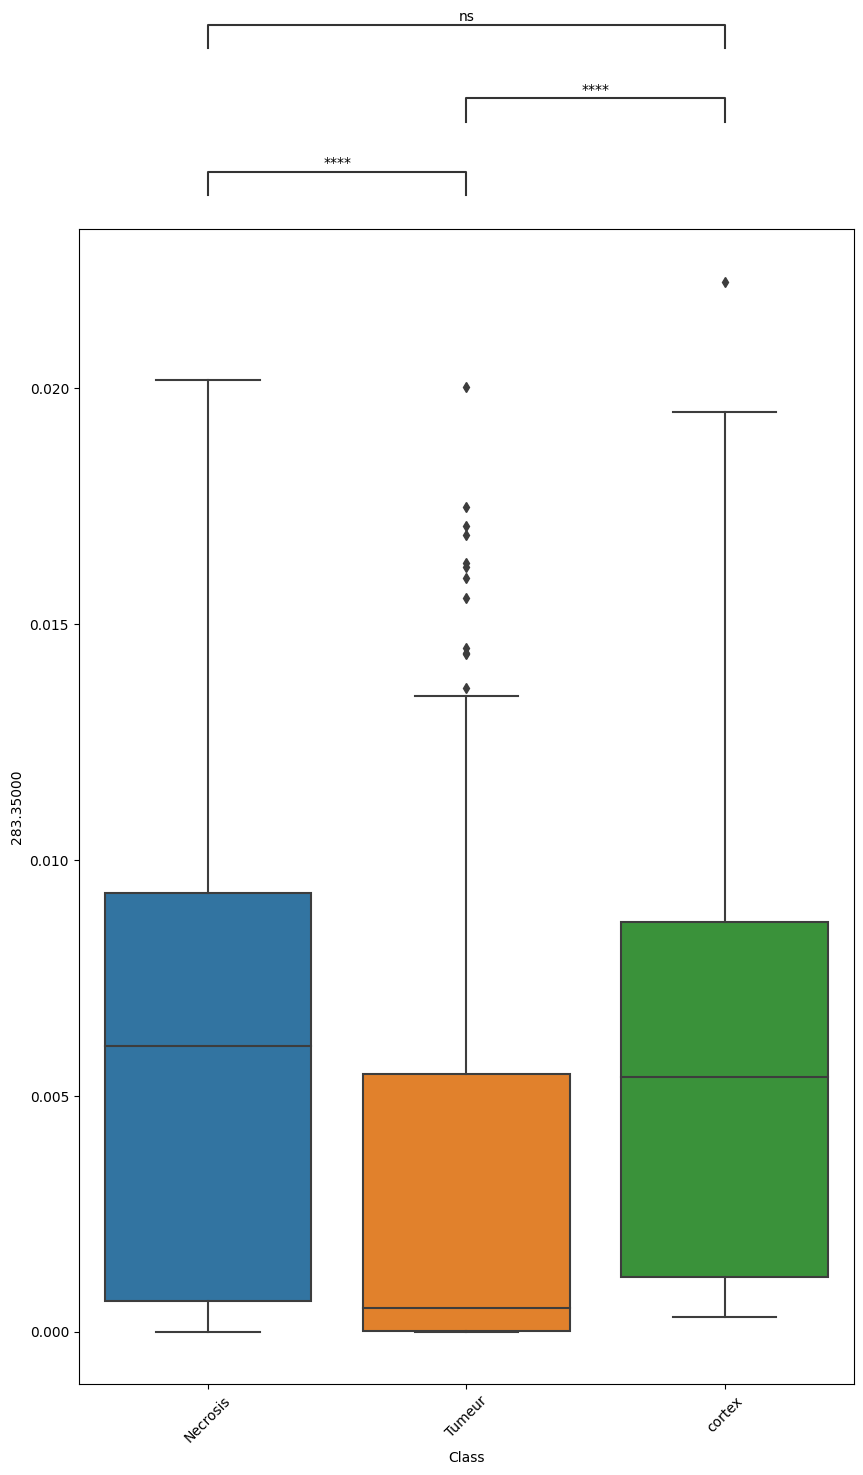

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=5.402e-10 stat=4.067e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=7.120e-05 stat=1.786e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.235e-03


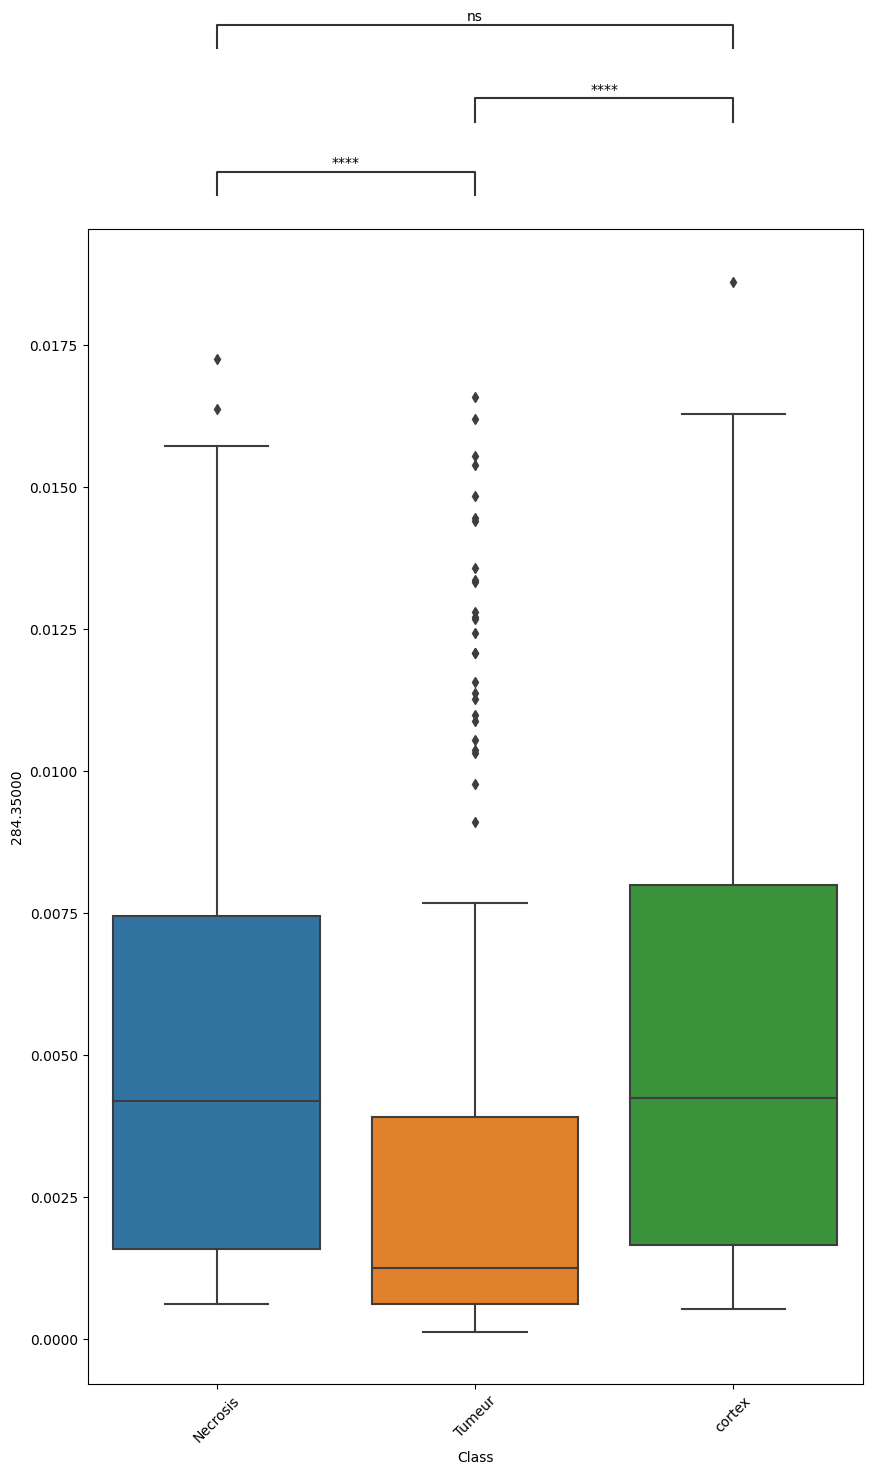

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.512e-05 stat=2.082e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=4.792e-03 stat=9.963e+00
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=8.163e-03


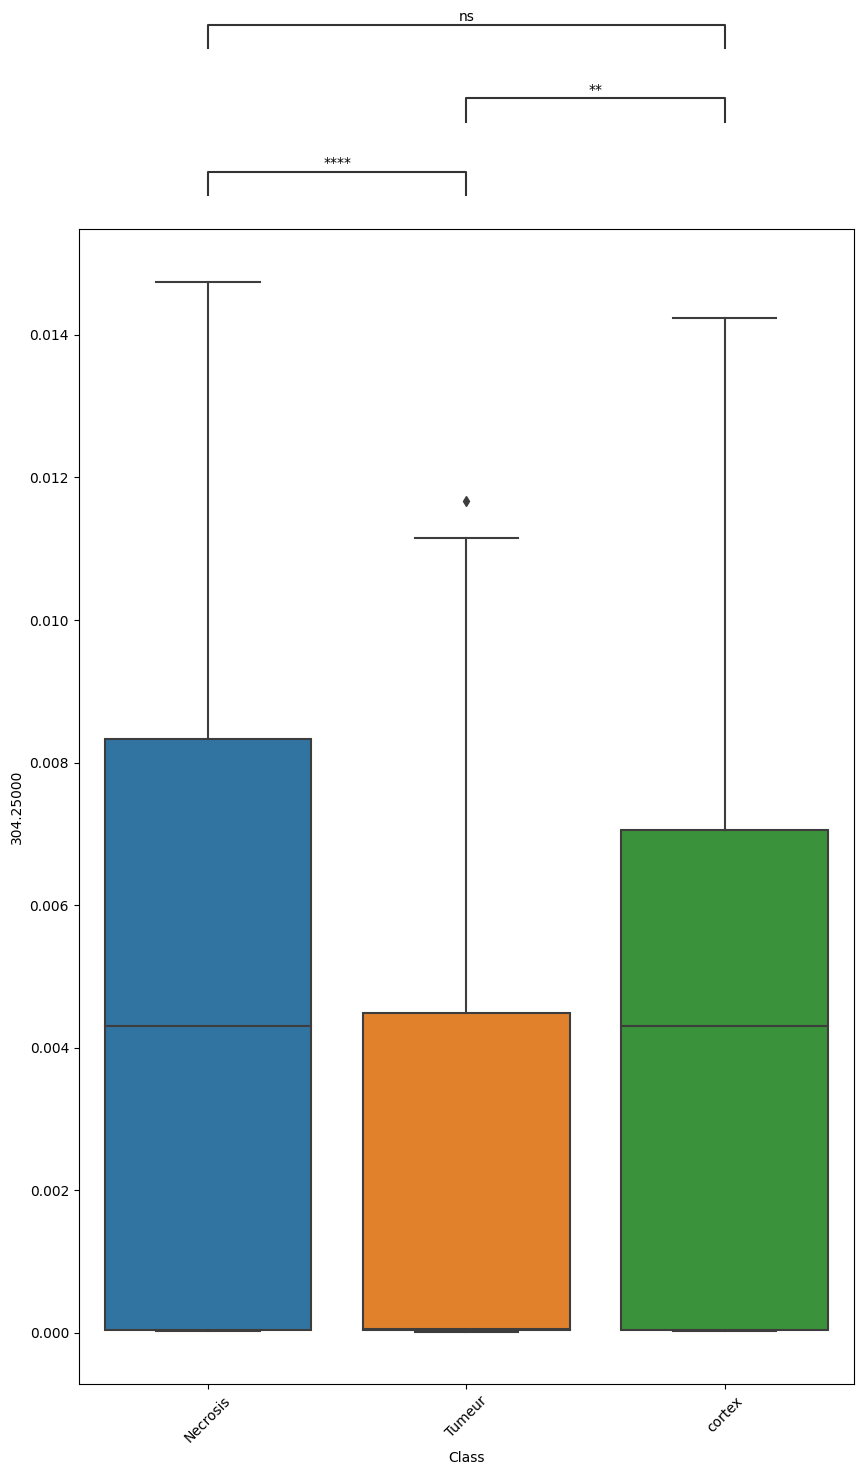

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=7.102e-08 stat=3.117e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=5.297e-05 stat=1.843e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.612e-01


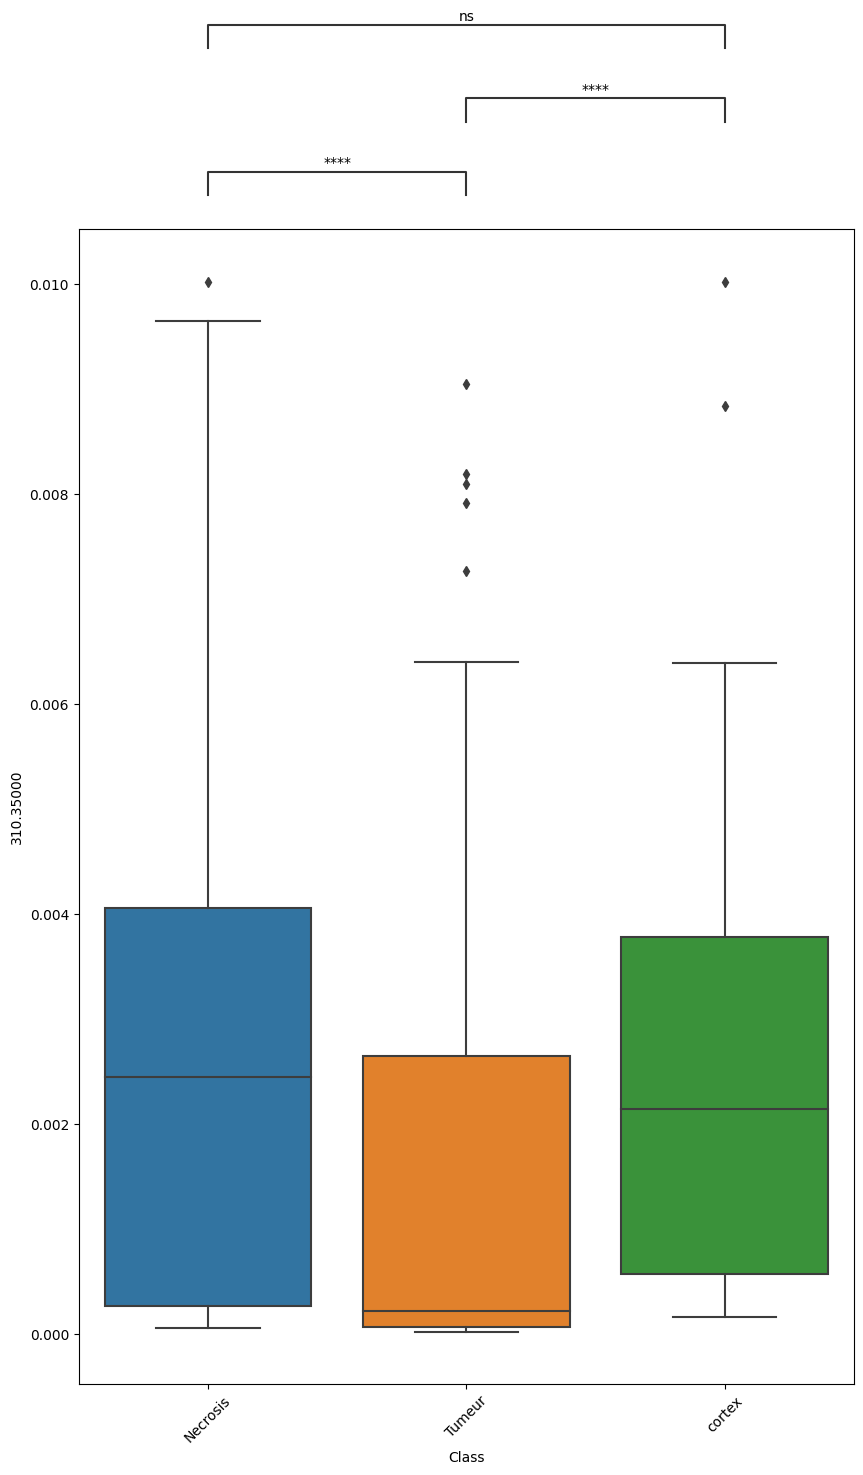

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.449e-06 stat=2.533e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=8.941e-06 stat=2.183e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=7.983e-01


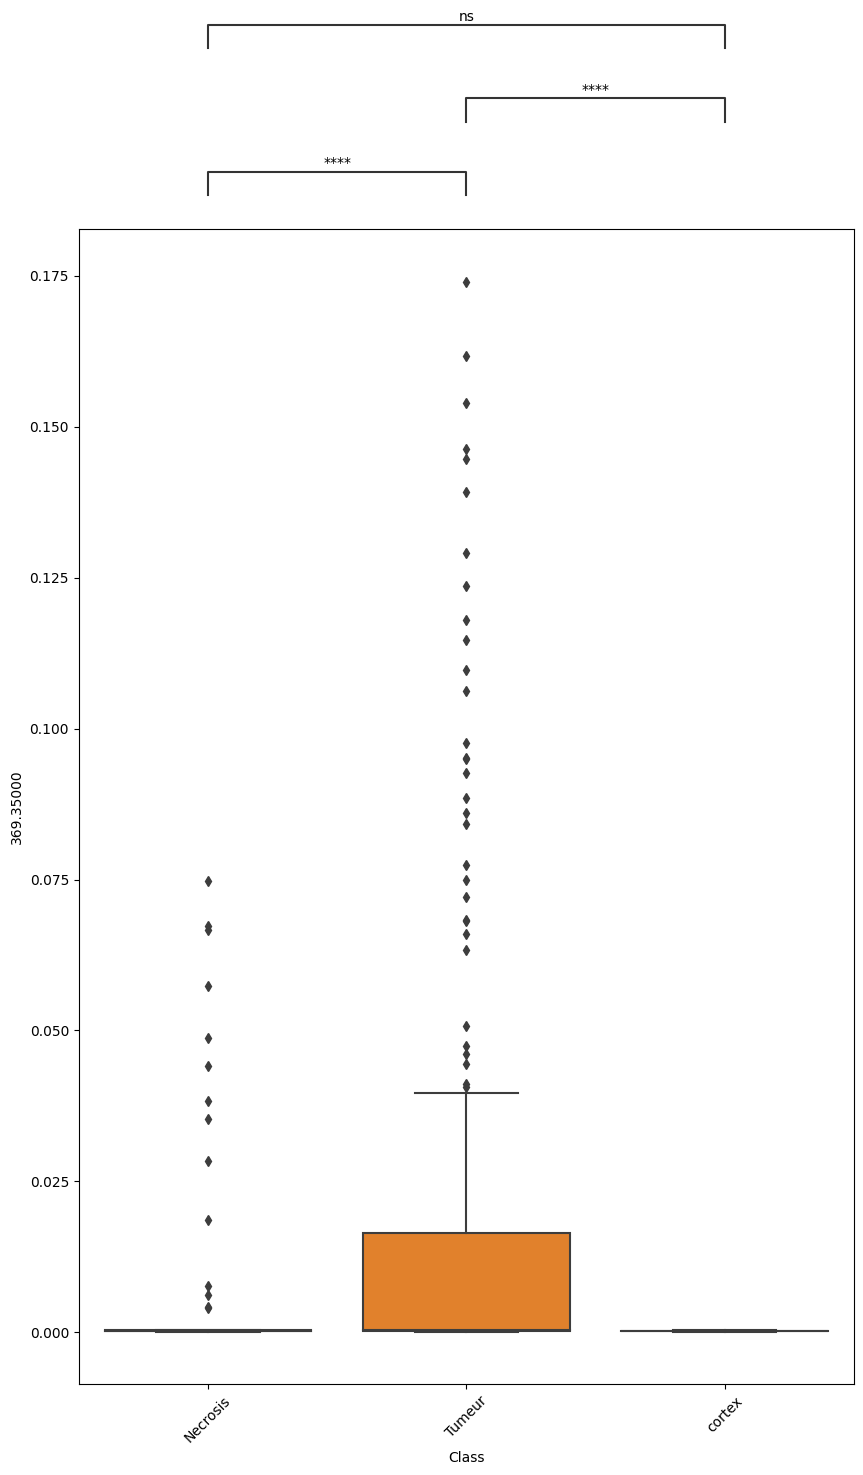

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=5.159e-07 stat=2.733e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=6.178e-05 stat=1.813e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=2.041e-03


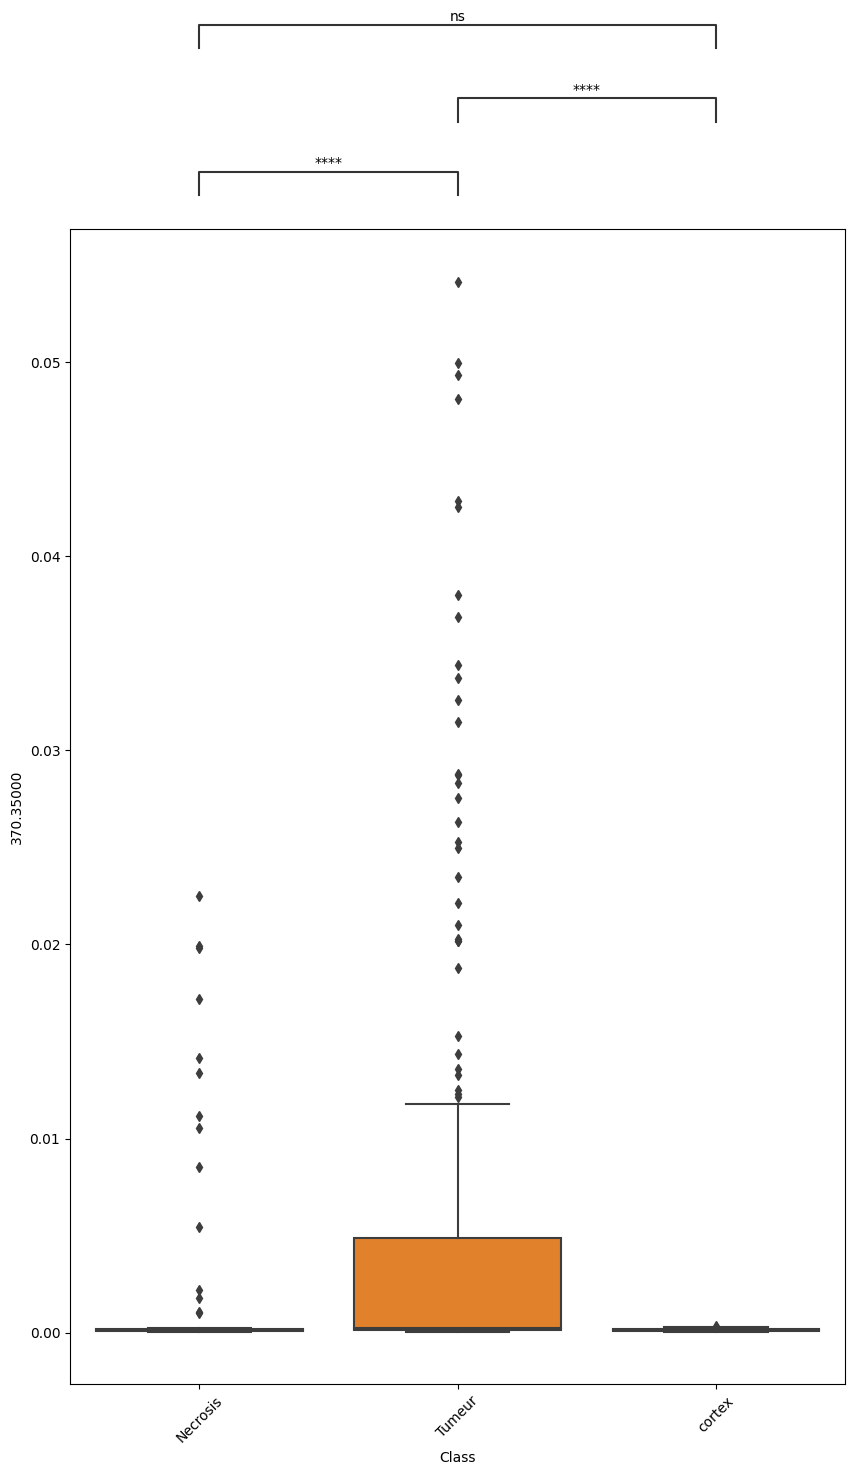

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=4.883e-02 stat=5.773e+00
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.219e-01 stat=4.191e+00
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=2.268e-04


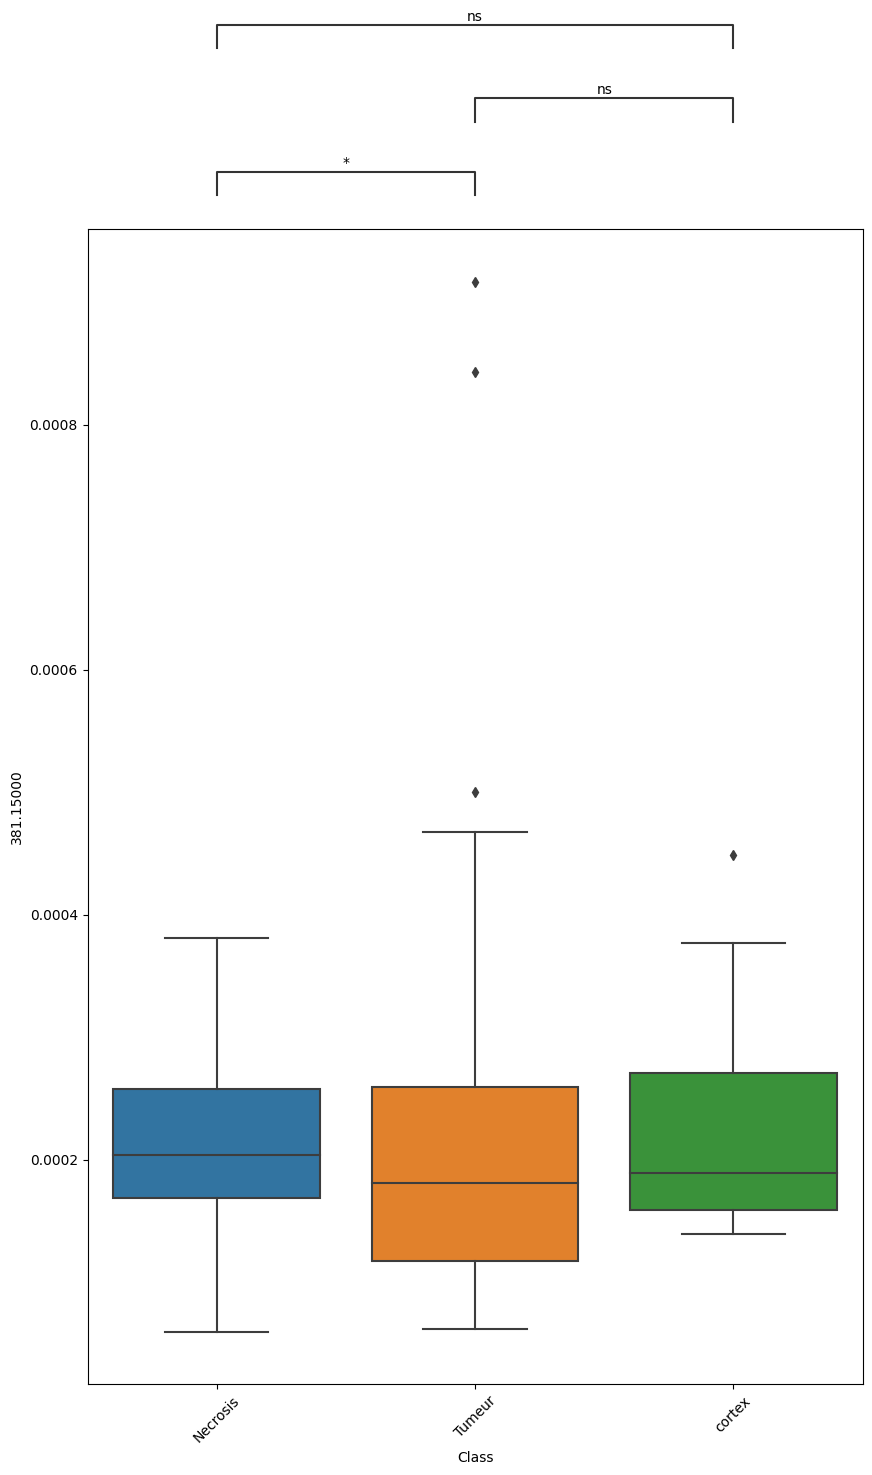

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=5.062e-04 stat=1.415e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.084e-04 stat=1.707e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.986e-01 stat=3.375e+00


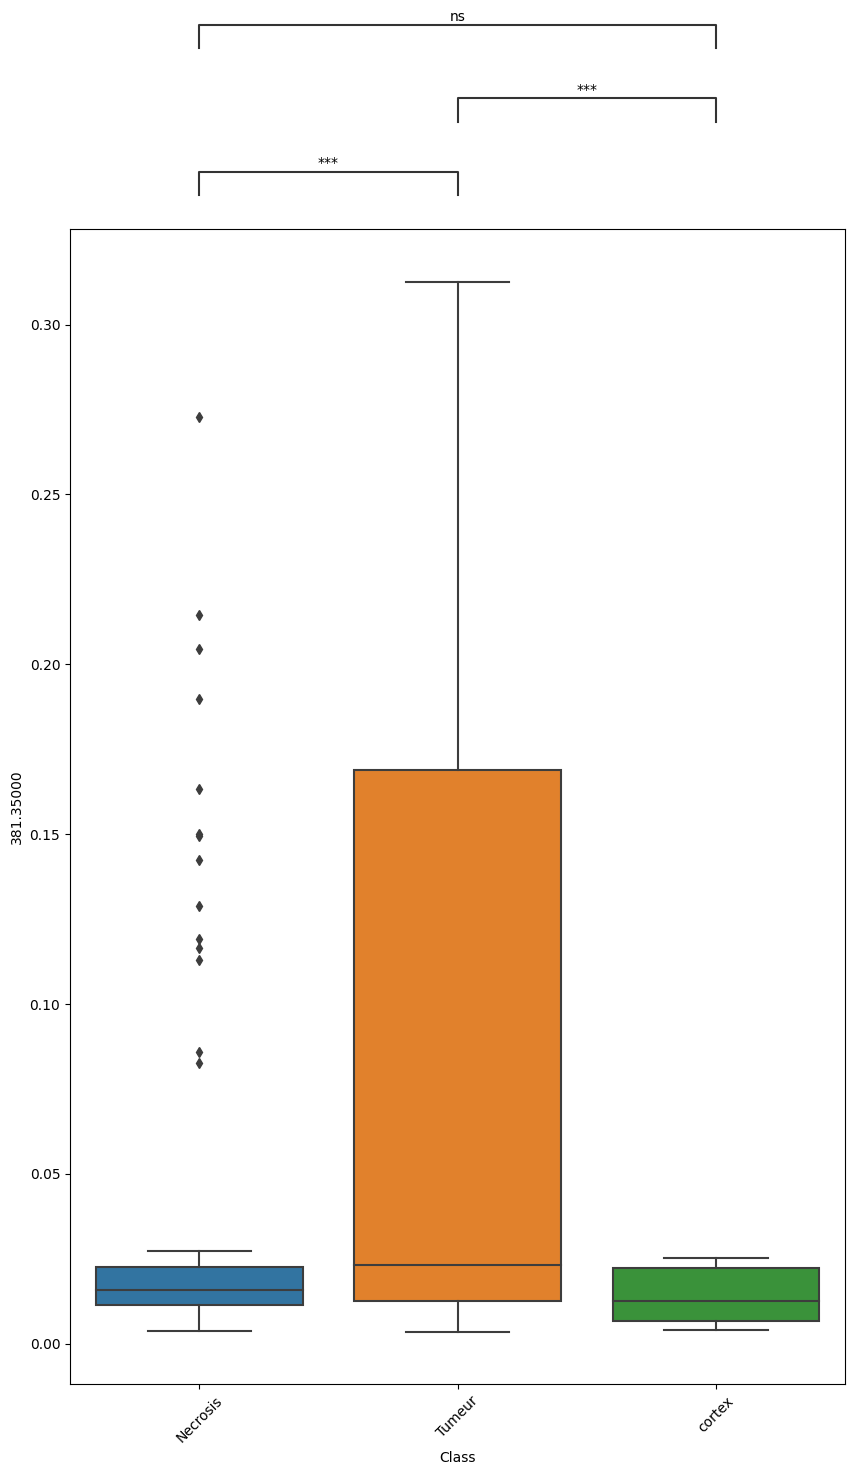

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=4.010e-03 stat=1.029e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.994e-03 stat=1.083e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=6.850e-01 stat=1.451e+00


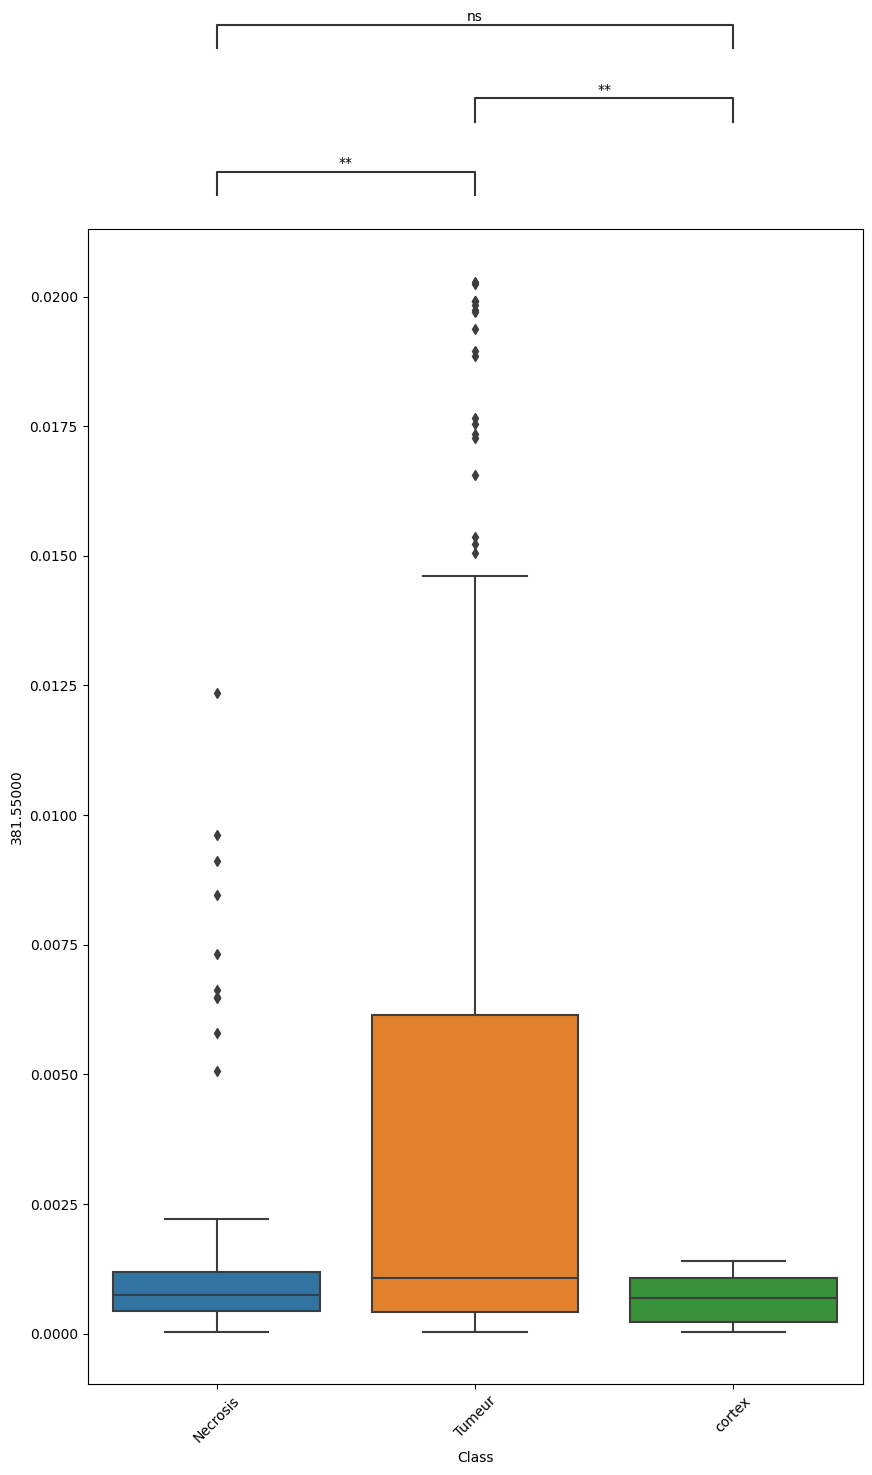

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.368e-01 stat=2.522e+00
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=7.313e-01 stat=1.359e+00
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=5.009e-01


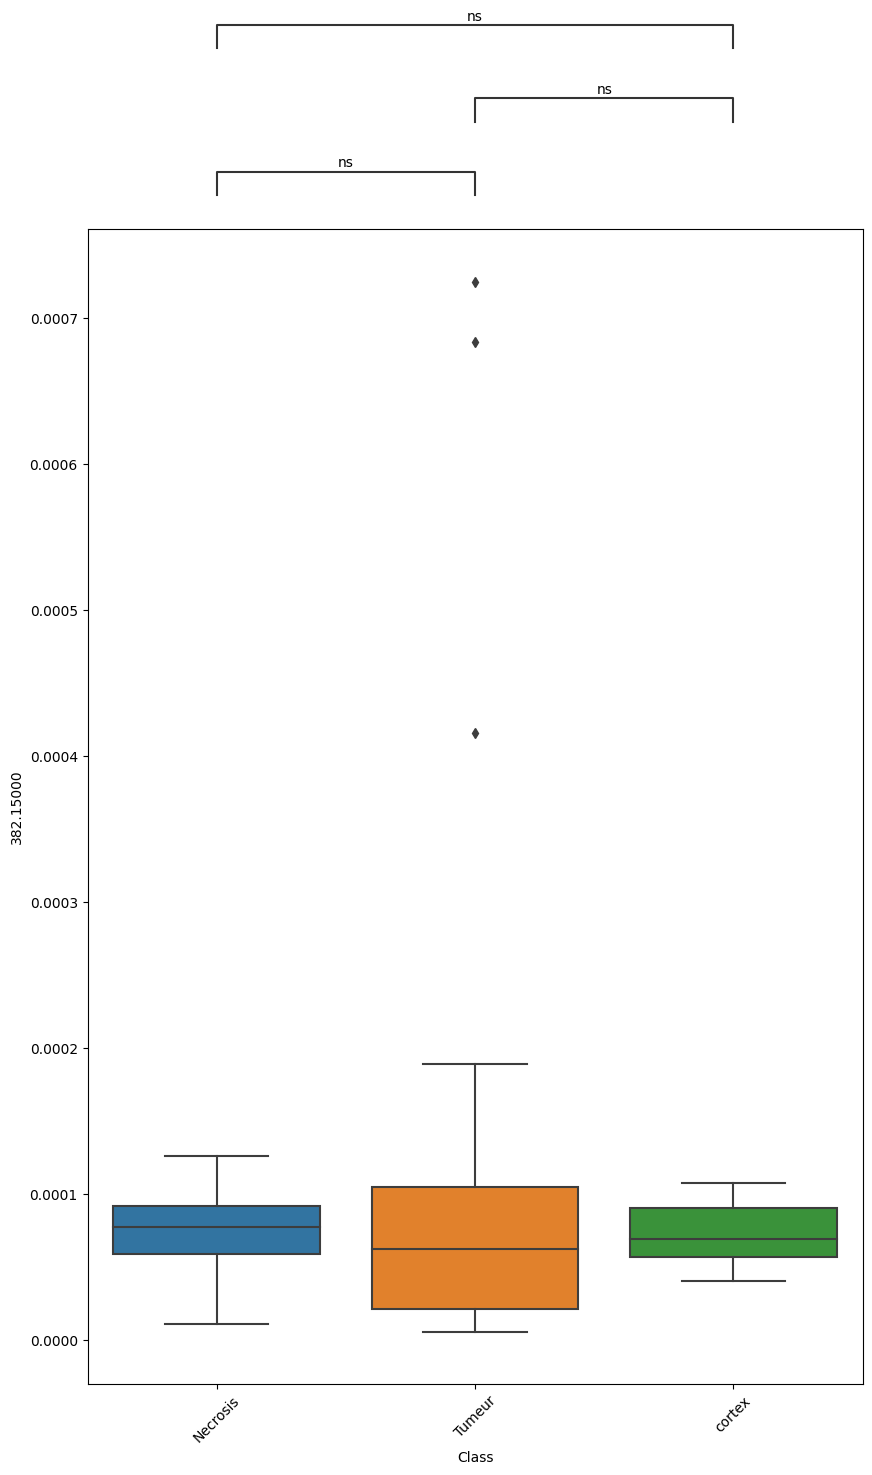

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=5.719e-05 stat=1.828e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=7.518e-05 stat=1.776e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.960e-01 stat=2.727e+00


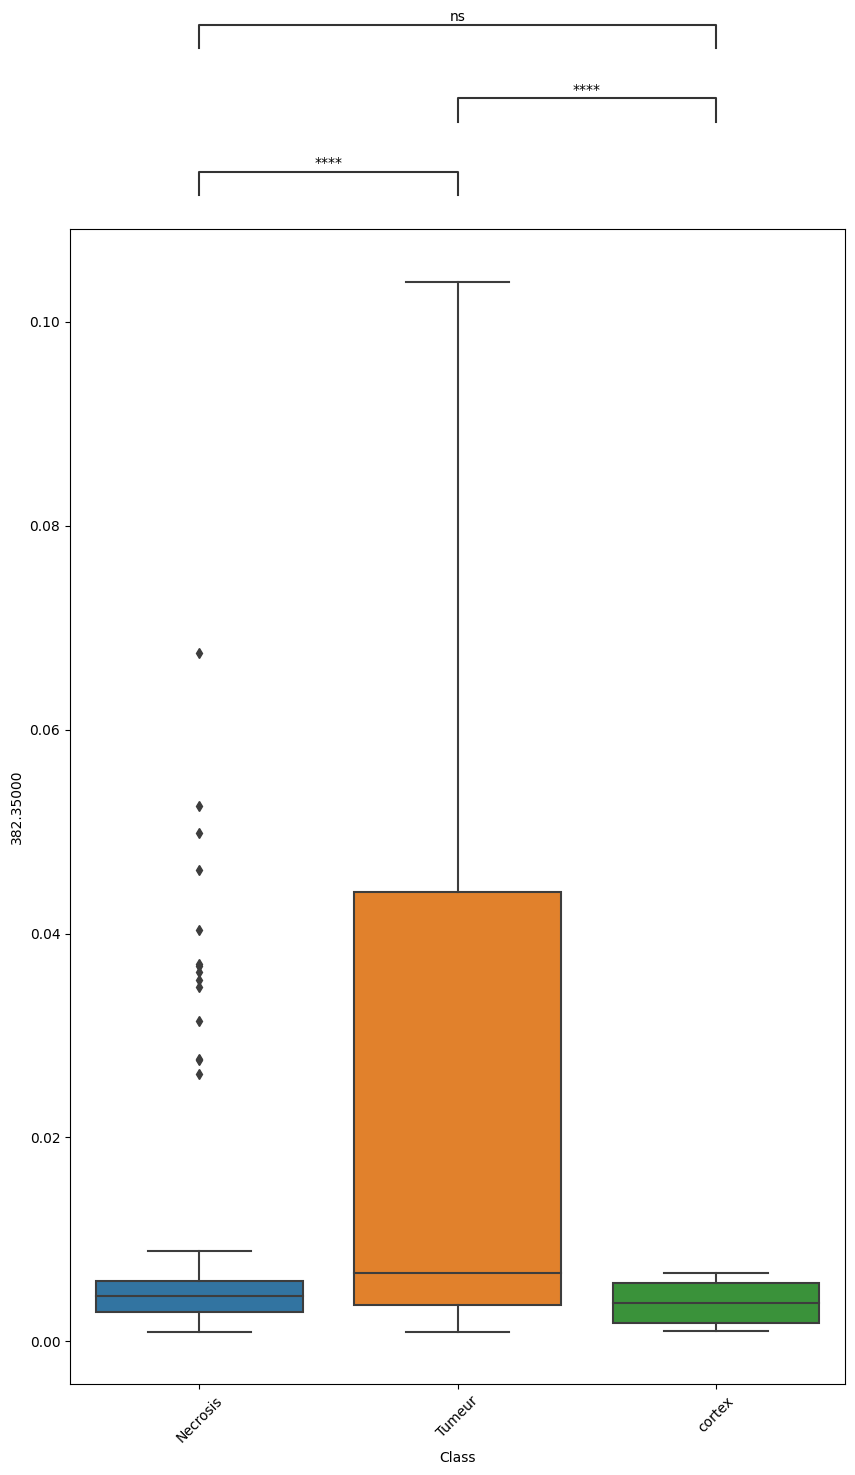

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=5.616e-01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=5.996e-04
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=4.128e-01


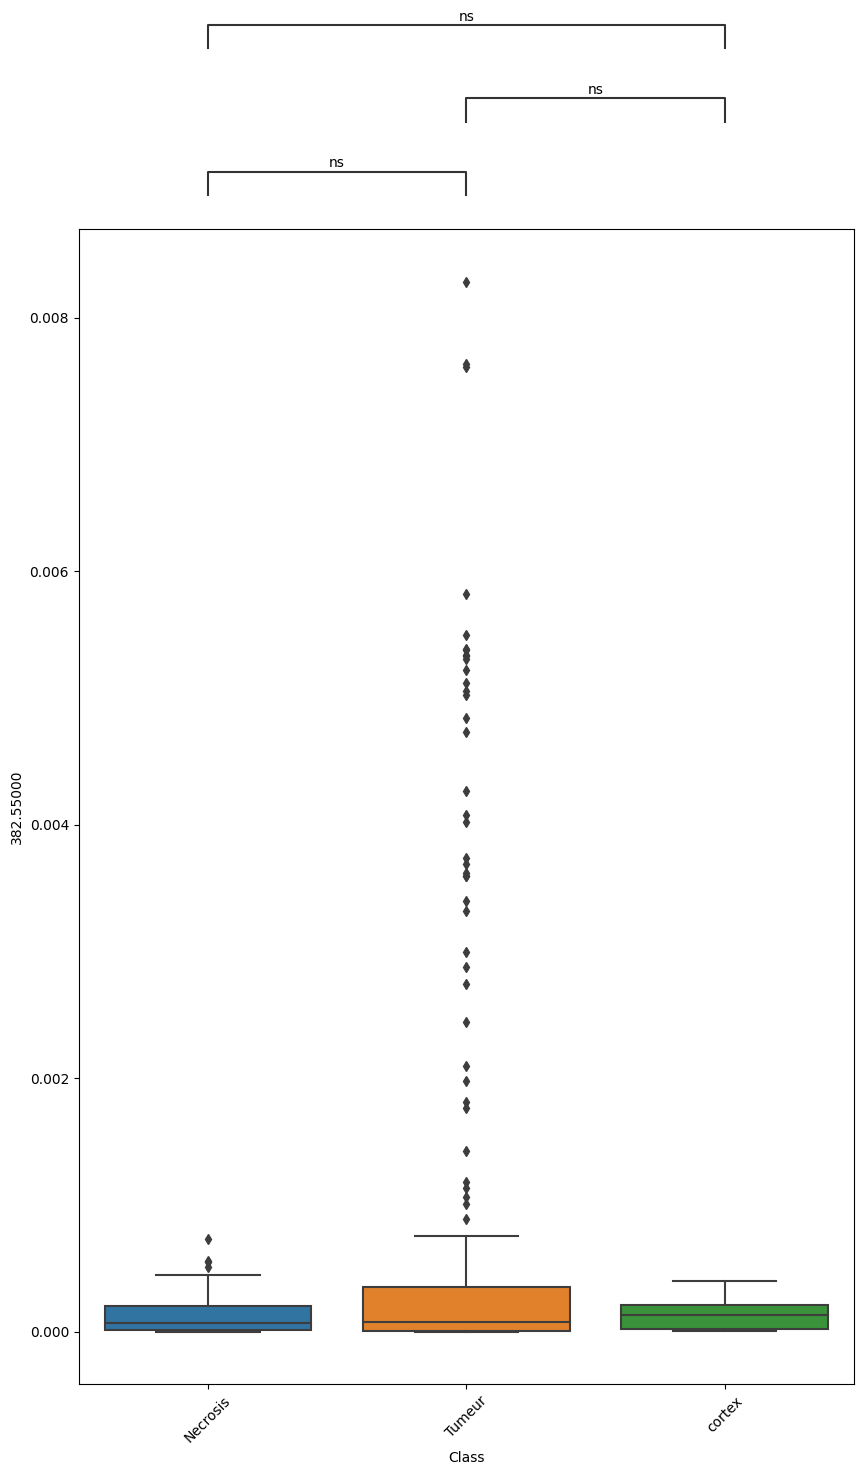

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=5.551e-05 stat=1.834e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.634e-02 stat=7.725e+00
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=3.628e-01


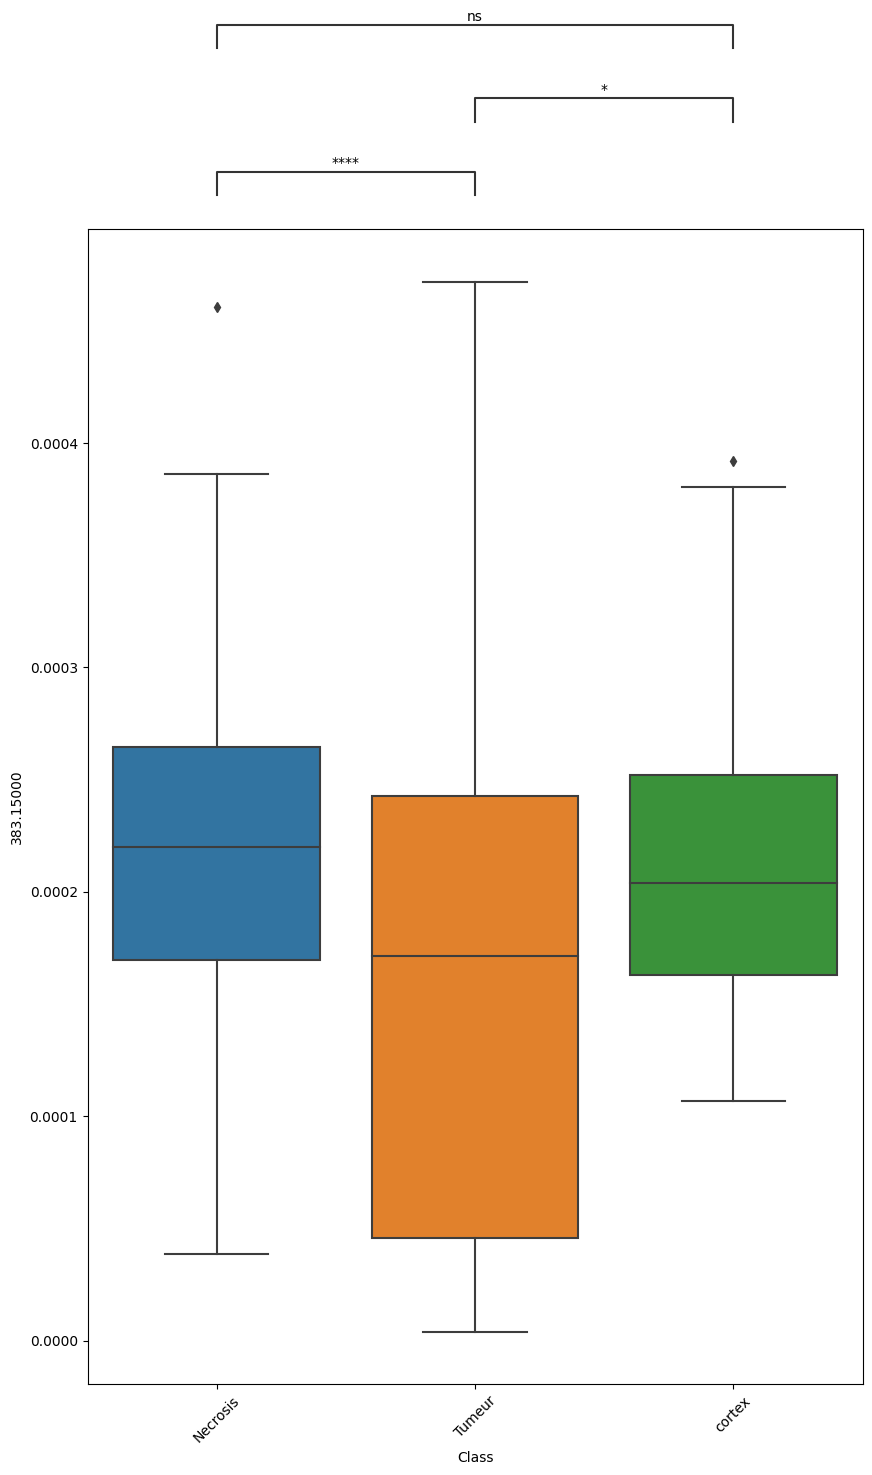

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.545e-03 stat=1.206e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.027e-04 stat=1.717e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.898e-01 stat=3.449e+00


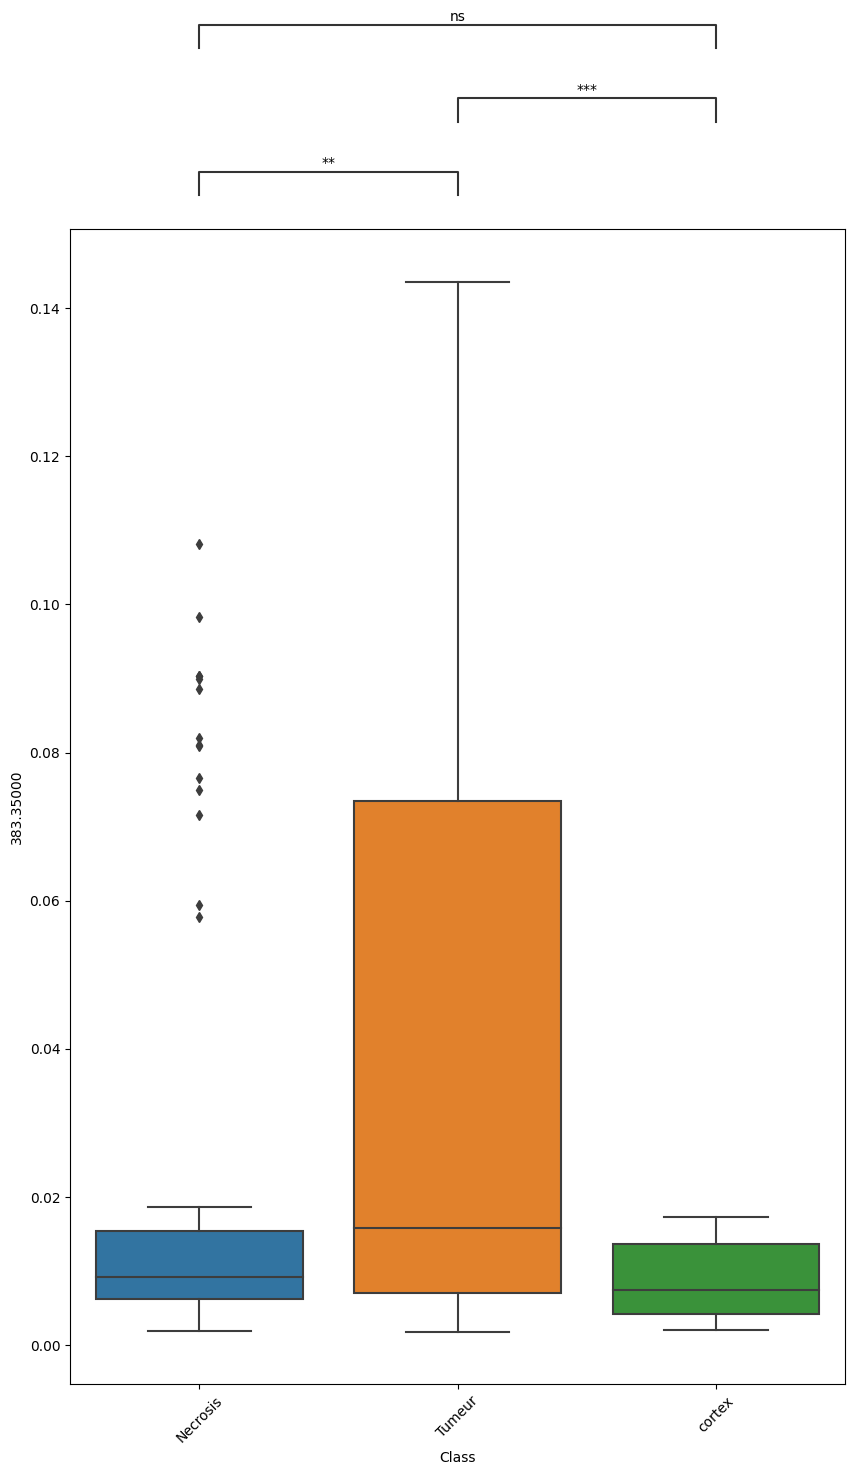

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.459e-01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=6.140e-03
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=3.332e-01


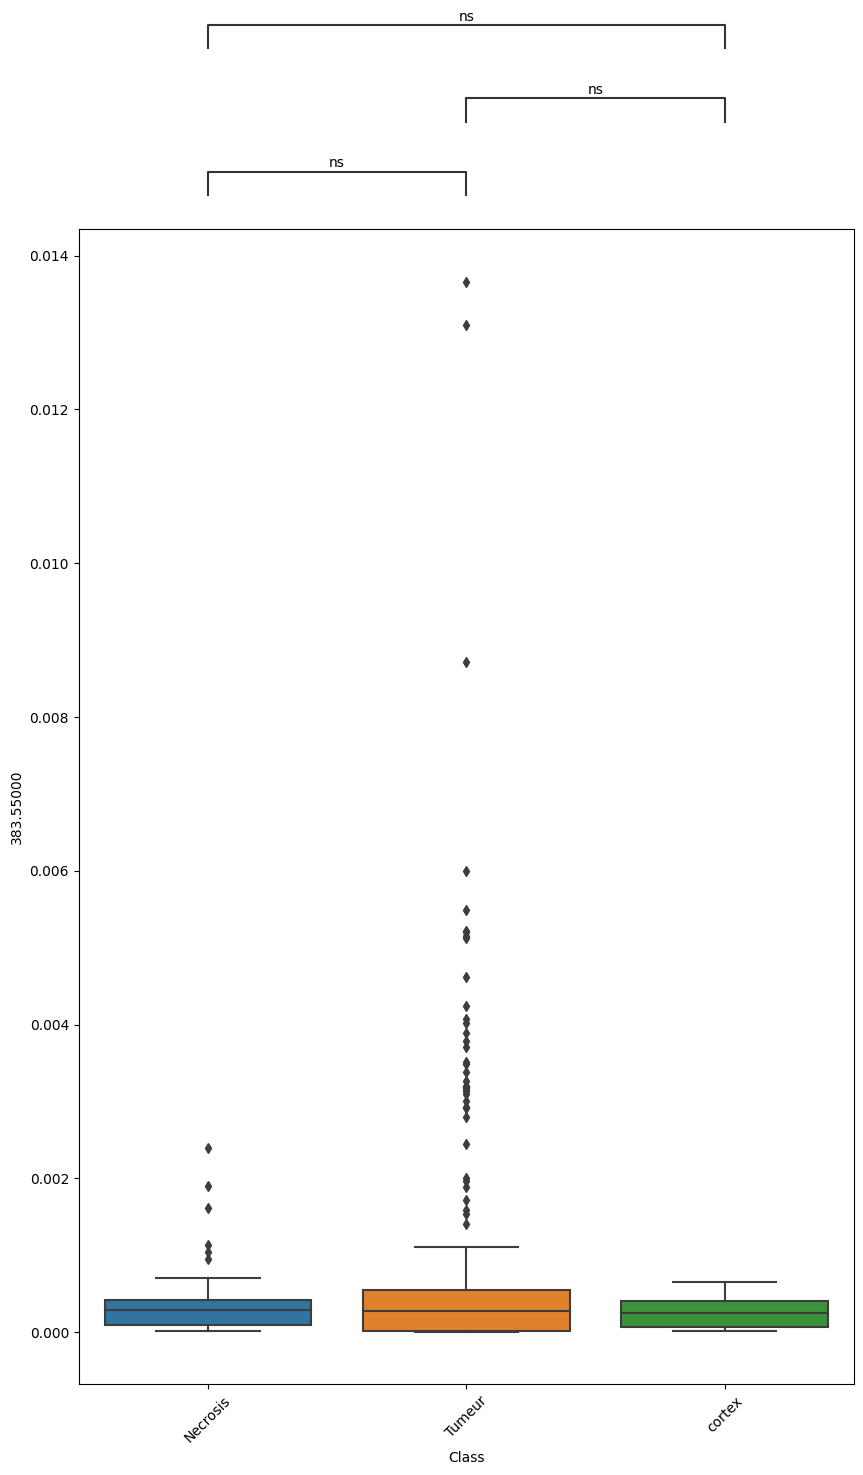

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.002e-03 stat=1.287e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.472e-04 stat=1.648e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.990e-01 stat=2.711e+00


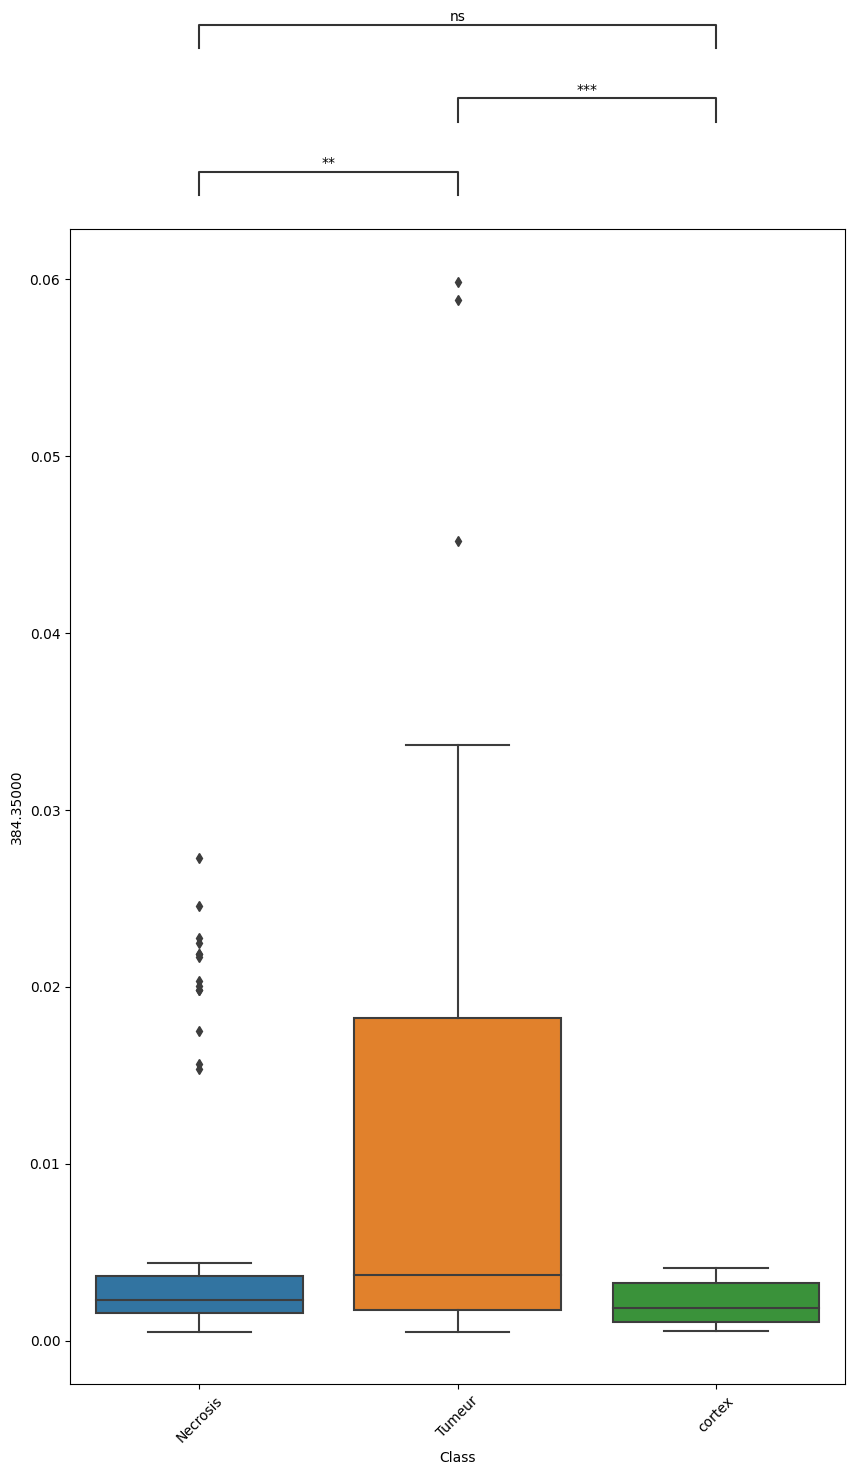

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=8.704e-05 stat=1.748e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.084e-04 stat=1.707e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=7.449e-01 stat=1.333e+00


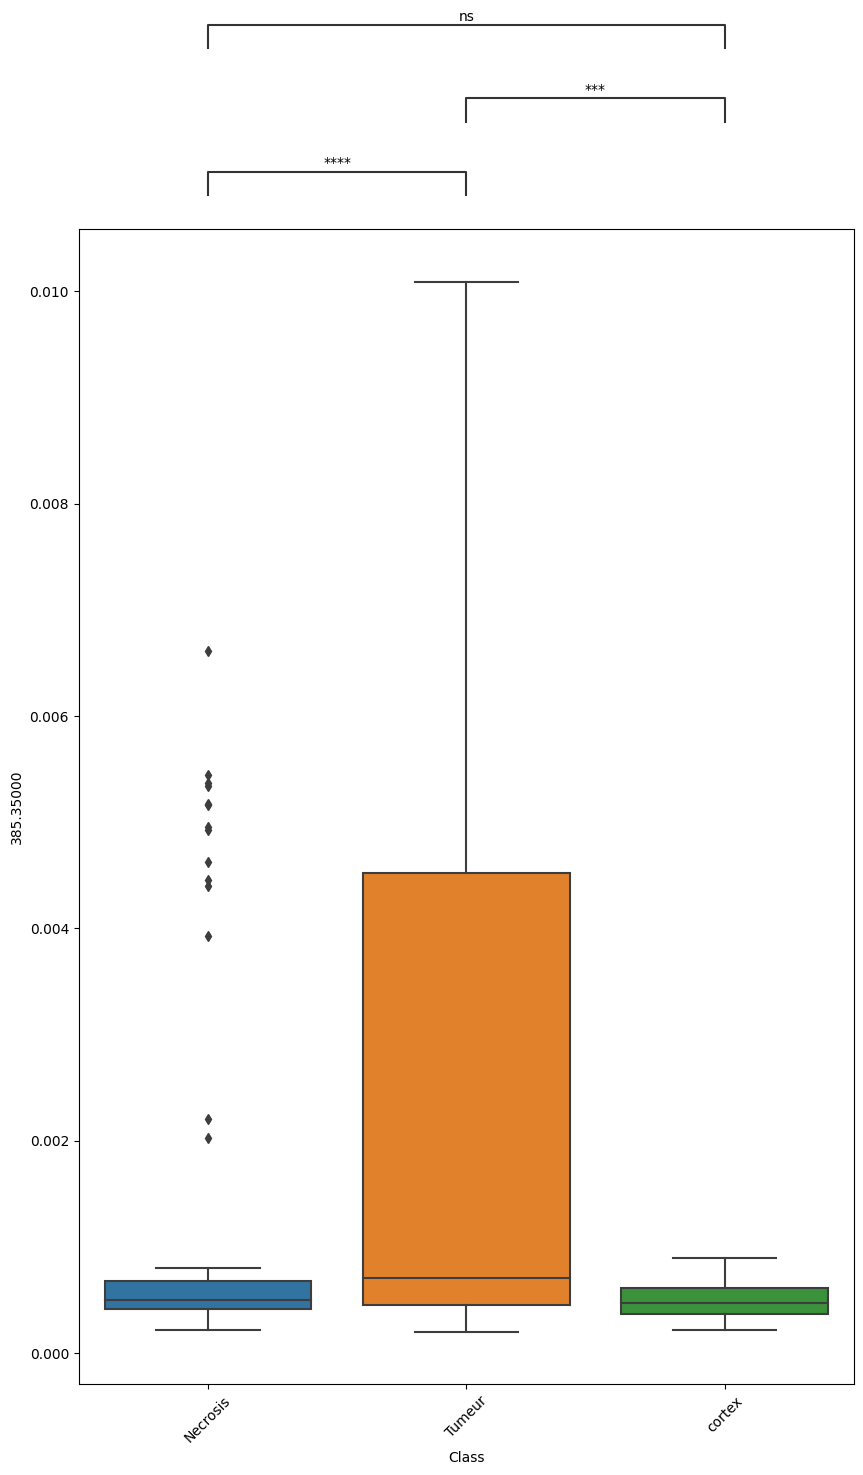

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=4.572e-02 stat=5.889e+00
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.771e-06 stat=2.408e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.112e-05 stat=2.018e+01


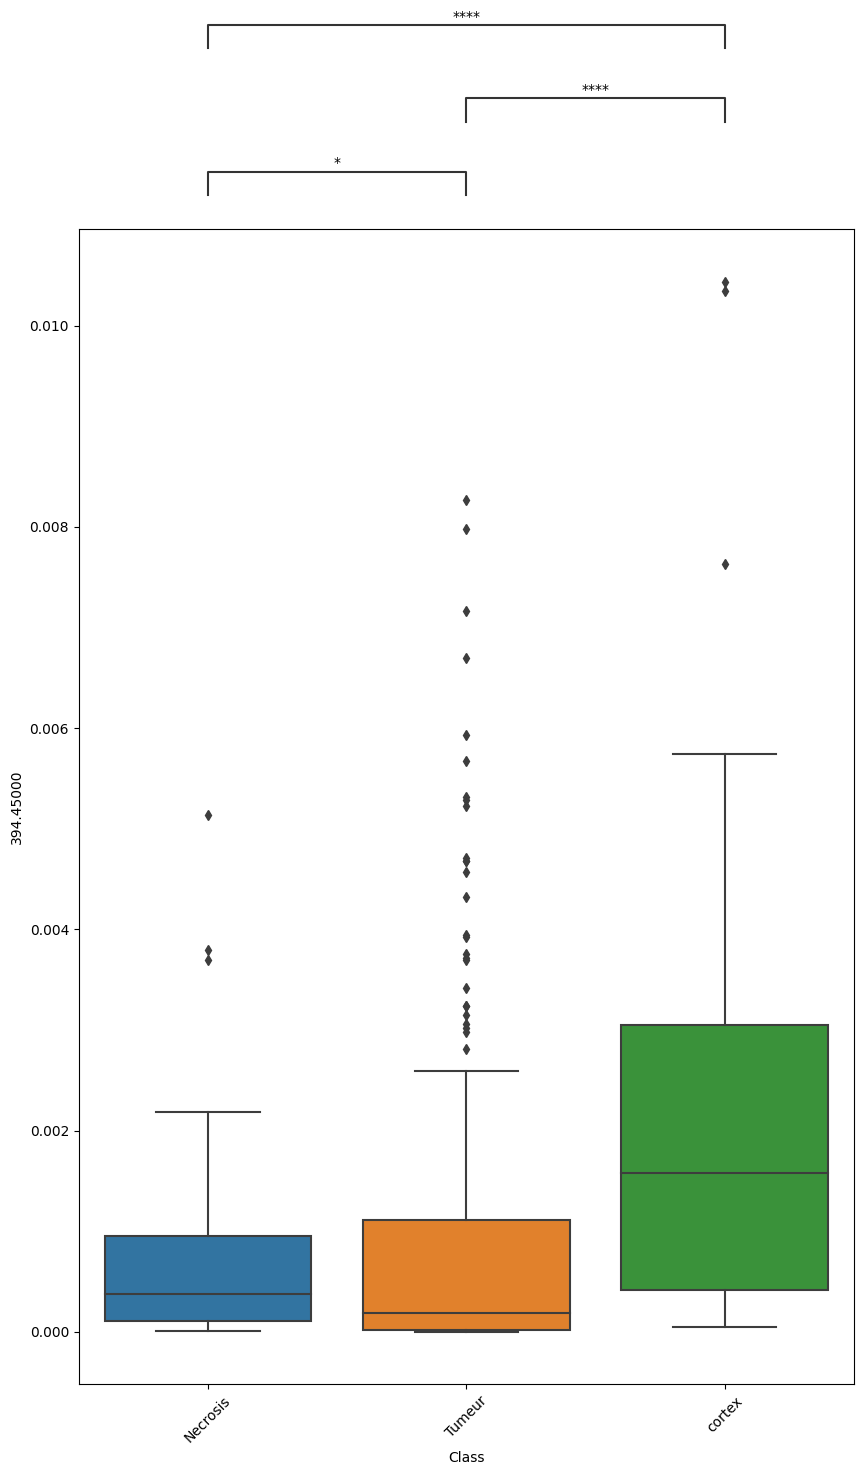

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=9.328e-04 stat=1.300e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.355e-06 stat=2.439e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=8.889e-03 stat=8.830e+00


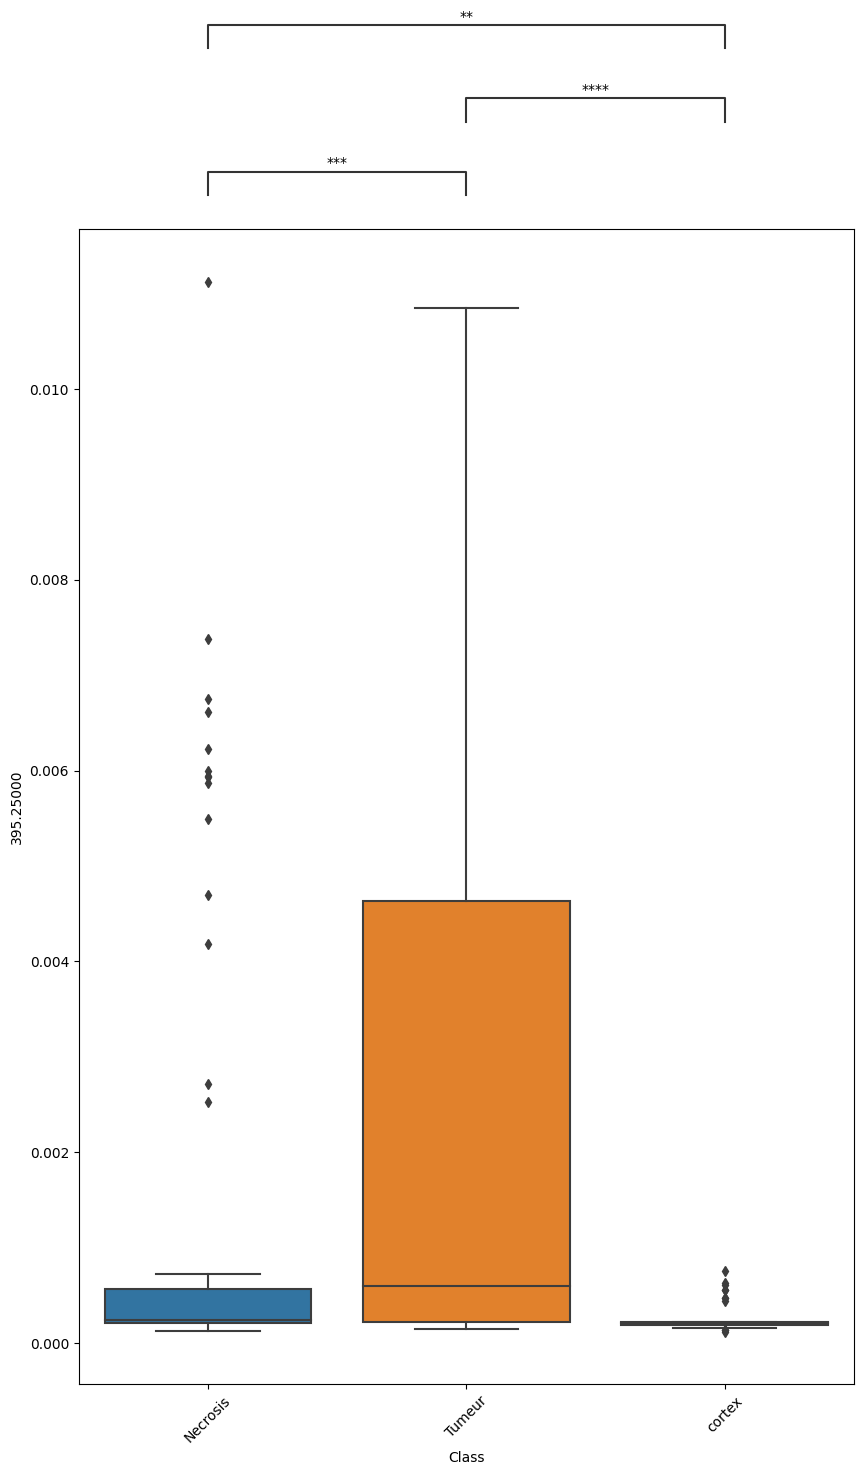

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.954e-04 stat=1.595e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.306e-05 stat=2.110e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=8.373e-02 stat=4.834e+00


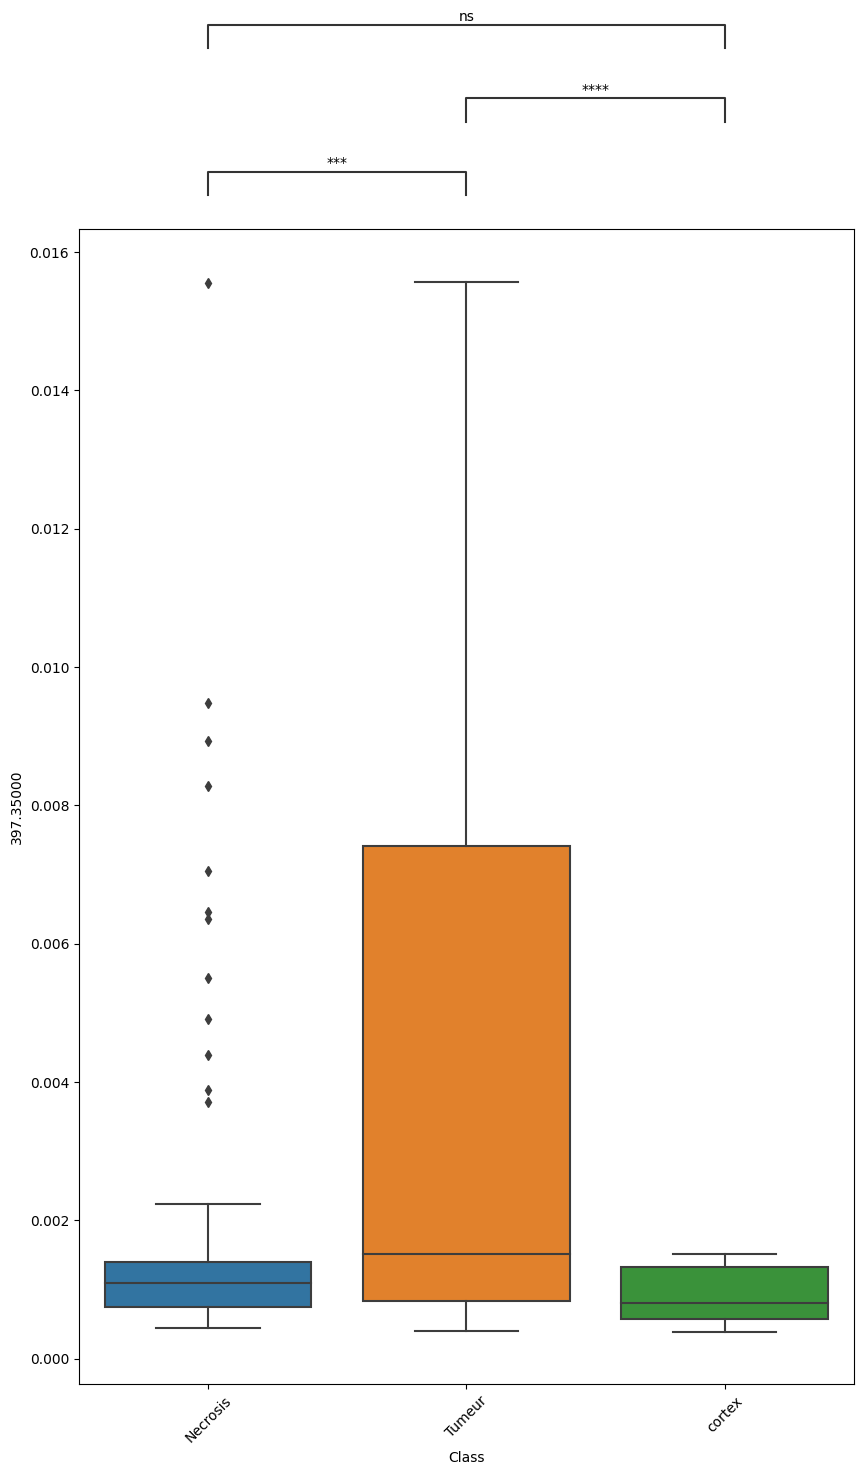

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.888e-05 stat=1.902e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.485e-05 stat=2.086e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.076e-01 stat=3.302e+00


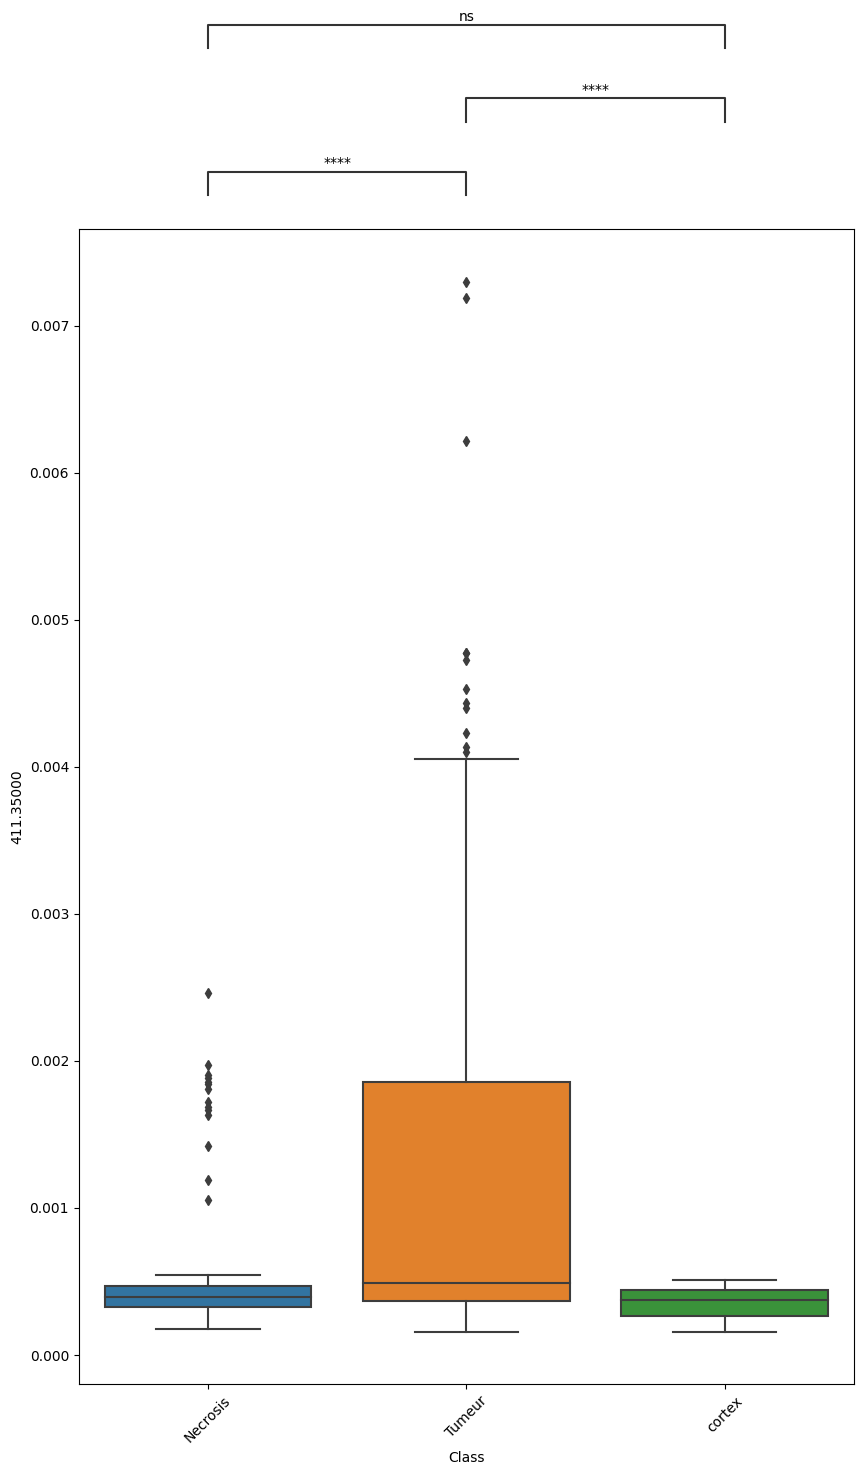

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.312e-02 stat=8.122e+00
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=9.351e-02 stat=4.644e+00
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.975e-02


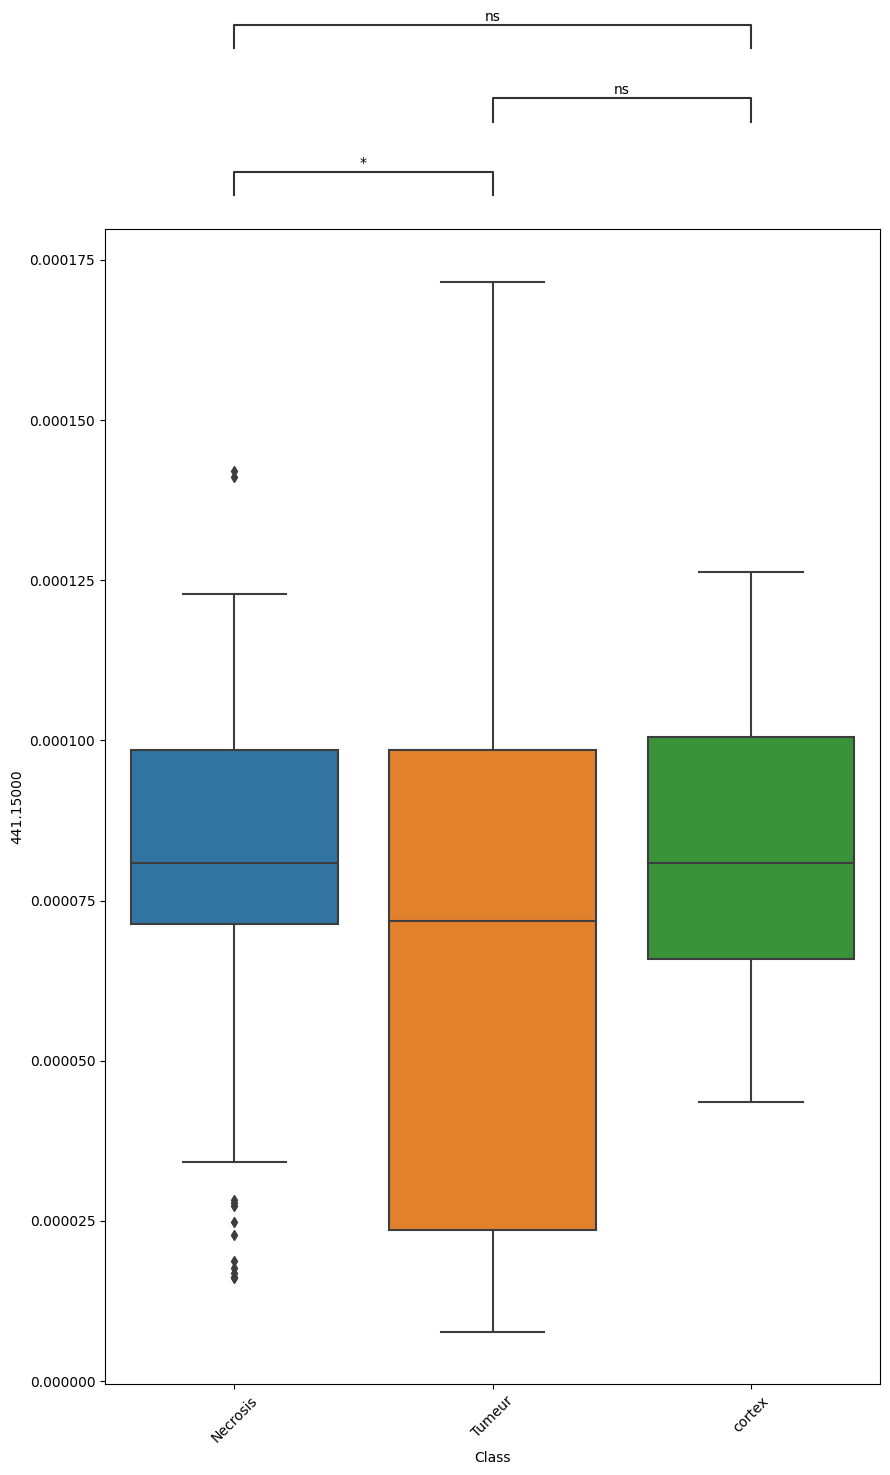

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.329e-04 stat=1.668e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.752e-05 stat=1.908e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.232e-01 stat=4.174e+00


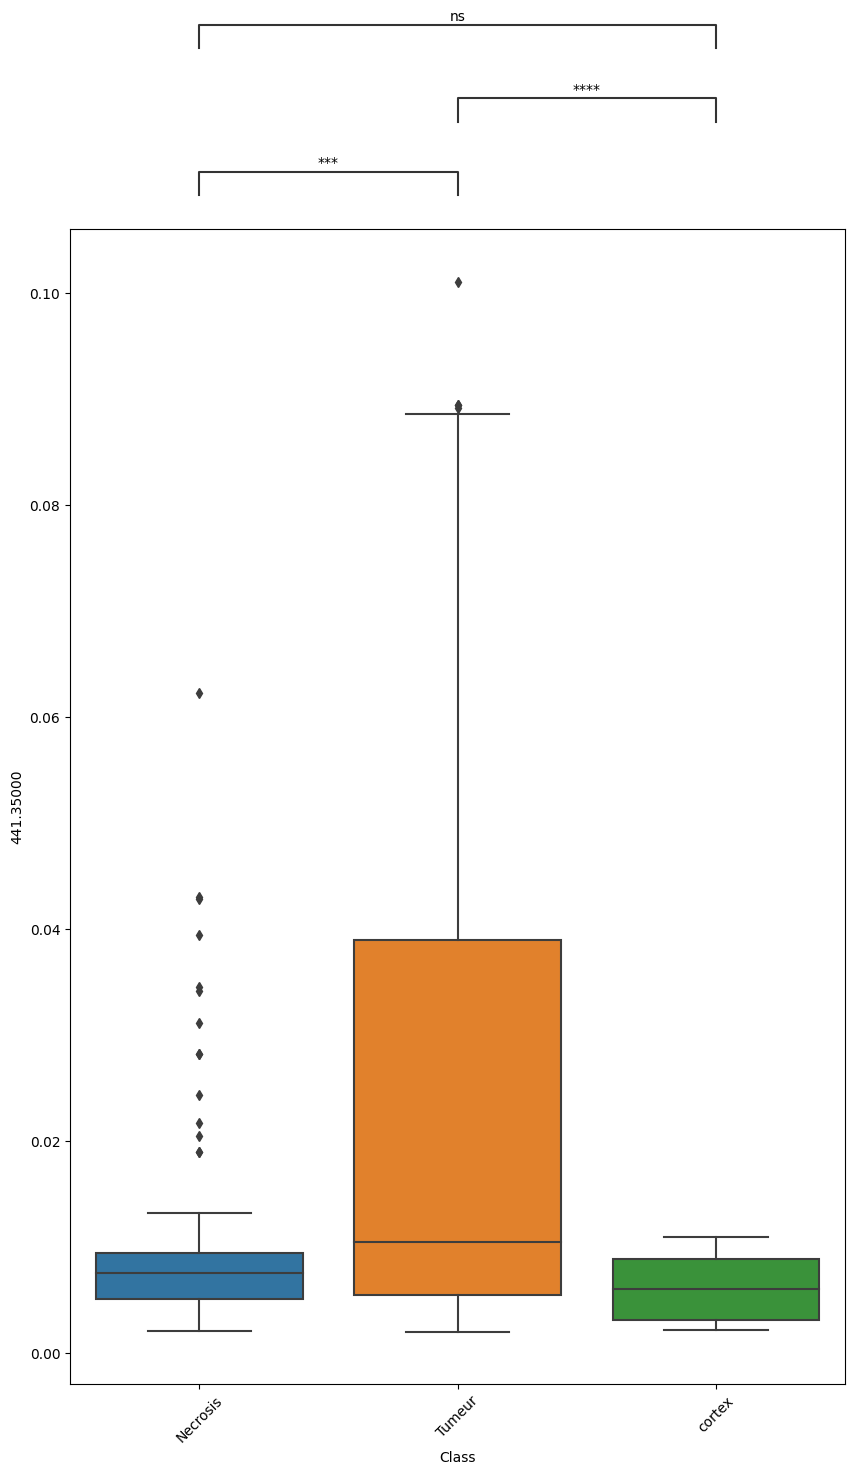

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=5.797e-01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.723e-01 stat=2.365e+00
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=6.777e-01


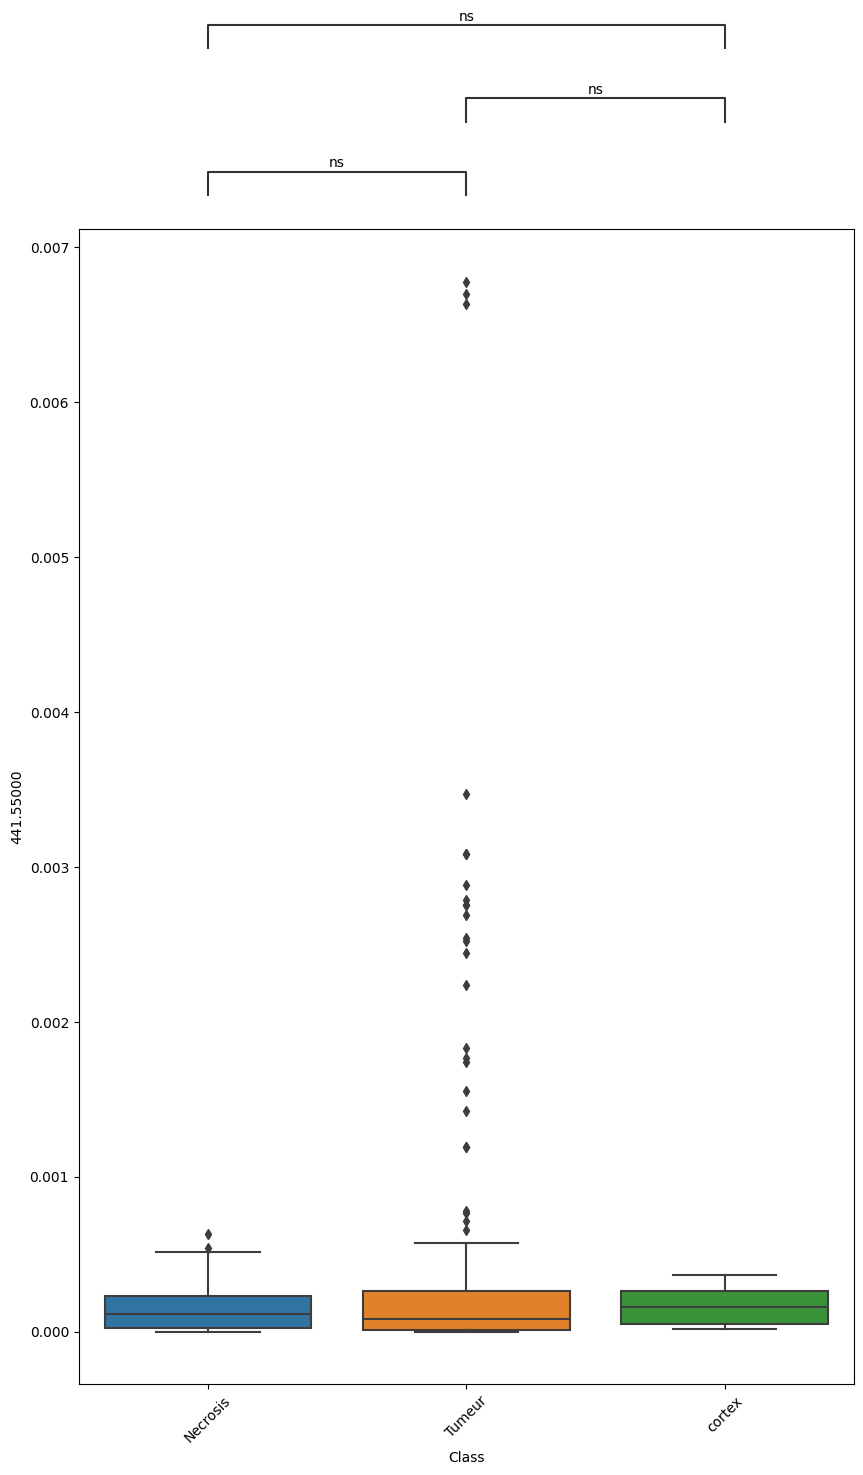

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.352e-04 stat=1.665e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.863e-05 stat=1.960e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.293e-01 stat=4.092e+00


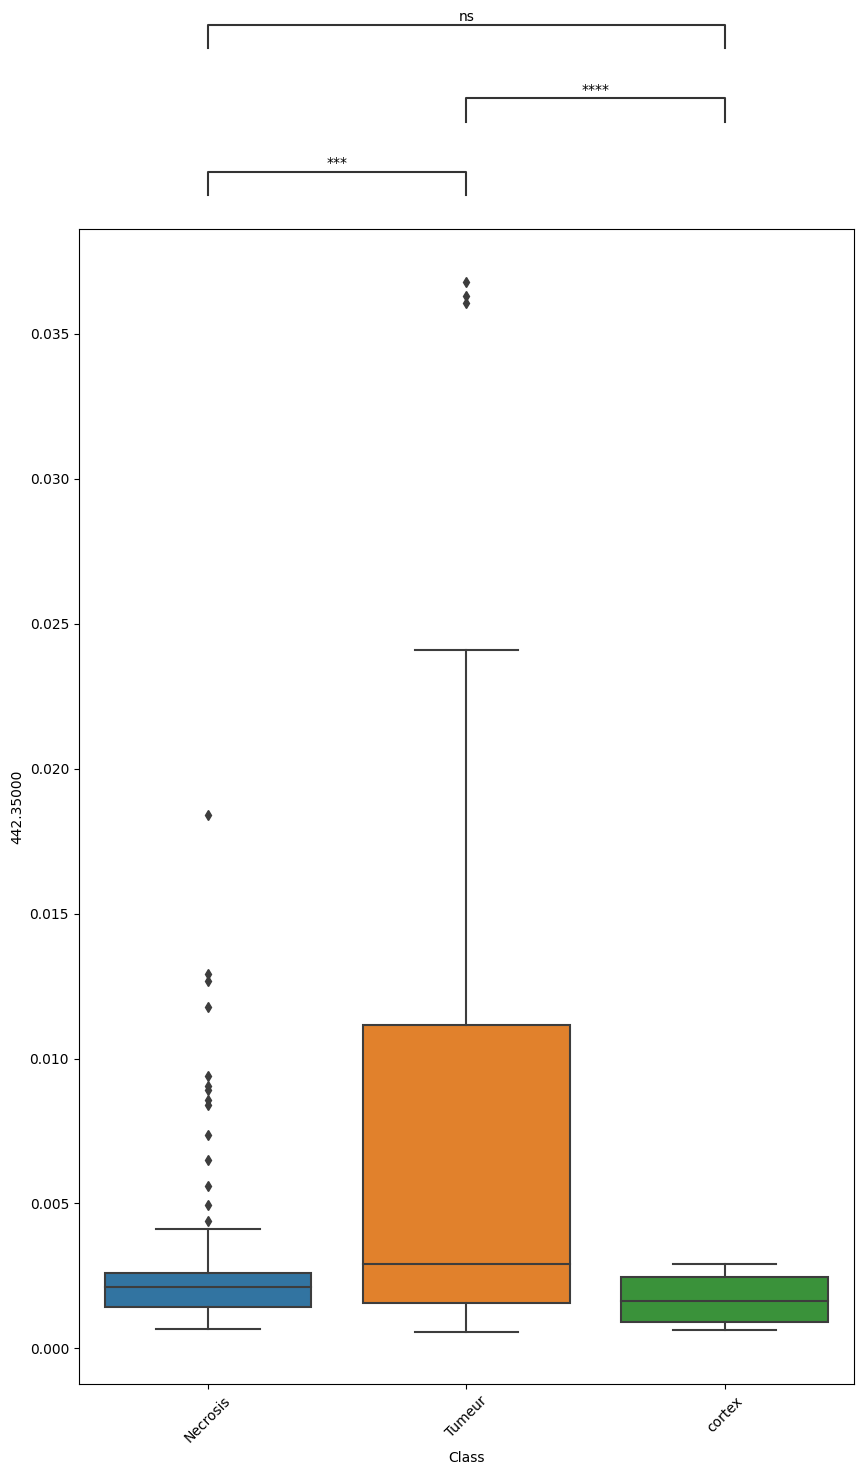

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.947e-04 stat=1.517e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.103e-05 stat=2.019e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=6.201e-02 stat=5.355e+00


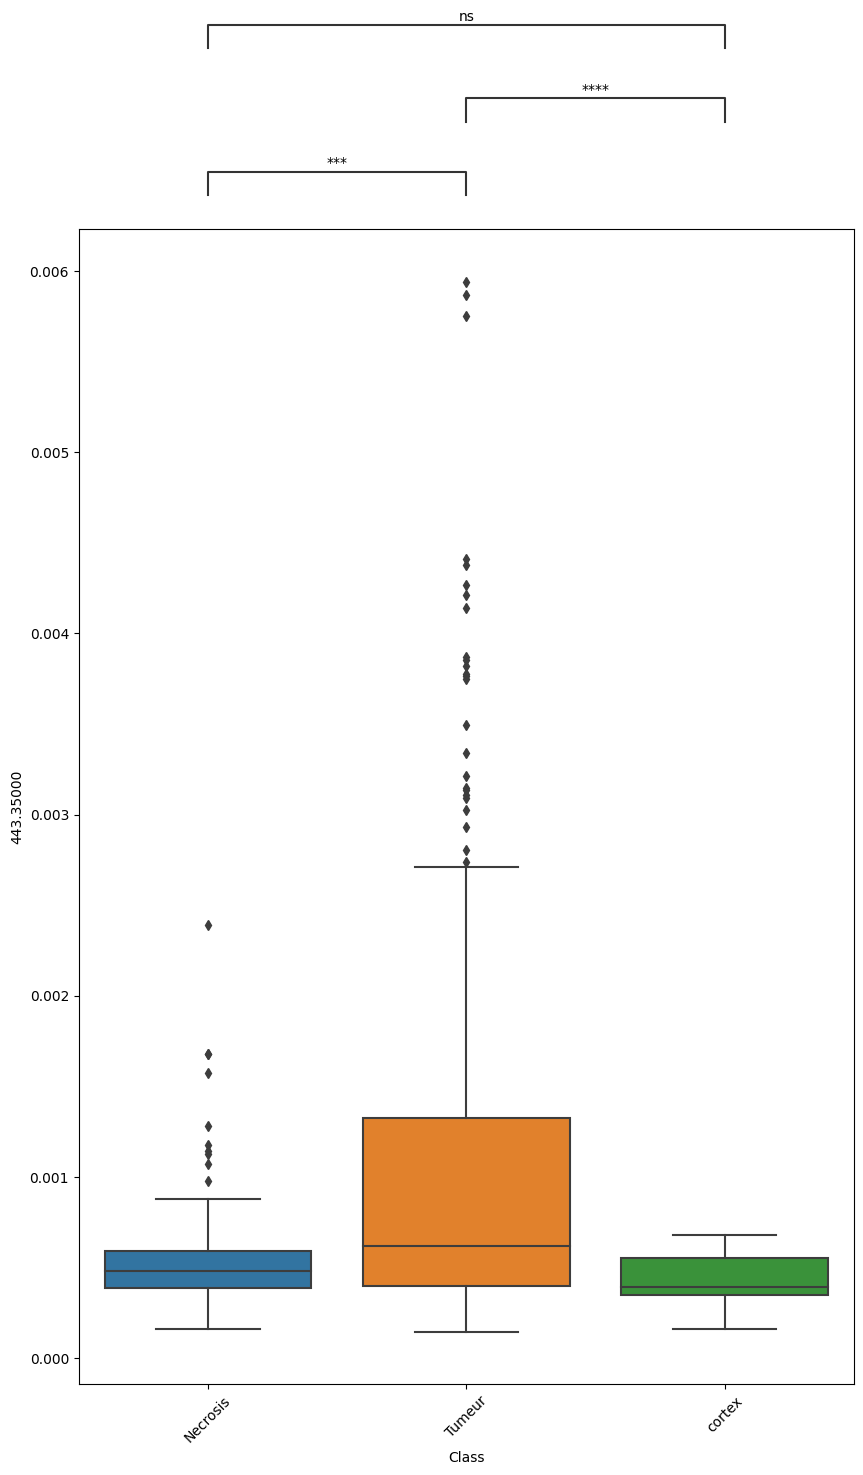

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.368e-02 stat=8.046e+00
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=8.198e-05 stat=1.760e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=4.352e-02 stat=5.976e+00


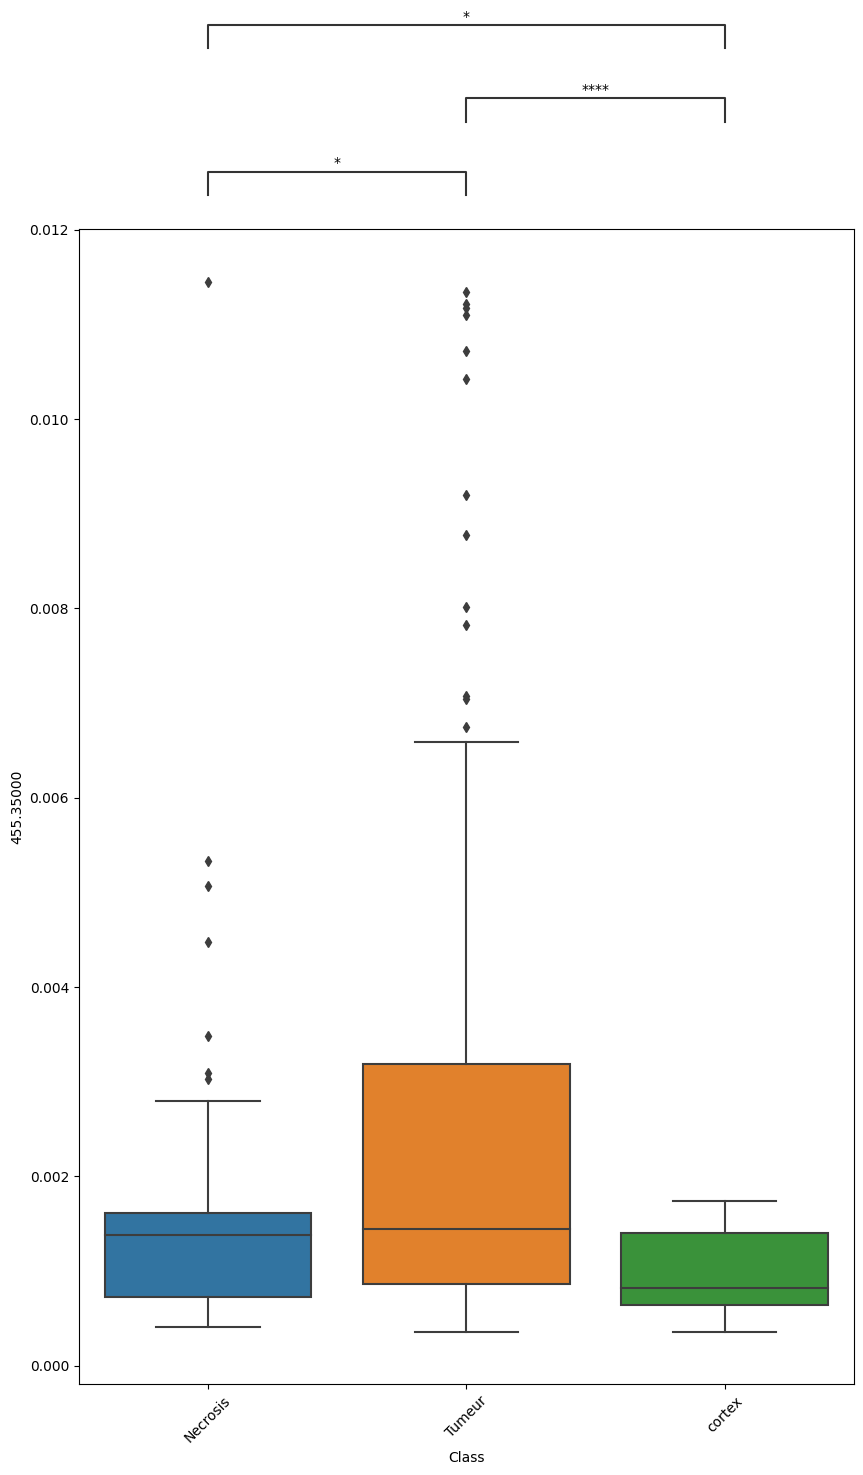

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=9.391e-05 stat=1.734e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=7.009e-03 stat=9.265e+00
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.219e-02


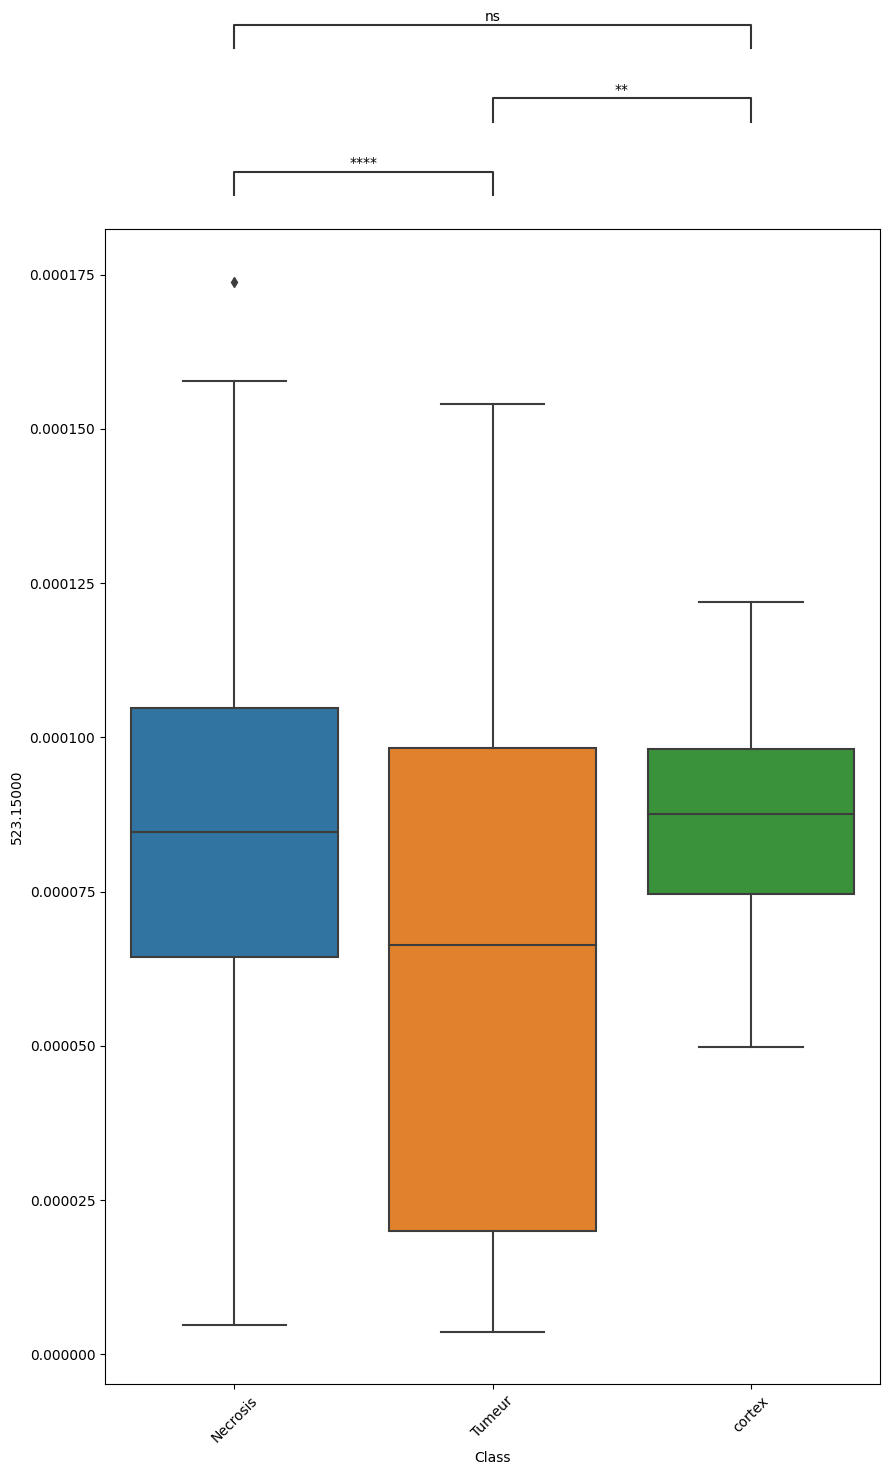

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.298e-04 stat=1.672e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=7.766e-05 stat=1.770e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.637e-01 stat=2.913e+00


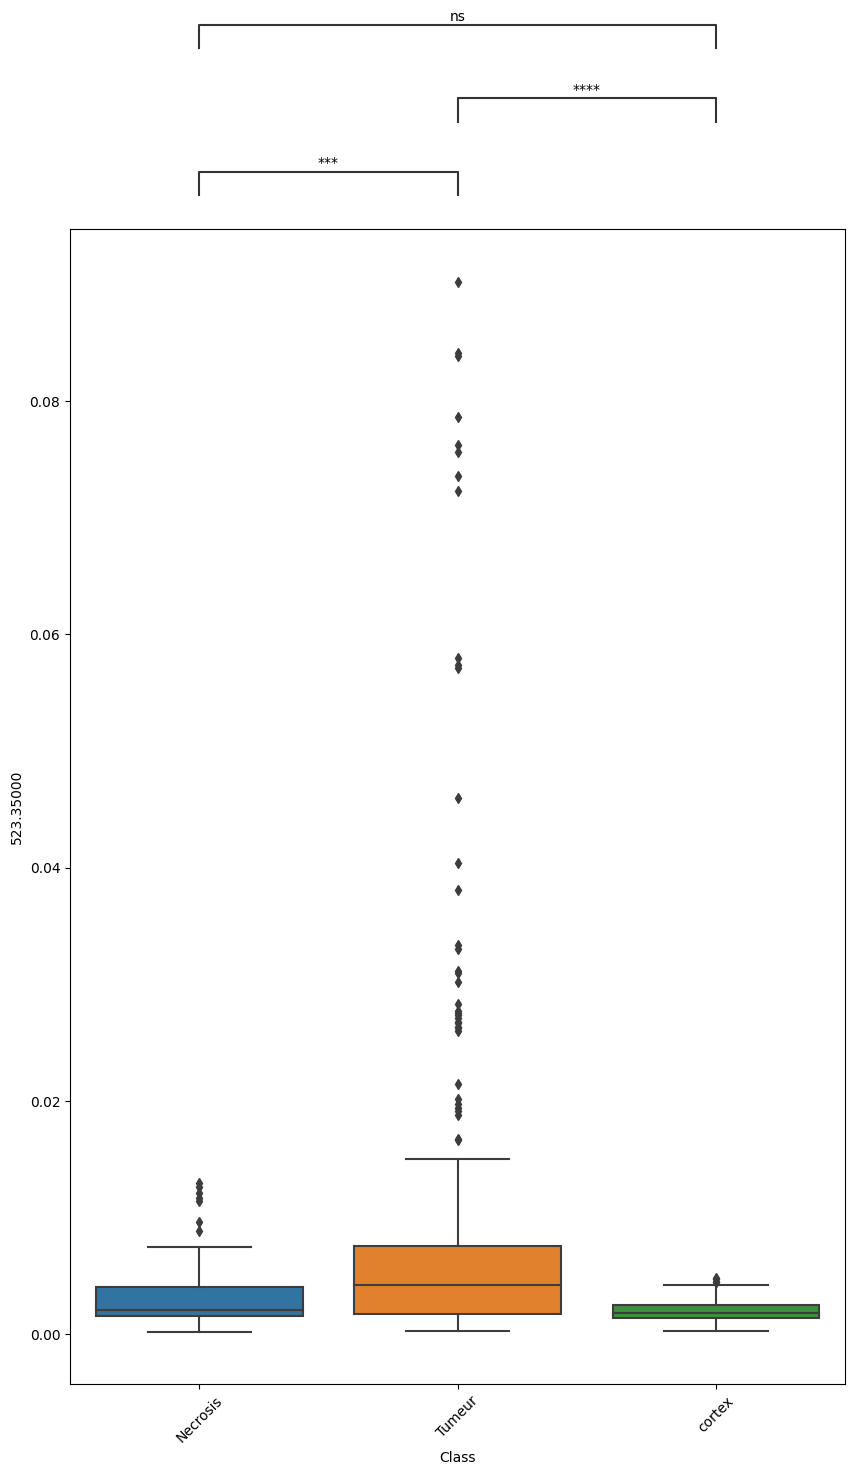

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=2.072e-01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=9.293e-04 stat=1.301e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=4.017e-03 stat=1.029e+01


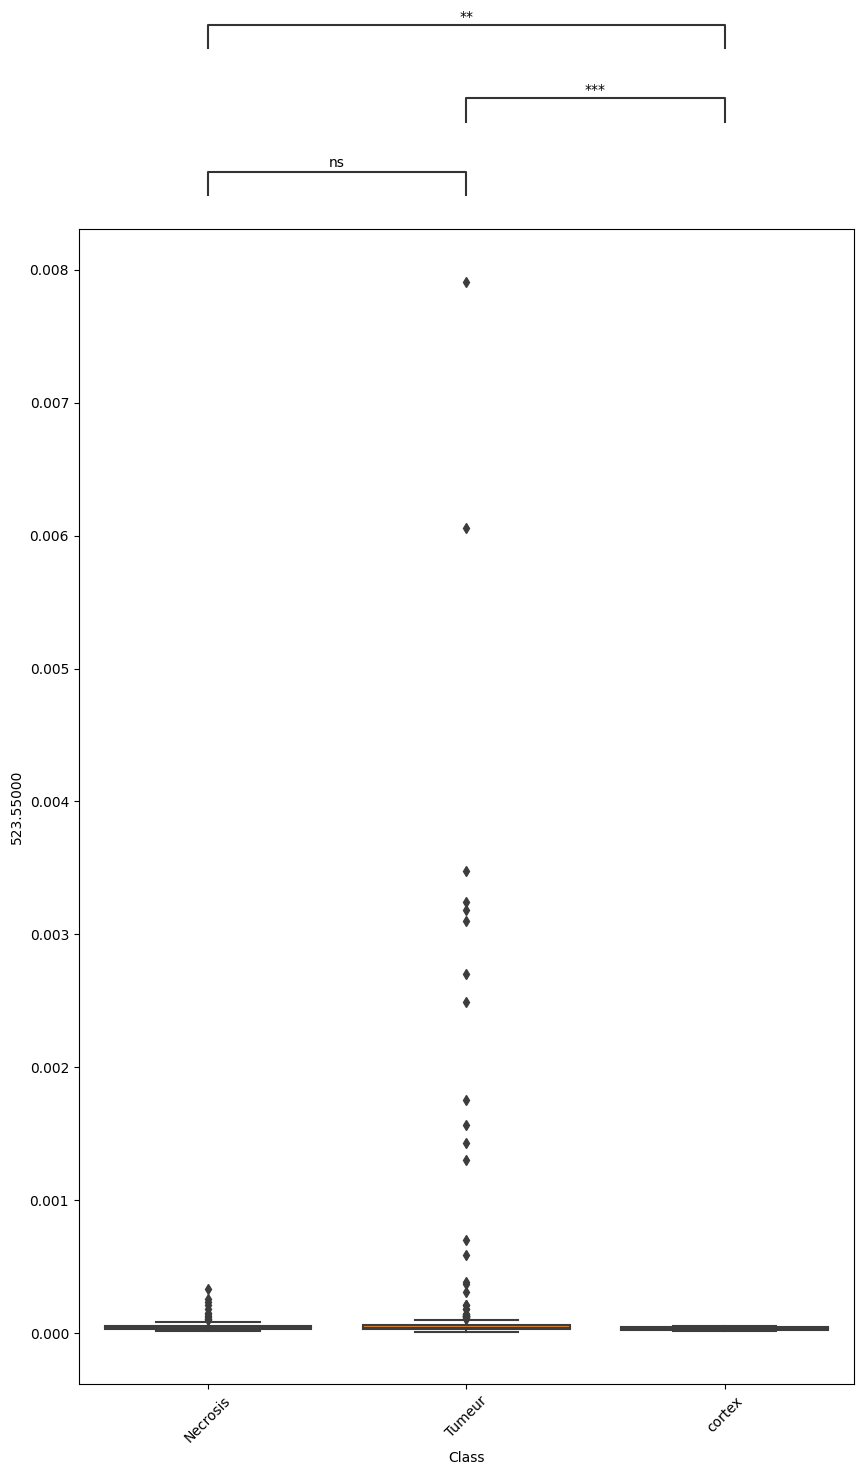

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.722e-06 stat=2.500e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.257e-04 stat=1.678e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=6.777e-01


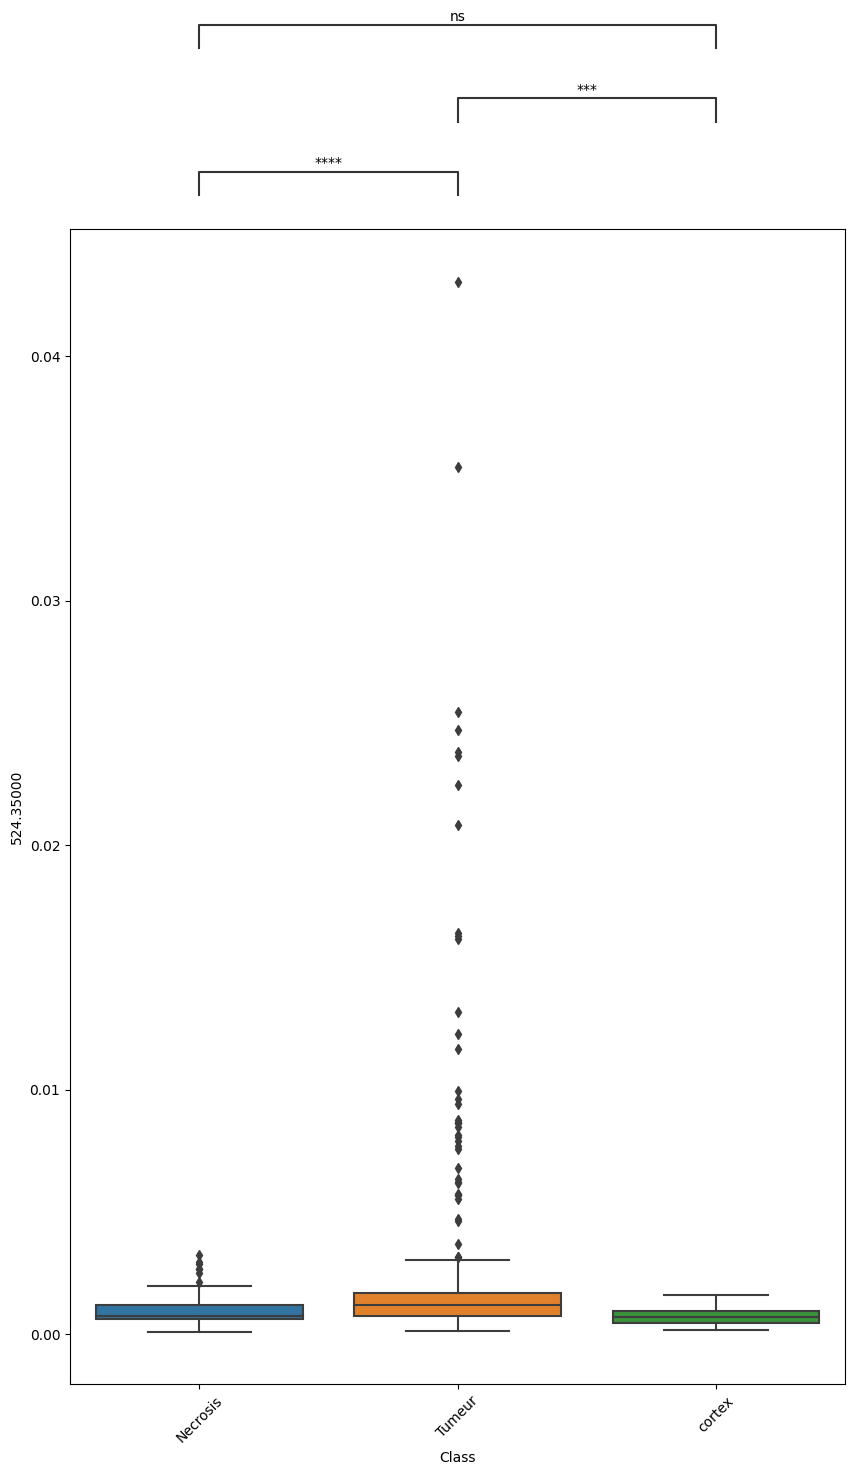

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.383e-06 stat=2.370e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=4.829e-04 stat=1.424e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=7.077e-02


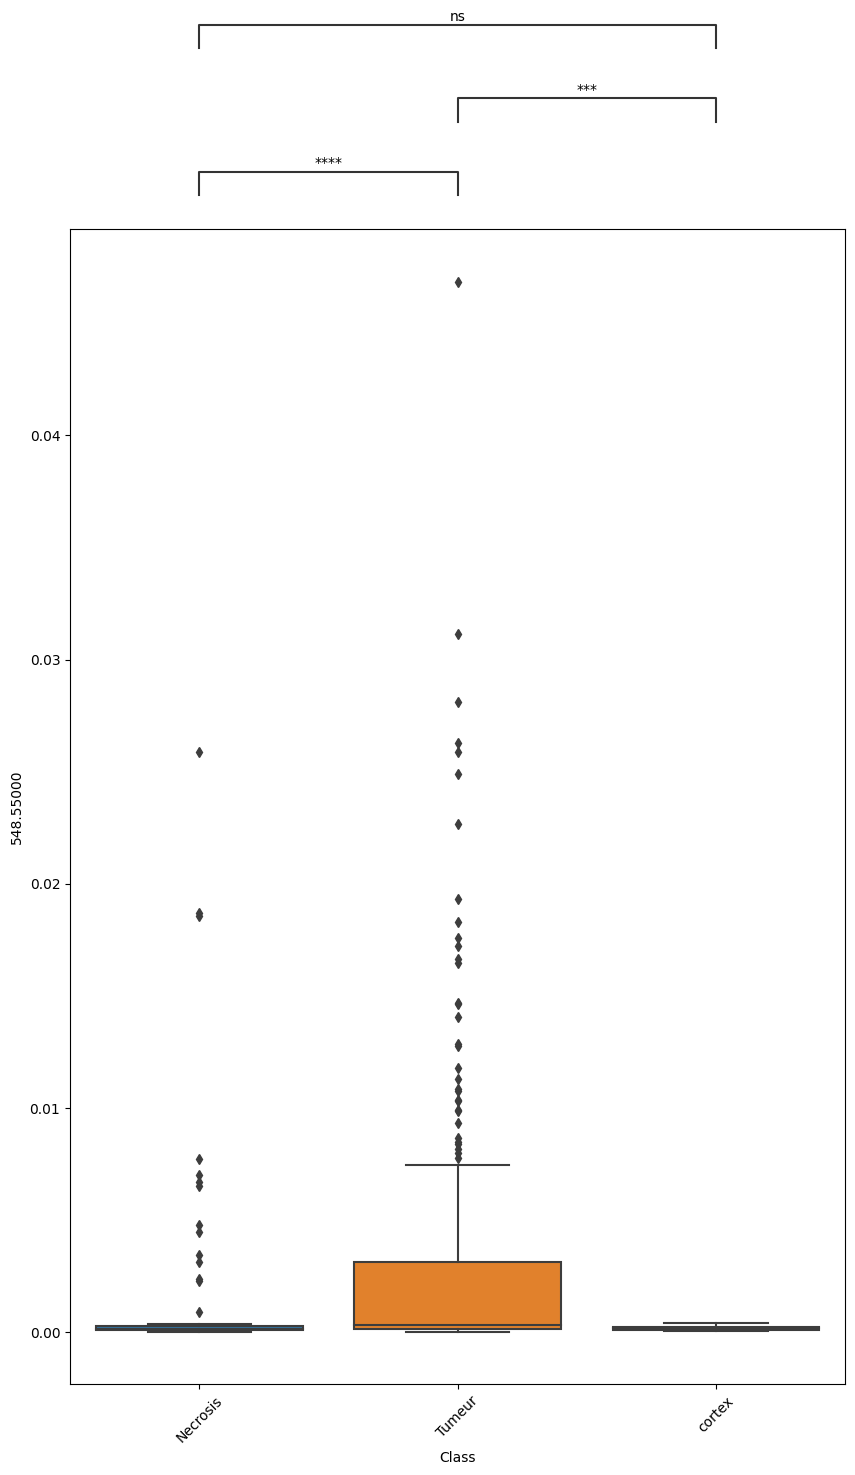

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=8.305e-05 stat=1.757e+01
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.279e-05 stat=1.934e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.500e-01 stat=2.999e+00


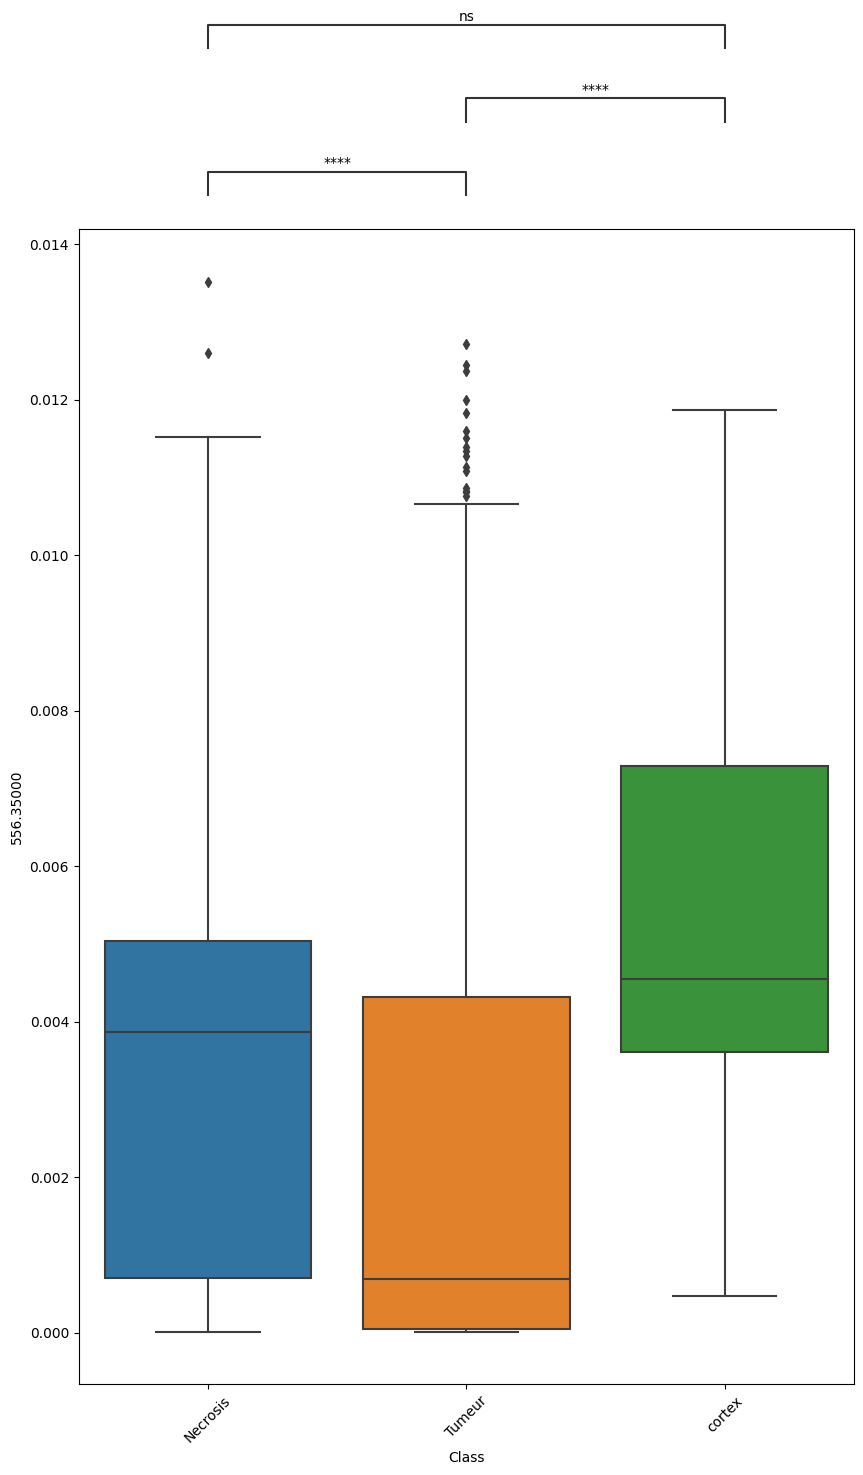

<Figure size 1500x1500 with 0 Axes>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Necrosis v.s. Tumeur: Kruskal-Wallis paired samples with Bonferroni correction, P_val=9.504e-02 stat=4.616e+00
Tumeur v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.674e-06 stat=2.505e+01
Necrosis v.s. cortex: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.767e-04 stat=1.529e+01


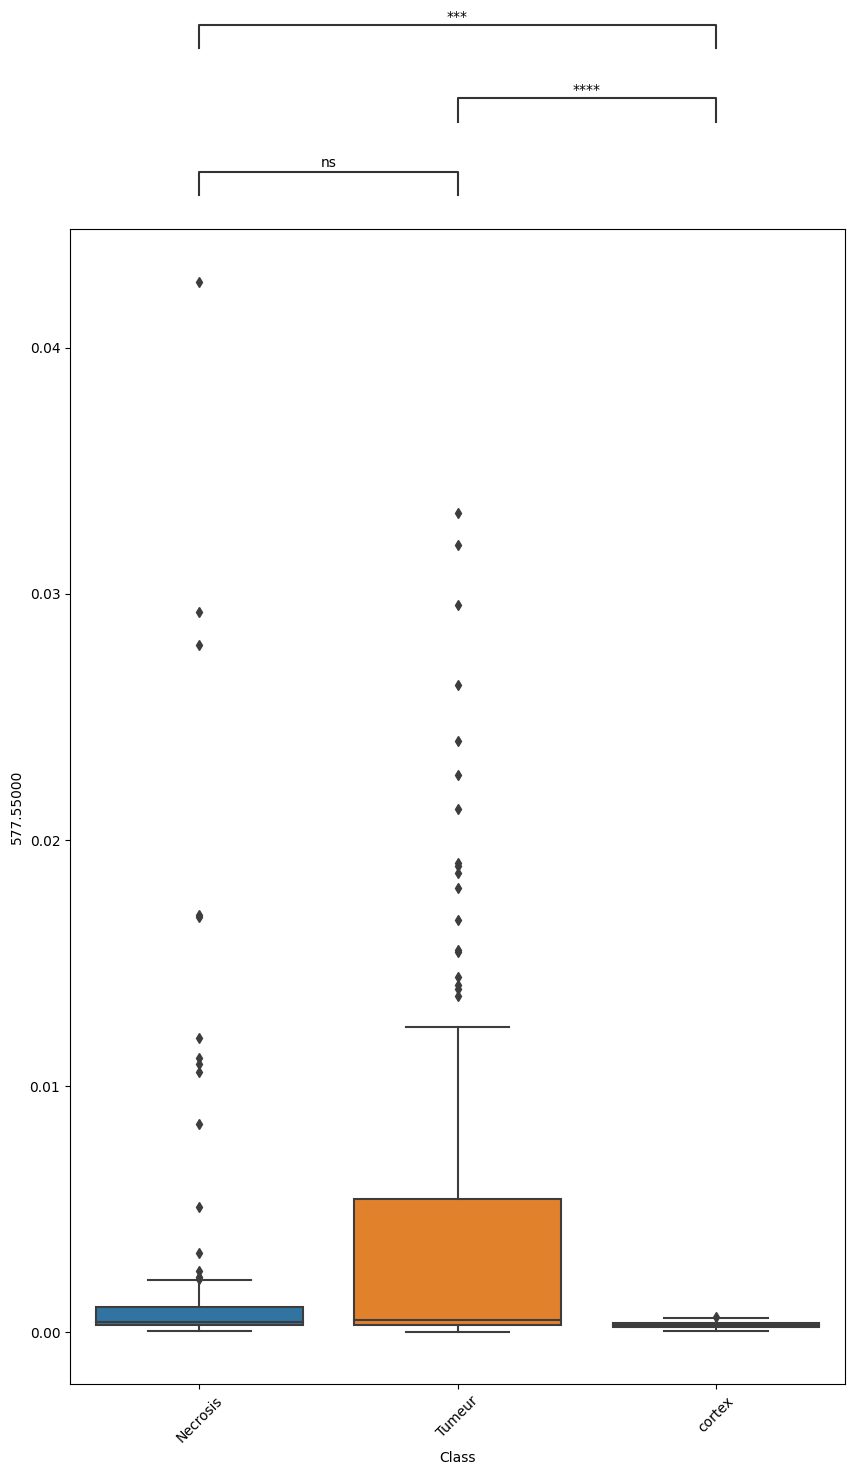

<Figure size 1500x1500 with 0 Axes>

In [44]:
label = 'Class'
order = data[label ].unique()
box_pairs = list(combinations(order, 2))
# Generate box plots for significant features
plot_significant_features(data_pick_picked, significant_mz_values, order, box_pairs, test='Kruskal')